In [ ]:
pip install spafe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 9.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import os
from sklearn.model_selection import train_test_split
from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis
from scipy.signal import get_window
import scipy.fftpack as fft
from scipy import signal
import matplotlib.pyplot as plt
from datetime import date
from tqdm import tqdm
from loading_functions import *

from feat_gen_functions import *

In [ ]:
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, zipfile

zip_path      = "/content/drive/MyDrive/Projeto - Classificação RF/DroneDetect_V2.zip"
extract_to    = "/content/drive/MyDrive/Projeto - Classificação RF/DroneDetect_V2"

os.makedirs(extract_to, exist_ok=True)          # garante pasta de destino
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_to)

print("Descompactação concluída!")


Descompactação concluída!


In [ ]:
# Data paths
dronedetect_raw_path = '/content/drive/MyDrive/Projeto - Classificação RF/DroneDetect_V2'
dronedetect_feat_path = '/content/drive/MyDrive/Projeto - Classificação RF/DroneDetect_V2_ESPEC'

# DroneDetect
main_folder = dronedetect_raw_path # data path on mp-gpu-desktop06
sub_folders = os.listdir(main_folder)

# Dataset Info
Fs = 60e6 #60 MHz
bandwidth = 28e6 # 28MHz
center_freq = 2.43e9


# Lendo e carregando os arquivos

# Não executar novamente!

In [ ]:
import os
import numpy as np

# Caminho do arquivo
file_path = ("/content/drive/MyDrive/Projeto - Classificação RF/"
             "DroneDetect_V2/DroneDetect_V2/CLEAN/AIR_FY/AIR_0010_00.dat")

FS = 60_000_000           # taxa de amostragem (Hz)

# ─── Método 1: via tamanho em bytes ──────────────────────────
size_bytes   = os.path.getsize(file_path)     # bytes no arquivo
bytes_sample = 2 * np.dtype('float32').itemsize   # I + Q → 8 bytes
num_samples  = size_bytes // bytes_sample
duration_s   = num_samples / FS

print(f"Duração (pelo tamanho do arquivo): {duration_s:.6f} s")

# ─── Método 2 (opcional): leitura parcial para conferir ──────
# Isto só confirma que há dados válidos; não é necessário
# para obter a duração.  Mantido aqui se você quiser garantir
# que o arquivo realmente contém float32 e não está corrompido.
with open(file_path, "rb") as f:
    arr = np.fromfile(f, dtype=np.float32, count=10)  # lê 10 floats
    if arr.size == 10:
        print("Leitura de teste OK – formato float32 confirmado.")


Duração (pelo tamanho do arquivo): 2.000000 s
Leitura de teste OK – formato float32 confirmado.


## ESPECTROGRAMAS

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gera_espectrogramas_dronedetect.py
──────────────────────────────────
Gera 1 espectrograma STFT (224×224) por segmento de 20 ms ao longo
de TODO o arquivo .dat do DroneDetect-V2, salvando em PNG ou NumPy.

Retomável via checkpoint.pickle (set, drone, arquivo).

Estrutura esperada:
<ROOT_DIR>/<interference>/<drone>/<arquivo>.dat
Ex.: .../CLEAN/AIR_FY/AIR_0010_00.dat
"""
from __future__ import annotations

import os, re, pickle, shutil
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm.auto import tqdm

# ─────────────────── CONFIGURAÇÕES ────────────────────
ROOT_DIR: str = ("/content/drive/MyDrive/Projeto - Classificação RF/"
                 "DroneDetect_V2/DroneDetect_V2")

# ======= bloco “Specifications” =========
n_per_seg: int            = 1024          # STFT: pontos por segmento
n_overlap_spec: int       = 120           # STFT: overlap
psd_win_type: str         = "hamming"     # janela ('hamming', 'hann', ...)
t_seg_ms: int             = 20            # duração de cada segmento (ms)
hop_ms: int               = 20            # passo entre segmentos (ms)
feature_to_save: List[str]= ['SPEC']      # ['SPEC','PSD','RAW']
format_to_save: List[str] = ['IMG']       # ['IMG','ARR'] ou ambas
inteference_folders       = ['CLEAN']     # ['WIFI','BLUE','BOTH','CLEAN']
to_add: bool              = True          # False = recriar pasta de saída
# =======================================

FS: int        = 60_000_000               # taxa de amostragem (Hz)
DIM_PX         = (224, 224)               # tamanho imagem
DPI_IMG        = 100
FEATURES_ROOT  = ROOT_DIR + "_FEATURES_MOD"
CHK_FILE       = Path(FEATURES_ROOT) / "checkpoint_MOD.pickle"
WINDOW         = get_window(psd_win_type, n_per_seg)

# Conversão ms → amostras
SAMP_SEG: int  = int(t_seg_ms / 1e3 * FS)
SAMP_HOP: int  = int(hop_ms  / 1e3 * FS)
assert SAMP_HOP > 0 and SAMP_SEG >= SAMP_HOP, "hop_ms deve ser >0 e ≤ t_seg_ms"

# ────────────────── UTILITÁRIAS ──────────────────
def load_iq(path: Path) -> np.ndarray:
    """Lê .dat (float32 intercalado) → complex64 normalizado (z-score)."""
    raw = np.fromfile(path, dtype=np.float32)
    iq  = raw.view(np.complex64)
    return (iq - iq.mean()) / (np.sqrt(iq.var() + 1e-10))

def calc_specgram(x: np.ndarray) -> np.ndarray:
    """Espectrograma (magnitude dB) mantendo apenas frequências ≥ 0."""
    _, _, Z = stft(x, fs=FS, nperseg=n_per_seg,
                   noverlap=n_overlap_spec, window=WINDOW,
                   return_onesided=False)
    spec = 20 * np.log10(np.abs(Z) + 1e-10)
    return spec[: spec.shape[0] // 2, :]   # corta a metade negativa

def save_png(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(DIM_PX[0]/DPI_IMG, DIM_PX[1]/DPI_IMG), dpi=DPI_IMG)
    plt.axis('off')
    plt.imshow(arr, origin='lower', aspect='auto', cmap='inferno')
    plt.savefig(folder / f"{name}.png", dpi=DPI_IMG,
                bbox_inches='tight', pad_inches=0)
    plt.close()

def save_npy(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    np.save(folder / f"{name}.npy", arr.astype(np.float32))

def load_ckpt() -> Dict[str, int]:
    if CHK_FILE.exists():
        return pickle.loads(CHK_FILE.read_bytes())
    return {"set_i": 0, "drone_i": 0, "file_i": 0}

def save_ckpt(state: Dict[str, int]):
    CHK_FILE.parent.mkdir(parents=True, exist_ok=True)
    CHK_FILE.write_bytes(pickle.dumps(state))

# ───────────────────── MAIN ──────────────────────
def main():
    # Prepara pasta de saída
    if not to_add and Path(FEATURES_ROOT).exists():
        shutil.rmtree(FEATURES_ROOT)
    Path(FEATURES_ROOT).mkdir(exist_ok=True)

    ckpt = load_ckpt()

    for set_i, interf in enumerate(inteference_folders[ckpt["set_i"]:], start=ckpt["set_i"]):
        dir_set = Path(ROOT_DIR) / interf
        drone_dirs = sorted(p for p in dir_set.iterdir() if p.is_dir())

        for d_i, drone_dir in enumerate(drone_dirs[ckpt["drone_i"]:], start=ckpt["drone_i"]):
            files = sorted(f for f in drone_dir.glob("*.dat"))

            for f_i, fpath in enumerate(files[ckpt["file_i"]:], start=ckpt["file_i"]):
                # ---- nomes amigáveis ----
                m_fold = re.match(r"([^_]+)_(.+)", drone_dir.name)
                drone_name, cond_name = (m_fold.groups()
                                         if m_fold else (drone_dir.name, "UNK"))

                m_file = re.match(r".*_(\d{4})_(\d{2})\.dat", fpath.name)
                fi_num, counter = (m_file.groups() if m_file else ("0000", "00"))

                # ---- processamento do arquivo ----
                iq = load_iq(fpath)
                n_segs = max(1, (len(iq) - SAMP_SEG) // SAMP_HOP + 1)

                for seg_idx in range(n_segs):
                    start, end = seg_idx * SAMP_HOP, seg_idx * SAMP_HOP + SAMP_SEG
                    if end > len(iq):
                        break
                    segment = iq[start:end]

                    if 'SPEC' in feature_to_save:
                        spec = calc_specgram(segment)

                    seg_tag = f"seg{seg_idx:03d}"
                    base = f"{interf}_{drone_name}_{cond_name}_{fi_num}_{counter}_{seg_tag}"

                    if 'IMG' in format_to_save and 'SPEC' in feature_to_save:
                        save_png(spec, Path(FEATURES_ROOT)/"IMG_SPEC", base)

                    if 'ARR' in format_to_save and 'SPEC' in feature_to_save:
                        save_npy(spec, Path(FEATURES_ROOT)/"ARR_SPEC", base)

                # ---- checkpoint: arquivo concluído ----
                ckpt.update({"set_i": set_i, "drone_i": d_i, "file_i": f_i+1})
                save_ckpt(ckpt)

            # terminou drone
            ckpt.update({"file_i": 0, "drone_i": d_i+1})
            save_ckpt(ckpt)

        # terminou interference set
        ckpt.update({"drone_i": 0, "set_i": set_i+1})
        save_ckpt(ckpt)

    print("✔️  Espectrogramas gerados para todos os arquivos e segmentos.")

# ────────────────────────────────
if __name__ == "__main__":
    main()


✔️  Espectrogramas gerados para todos os arquivos e segmentos.


In [ ]:
import os
from collections import defaultdict

# Caminho-raiz dos espectrogramas
root_dir = ("/content/drive/MyDrive/Projeto - Classificação RF/"
            "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD/IMG_SPEC")

# Inicializa contadores
total = 0
por_pasta = defaultdict(int)   # {subpasta: quantidade}

# Percorre recursivamente
for dirpath, _, files in os.walk(root_dir):
    # mantém apenas imagens; ajuste conforme necessário
    imgs = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if imgs:
        rel = os.path.relpath(dirpath, root_dir)  # subpasta relativa
        por_pasta[rel] += len(imgs)
        total += len(imgs)

# Mostra resultados
print(f"Total de imagens encontradas: {total}\n")
print("Contagem por subpasta:")
for pasta, qtd in sorted(por_pasta.items()):
    print(f"  {pasta:<40} {qtd:>6}")


Total de imagens encontradas: 9487

Contagem por subpasta:
  .                                          9487


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
conta_espectrogramas_por_drone.py
─────────────────────────────────────────────────────────────────
Percorre todos os PNG/JPG sob IMG_SPEC, extrai o tipo de drone
(padrão:  <interf>_<DRONE>_<cond>_<id>_segXXX.png)
e plota a distribuição com Plotly.

Exemplo de nome: CLEAN_AIR_FY_0010_00_seg000.png
 → tipo de drone = "AIR"
"""

import os
from collections import Counter
from pathlib import Path

import pandas as pd
import plotly.express as px

# Caminho-raiz dos espectrogramas
ROOT_DIR = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD/IMG_SPEC")

# ─────────── CONTAGEM ────────────
contador = Counter()

for path in ROOT_DIR.rglob("*"):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        partes = path.stem.split("_")            # divide pelo “_”
        if len(partes) >= 3:
            drone_tipo = partes[1]               # ex.: "AIR"
            contador[drone_tipo] += 1

# converte para DataFrame (mais fácil de ordenar/plotar)
df = (pd.DataFrame({"Drone": list(contador.keys()),
                    "Quantidade": list(contador.values())})
        .sort_values("Quantidade", ascending=False))

print(f"Total de imagens: {df['Quantidade'].sum()}")
display(df)

# ─────────── GRÁFICO ─────────────
fig = px.bar(df,
             x="Drone", y="Quantidade",
             text="Quantidade",
             color="Drone",
             title="Distribuição de Espectrogramas por Tipo de Drone",
             labels=dict(Drone="Tipo de Drone", Quantidade="Nº de Imagens"))

fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(yaxis=dict(title="Quantidade"),
                  xaxis=dict(title="Tipo de Drone"),
                  uniformtext_minsize=8, uniformtext_mode="hide",
                  bargap=0.25,
                  template="plotly_white")

fig.show()


Total de imagens: 9487


Drone  Quantidade
1   MP2        1500
2   MP1        1500
3   MIN        1500
6   AIR        1500
4   INS        1487
0   PHA        1000
5   DIS        1000

FAZER DATAAUGMENTED

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd

ROOT_IMG = Path(
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD/IMG_SPEC"
)
MODEL_DIR = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

rows, bad = [], []

for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexando / validando PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()                 # detecta PNG inválido
        parts = p.stem.split("_")
        if len(parts) >= 2:
            label = parts[1]            # segundo campo → rótulo (“AIR”, …)
            rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"Imagens válidas: {len(rows)}  –  Corrompidas descartadas: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "arquivos_corrompidos.txt",
                          index=False, header=False)

df = pd.DataFrame(rows)
print("\nDistribuição original (após filtro):")
display(df["label"].value_counts())


Indexando / validando PNGs: 0it [00:00, ?it/s]

Imagens válidas: 9470  –  Corrompidas descartadas: 17

Distribuição original (após filtro):


label
MP2    1500
MP1    1500
MIN    1500
AIR    1500
INS    1487
DIS    1000
PHA     983
Name: count, dtype: int64

ENG

# VGG - 20 ms

✅ GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 9470
Corrupted PNGs: 17

Original distribution (post-filter):


label
MP2    1500
MIN    1500
AIR    1500
MP1    1500
INS    1487
DIS    1000
PHA     983
Name: count, dtype: int64


Distribution after split:
Train     :
label
MP1    1200
MIN    1200
MP2    1200
AIR    1200
INS    1190
DIS     800
PHA     786
Name: count, dtype: int64
Validation:
label
MP2    150
MIN    150
MP1    150
AIR    150
INS    148
DIS    100
PHA     99
Name: count, dtype: int64
Test      :
label
MP2    150
MIN    150
AIR    150
MP1    150
INS    149
DIS    100
PHA     98
Name: count, dtype: int64
Found 7576 validated image filenames belonging to 7 classes.
Found 947 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.49102, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 270s - 1s/step - accuracy: 0.2216 - loss: 1.8543 - val_accuracy: 0.4910 - val_loss: 1.4595
Epoch 2/100



Epoch 2: val_accuracy improved from 0.49102 to 0.69799, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 152s - 641ms/step - accuracy: 0.5558 - loss: 1.1607 - val_accuracy: 0.6980 - val_loss: 0.7965
Epoch 3/100



Epoch 3: val_accuracy improved from 0.69799 to 0.75079, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 152s - 641ms/step - accuracy: 0.6960 - loss: 0.8239 - val_accuracy: 0.7508 - val_loss: 0.5958
Epoch 4/100



Epoch 4: val_accuracy improved from 0.75079 to 0.81204, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 150s - 631ms/step - accuracy: 0.7522 - loss: 0.6698 - val_accuracy: 0.8120 - val_loss: 0.4540
Epoch 5/100



Epoch 5: val_accuracy improved from 0.81204 to 0.84794, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 153s - 646ms/step - accuracy: 0.7928 - loss: 0.5816 - val_accuracy: 0.8479 - val_loss: 0.4090
Epoch 6/100



Epoch 6: val_accuracy improved from 0.84794 to 0.86378, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 151s - 636ms/step - accuracy: 0.8171 - loss: 0.5089 - val_accuracy: 0.8638 - val_loss: 0.3640
Epoch 7/100



Epoch 7: val_accuracy did not improve from 0.86378
237/237 - 144s - 608ms/step - accuracy: 0.8301 - loss: 0.4633 - val_accuracy: 0.8448 - val_loss: 0.4189
Epoch 8/100



Epoch 8: val_accuracy improved from 0.86378 to 0.86589, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 148s - 622ms/step - accuracy: 0.8428 - loss: 0.4240 - val_accuracy: 0.8659 - val_loss: 0.3389
Epoch 9/100



Epoch 9: val_accuracy improved from 0.86589 to 0.87856, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 150s - 631ms/step - accuracy: 0.8570 - loss: 0.3936 - val_accuracy: 0.8786 - val_loss: 0.3545
Epoch 10/100



Epoch 10: val_accuracy did not improve from 0.87856
237/237 - 149s - 627ms/step - accuracy: 0.8590 - loss: 0.3934 - val_accuracy: 0.8448 - val_loss: 0.4152
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.87856
237/237 - 144s - 609ms/step - accuracy: 0.8627 - loss: 0.3837 - val_accuracy: 0.8765 - val_loss: 0.2944
Epoch 12/100



Epoch 12: val_accuracy improved from 0.87856 to 0.89124, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 148s - 625ms/step - accuracy: 0.8833 - loss: 0.3342 - val_accuracy: 0.8912 - val_loss: 0.2855
Epoch 13/100



Epoch 13: val_accuracy improved from 0.89124 to 0.91447, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 152s - 641ms/step - accuracy: 0.8873 - loss: 0.3115 - val_accuracy: 0.9145 - val_loss: 0.2451
Epoch 14/100



Epoch 14: val_accuracy did not improve from 0.91447
237/237 - 148s - 626ms/step - accuracy: 0.8908 - loss: 0.3120 - val_accuracy: 0.8891 - val_loss: 0.2935
Epoch 15/100



Epoch 15: val_accuracy did not improve from 0.91447
237/237 - 145s - 613ms/step - accuracy: 0.8970 - loss: 0.2826 - val_accuracy: 0.8965 - val_loss: 0.2800
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.91447
237/237 - 146s - 615ms/step - accuracy: 0.8980 - loss: 0.2897 - val_accuracy: 0.9124 - val_loss: 0.2464
Epoch 17/100



Epoch 17: val_accuracy did not improve from 0.91447
237/237 - 146s - 615ms/step - accuracy: 0.9079 - loss: 0.2674 - val_accuracy: 0.8986 - val_loss: 0.2735
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.91447
237/237 - 144s - 608ms/step - accuracy: 0.9112 - loss: 0.2651 - val_accuracy: 0.9018 - val_loss: 0.2604
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.91447
237/237 - 146s - 618ms/step - accuracy: 0.9184 - loss: 0.2470 - val_accuracy: 0.9134 - val_loss: 0.2296
Epoch 20/100



Epoch 20: val_accuracy improved from 0.91447 to 0.93031, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 143s - 602ms/step - accuracy: 0.9223 - loss: 0.2335 - val_accuracy: 0.9303 - val_loss: 0.2036
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.93031
237/237 - 144s - 608ms/step - accuracy: 0.9196 - loss: 0.2375 - val_accuracy: 0.9261 - val_loss: 0.2109
Epoch 22/100



Epoch 22: val_accuracy did not improve from 0.93031
237/237 - 147s - 619ms/step - accuracy: 0.9270 - loss: 0.2108 - val_accuracy: 0.9271 - val_loss: 0.2034
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.93031
237/237 - 147s - 619ms/step - accuracy: 0.9278 - loss: 0.2113 - val_accuracy: 0.9250 - val_loss: 0.2040
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.93031
237/237 - 144s - 607ms/step - accuracy: 0.9356 - loss: 0.1960 - val_accuracy: 0.9155 - val_loss: 0.2363
Epoch 25/100



Epoch 25: val_accuracy improved from 0.93031 to 0.93875, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 142s - 597ms/step - accuracy: 0.9328 - loss: 0.1983 - val_accuracy: 0.9388 - val_loss: 0.1685
Epoch 26/100



Epoch 26: val_accuracy improved from 0.93875 to 0.94826, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 151s - 638ms/step - accuracy: 0.9382 - loss: 0.1749 - val_accuracy: 0.9483 - val_loss: 0.1476
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.94826
237/237 - 147s - 622ms/step - accuracy: 0.9359 - loss: 0.1862 - val_accuracy: 0.9440 - val_loss: 0.1668
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.94826
237/237 - 145s - 614ms/step - accuracy: 0.9473 - loss: 0.1534 - val_accuracy: 0.9356 - val_loss: 0.1751
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.94826
237/237 - 144s - 606ms/step - accuracy: 0.9417 - loss: 0.1691 - val_accuracy: 0.9250 - val_loss: 0.2254
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.94826
237/237 - 144s - 606ms/step - accuracy: 0.9417 - loss: 0.1622 - val_accuracy: 0.9314 - val_loss: 0.1715
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.94826
237/237 - 145s - 612ms/step - accuracy: 0.9465 - loss: 0.1551 - val_accuracy: 0.9356 - val_loss: 0.1708
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.94826
237/237 - 146s - 615ms/step - accuracy: 0.9456 - loss: 0.1569 - val_accuracy: 0.9335 - val_loss: 0.1683
Epoch 33/100



Epoch 33: val_accuracy improved from 0.94826 to 0.95248, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 148s - 624ms/step - accuracy: 0.9494 - loss: 0.1461 - val_accuracy: 0.9525 - val_loss: 0.1426
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.95248
237/237 - 150s - 631ms/step - accuracy: 0.9523 - loss: 0.1381 - val_accuracy: 0.9419 - val_loss: 0.1603
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.95248
237/237 - 146s - 617ms/step - accuracy: 0.9508 - loss: 0.1449 - val_accuracy: 0.9451 - val_loss: 0.1786
Epoch 36/100



Epoch 36: val_accuracy improved from 0.95248 to 0.95671, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 144s - 608ms/step - accuracy: 0.9543 - loss: 0.1280 - val_accuracy: 0.9567 - val_loss: 0.1403
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.95671
237/237 - 151s - 638ms/step - accuracy: 0.9530 - loss: 0.1385 - val_accuracy: 0.9388 - val_loss: 0.1685
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.95671
237/237 - 141s - 595ms/step - accuracy: 0.9529 - loss: 0.1305 - val_accuracy: 0.9451 - val_loss: 0.1536
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.95671
237/237 - 145s - 612ms/step - accuracy: 0.9612 - loss: 0.1178 - val_accuracy: 0.9451 - val_loss: 0.1555
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.95671
237/237 - 146s - 614ms/step - accuracy: 0.9592 - loss: 0.1244 - val_accuracy: 0.9483 - val_loss: 0.1447
Epoch 41/100



Epoch 41: val_accuracy improved from 0.95671 to 0.95882, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 146s - 617ms/step - accuracy: 0.9556 - loss: 0.1284 - val_accuracy: 0.9588 - val_loss: 0.1425
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.95882
237/237 - 148s - 625ms/step - accuracy: 0.9537 - loss: 0.1340 - val_accuracy: 0.9514 - val_loss: 0.1462
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.95882
237/237 - 145s - 612ms/step - accuracy: 0.9648 - loss: 0.0979 - val_accuracy: 0.9525 - val_loss: 0.1257
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.95882
237/237 - 145s - 612ms/step - accuracy: 0.9626 - loss: 0.1069 - val_accuracy: 0.9493 - val_loss: 0.1494
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.95882
237/237 - 143s - 604ms/step - accuracy: 0.9658 - loss: 0.0991 - val_accuracy: 0.9588 - val_loss: 0.1190
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.95882
237/237 - 141s - 594ms/step - accuracy: 0.9654 - loss: 0.1023 - val_accuracy: 0.9440 - val_loss: 0.1683
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.95882
237/237 - 124s - 525ms/step - accuracy: 0.9691 - loss: 0.0977 - val_accuracy: 0.9388 - val_loss: 0.1661
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.95882
237/237 - 119s - 503ms/step - accuracy: 0.9641 - loss: 0.1060 - val_accuracy: 0.9504 - val_loss: 0.1389
Epoch 49/100



Epoch 49: val_accuracy improved from 0.95882 to 0.96727, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 122s - 515ms/step - accuracy: 0.9683 - loss: 0.0924 - val_accuracy: 0.9673 - val_loss: 0.1145
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.96727
237/237 - 125s - 528ms/step - accuracy: 0.9670 - loss: 0.0998 - val_accuracy: 0.9588 - val_loss: 0.1168
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.96727
237/237 - 119s - 503ms/step - accuracy: 0.9703 - loss: 0.0909 - val_accuracy: 0.9609 - val_loss: 0.1348
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.96727
237/237 - 119s - 504ms/step - accuracy: 0.9667 - loss: 0.0973 - val_accuracy: 0.9641 - val_loss: 0.1156
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.96727
237/237 - 119s - 504ms/step - accuracy: 0.9700 - loss: 0.0859 - val_accuracy: 0.9599 - val_loss: 0.1319
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.96727
237/237 - 120s - 505ms/step - accuracy: 0.9702 - loss: 0.0849 - val_accuracy: 0.9609 - val_loss: 0.1309
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.96727
237/237 - 119s - 503ms/step - accuracy: 0.9649 - loss: 0.1056 - val_accuracy: 0.9504 - val_loss: 0.1346
Epoch 56/100



Epoch 56: val_accuracy improved from 0.96727 to 0.97149, saving model to /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5


237/237 - 122s - 515ms/step - accuracy: 0.9683 - loss: 0.0873 - val_accuracy: 0.9715 - val_loss: 0.1007
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.97149
237/237 - 124s - 524ms/step - accuracy: 0.9724 - loss: 0.0826 - val_accuracy: 0.9567 - val_loss: 0.1278
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.97149
237/237 - 123s - 518ms/step - accuracy: 0.9715 - loss: 0.0765 - val_accuracy: 0.9483 - val_loss: 0.1422
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.97149
237/237 - 119s - 504ms/step - accuracy: 0.9711 - loss: 0.0830 - val_accuracy: 0.9567 - val_loss: 0.1278
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9749 - loss: 0.0776 - val_accuracy: 0.9609 - val_loss: 0.1345
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9758 - loss: 0.0697 - val_accuracy: 0.9588 - val_loss: 0.1294
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9757 - loss: 0.0665 - val_accuracy: 0.9472 - val_loss: 0.1477
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9743 - loss: 0.0767 - val_accuracy: 0.9366 - val_loss: 0.2478
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9794 - loss: 0.0671 - val_accuracy: 0.9578 - val_loss: 0.1725
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9766 - loss: 0.0701 - val_accuracy: 0.9662 - val_loss: 0.0948
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.97149
237/237 - 120s - 504ms/step - accuracy: 0.9802 - loss: 0.0568 - val_accuracy: 0.9514 - val_loss: 0.1762
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.97149
237/237 - 119s - 502ms/step - accuracy: 0.9694 - loss: 0.0923 - val_accuracy: 0.9546 - val_loss: 0.1390
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.97149
237/237 - 119s - 503ms/step - accuracy: 0.9813 - loss: 0.0579 - val_accuracy: 0.9556 - val_loss: 0.1896
Epoch 69/100



Epoch 69: val_accuracy did not improve from 0.97149
237/237 - 119s - 502ms/step - accuracy: 0.9781 - loss: 0.0654 - val_accuracy: 0.9377 - val_loss: 0.1945
Epoch 70/100



Epoch 70: val_accuracy did not improve from 0.97149
237/237 - 119s - 501ms/step - accuracy: 0.9770 - loss: 0.0662 - val_accuracy: 0.9630 - val_loss: 0.1465
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.97149
237/237 - 119s - 504ms/step - accuracy: 0.9810 - loss: 0.0599 - val_accuracy: 0.9588 - val_loss: 0.1391
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 56.


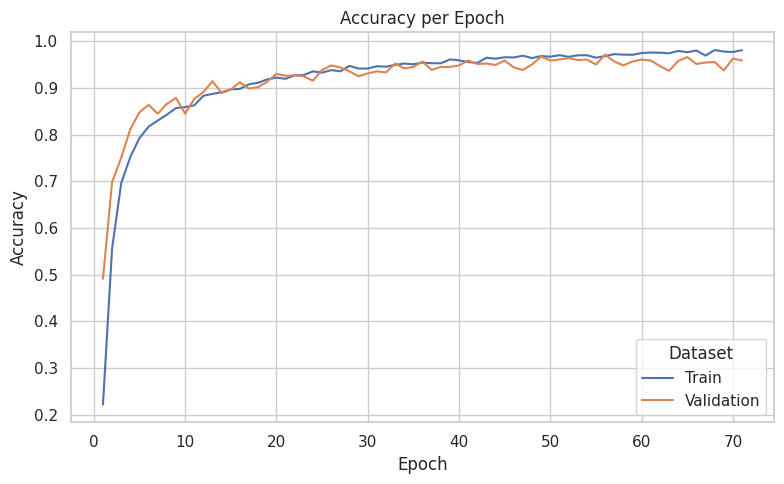

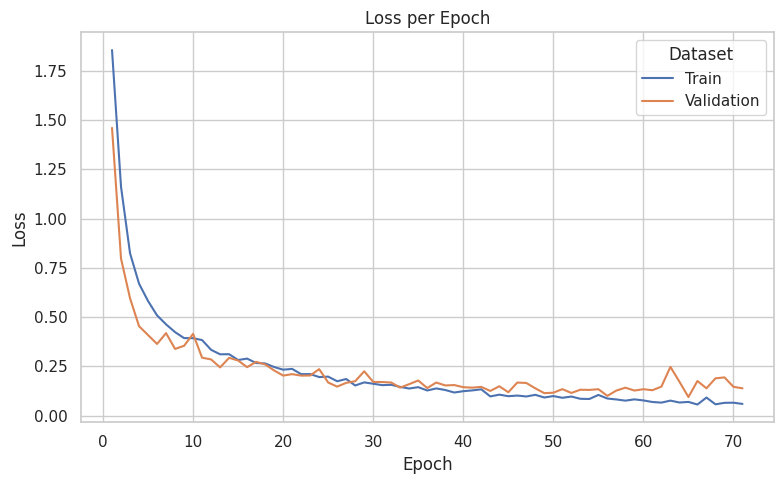

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Trains a VGG-16 from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""

import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vgg_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU detected: {gpus[0].name}")
    except RuntimeError:
        print(" GPUs already initialized; memory growth could not be configured.")
else:
    print(" GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

# build DataFrame
import pandas as pd

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
display(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL ──────────
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model = VGG16(weights=None, include_top=False,
                       input_shape=(*IMG_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


ENG

Loading model from /content/drive/MyDrive/DroneDetect_VGG/vgg_drone.h5 …


Total test samples: 947
Test set distribution:
label
MP2    150
MIN    150
AIR    150
MP1    150
INS    149
DIS    100
PHA     98
Name: count, dtype: int64 

Found 947 validated image filenames belonging to 7 classes.
Performing predictions on test set…


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step

Classification Report:
              precision    recall  f1-score   support

         AIR     0.9355    0.9667    0.9508       150
         DIS     1.0000    0.9900    0.9950       100
         INS     0.9669    0.9799    0.9733       149
         MIN     1.0000    1.0000    1.0000       150
         MP1     0.9789    0.9267    0.9521       150
         MP2     0.9423    0.9800    0.9608       150
         PHA     0.9787    0.9388    0.9583        98

    accuracy                         0.9694       947
   macro avg     0.9718    0.9689    0.9700       947
weighted avg     0.9699    0.9694    0.9694       947



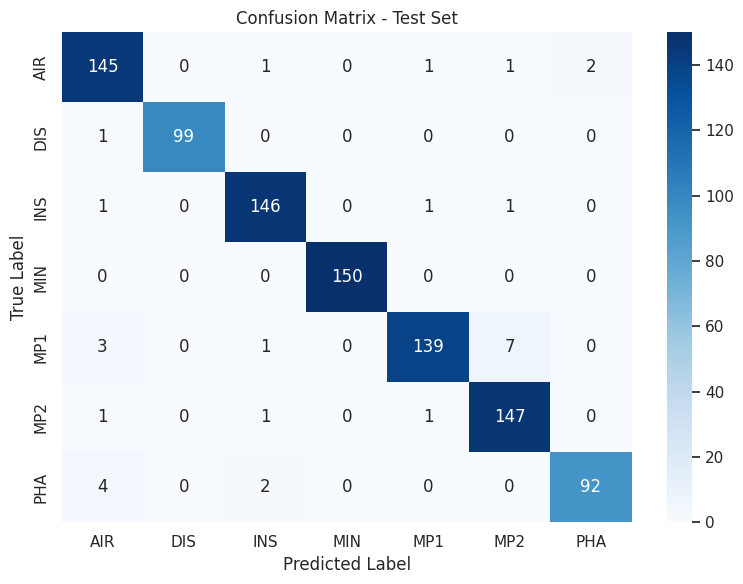

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Loads the saved "vgg_drone.h5" model, evaluates on the test split,
prints classification metrics and displays a confusion matrix using seaborn.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_PATH = MODEL_DIR / "vgg_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ─────────── LOAD MODEL ───────────
print(f"Loading model from {MODEL_PATH} …")
model = tf.keras.models.load_model(MODEL_PATH)

# ─────────── LOAD TEST SPLIT ───────────
test_df = pd.read_csv(TEST_CSV)
print(f"Total test samples: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts(), "\n")

# ─────────── TEST DATA GENERATOR ───────────
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    test_df,
    x_col="path", y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# ─────────── PREDICTIONS ───────────
print("Performing predictions on test set…")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes
labels = list(gen_test.class_indices.keys())

# ─────────── CLASSIFICATION REPORT ───────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# ─────────── CONFUSION MATRIX ───────────
cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


COM GRID

INTERFERIDOR

In [ ]:
pip install rarfile


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
extract_all_rars.py
────────────────────────────────────────────────────────────
Varre recursivamente uma pasta em busca de arquivos .rar
e extrai cada um no seu diretório pai.
"""

import os
import rarfile

# Se necessário, ajuste para o caminho do seu binário unrar/rar
# rarfile.UNRAR_TOOL = "/usr/bin/unrar"

INPUT_DIR = r"/content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1"

def extract_rars(root_dir: str) -> None:
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith(".rar"):
                rar_path = os.path.join(dirpath, fname)
                try:
                    with rarfile.RarFile(rar_path) as rf:
                        print(f" Extraindo {rar_path} → {dirpath}")
                        rf.extractall(path=dirpath)
                    print(f" Extraído: {rar_path}")
                except Exception as e:
                    print(f"⚠ Falha ao extrair {rar_path}: {e}")

if __name__ == "__main__":
    # Certifique-se de ter instalado: pip install rarfile
    extract_rars(INPUT_DIR)


⏳ Extraindo /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1/FR Data_00000_H2.rar → /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1
 Extraído: /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1/FR Data_00000_H2.rar
⏳ Extraindo /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1/RF Data_00000_L2.rar → /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1
 Extraído: /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1/RF Data_00000_L2.rar
⏳ Extraindo /content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1/RF Data_00000_L1.rar → /content/drive/MyDrive/Projeto - 

espectro dos ruidos

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
read_noise_csv.py (com tqdm)
────────────────────────────────────────────────────────────
Lê um arquivo CSV de ruído de ambiente em chunks, exibindo
uma barra de progresso com tqdm, e apresenta informações
básicas ao final.
"""

import os
import math
import pandas as pd
from tqdm.auto import tqdm

def read_and_describe(csv_path: str, chunk_size: int = 10_000) -> pd.DataFrame:
    """
    Lê o CSV em `csv_path` por chunks de tamanho `chunk_size`,
    exibe uma barra de progresso, concatena e retorna o DataFrame.
    Também imprime info(), head() e describe().
    """
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {csv_path}")

    # conta linhas para estimar total de chunks (subtrai 1 header)
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        total_lines = sum(1 for _ in f) - 1
    total_chunks = math.ceil(total_lines / chunk_size)

    # lê em chunks com barra de progresso
    chunks = []
    iterator = pd.read_csv(csv_path, chunksize=chunk_size, iterator=True, encoding="utf-8", low_memory=False)
    for chunk in tqdm(iterator, total=total_chunks, desc="Lendo CSV", unit="chunk"):
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)

    # Informações gerais
    print(f"\n▶ Lido: {csv_path}")
    print("\nInformações do DataFrame:")
    df.info()

    # Primeiras linhas
    print("\nPrimeiras 5 linhas:")
    print(df.head())

    # Estatísticas descritivas
    print("\nEstatísticas descritivas (colunas numéricas):")
    print(df.describe())

    return df

if __name__ == "__main__":
    CSV_PATH = r"/content/drive/MyDrive/Projeto - Classificação RF/BACKGROUNG EM: https:  data.mendeley.com datasets f4c2b4n755 1/FR Data_00000_H2/00000H_21.csv"
    df_noise = read_and_describe(CSV_PATH)


# TRANSFORMER - 20 ms

GPU not found; using CPU.


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 9470
Corrupted PNGs: 17

Original distribution (post-filter):
label
MP2    1500
MP1    1500
MIN    1500
AIR    1500
INS    1487
DIS    1000
PHA     983
Name: count, dtype: int64

Distribution after split:
Train     :
label
MP1    1200
MIN    1200
MP2    1200
AIR    1200
INS    1190
DIS     800
PHA     786
Name: count, dtype: int64
Validation:
label
MP2    150
MIN    150
MP1    150
AIR    150
INS    148
DIS    100
PHA     99
Name: count, dtype: int64
Test      :
label
MP2    150
MIN    150
AIR    150
MP1    150
INS    149
DIS    100
PHA     98
Name: count, dtype: int64
Found 7576 validated image filenames belonging to 7 classes.
Found 947 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


Model: "ViT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 14, 14,    │     49,216 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_patches     │ (None, 196, 64)   │          0 │ patch_embedding[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ reshape_patches[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block0          │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block0         │ (None, 196, 64)   │     66,368 │ ln1_block0[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block0[0][0… │
│ (Add)               │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block0          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block0 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block0 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block0 │ (None, 196, 64)   │          0 │ mlp2_block0[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block1          │ (None, 196, 64)   │        128 │ residual_mlp_blo… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block1         │ (None, 196, 64)   │     66,368 │ ln1_block1[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block1[0][0… │
│ (Add)               │                   │            │ residual_mlp_blo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block1          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block1 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block1 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block1 │ (None, 196, 64)   │          0 │ mlp2_block1[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 715,399 (2.73 MB)

 Trainable params: 715,399 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.36959, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 412s - 2s/step - accuracy: 0.1998 - loss: 2.2116 - val_accuracy: 0.3696 - val_loss: 1.6636
Epoch 2/100



Epoch 2: val_accuracy improved from 0.36959 to 0.46040, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 291s - 1s/step - accuracy: 0.3103 - loss: 1.8156 - val_accuracy: 0.4604 - val_loss: 1.4340
Epoch 3/100



Epoch 3: val_accuracy improved from 0.46040 to 0.56705, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 297s - 1s/step - accuracy: 0.4263 - loss: 1.5000 - val_accuracy: 0.5671 - val_loss: 1.1838
Epoch 4/100



Epoch 4: val_accuracy improved from 0.56705 to 0.63992, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 316s - 1s/step - accuracy: 0.5090 - loss: 1.2860 - val_accuracy: 0.6399 - val_loss: 0.9780
Epoch 5/100



Epoch 5: val_accuracy improved from 0.63992 to 0.65892, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 312s - 1s/step - accuracy: 0.5682 - loss: 1.1518 - val_accuracy: 0.6589 - val_loss: 0.9085
Epoch 6/100



Epoch 6: val_accuracy improved from 0.65892 to 0.69694, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 300s - 1s/step - accuracy: 0.6135 - loss: 1.0512 - val_accuracy: 0.6969 - val_loss: 0.8368
Epoch 7/100



Epoch 7: val_accuracy did not improve from 0.69694
237/237 - 305s - 1s/step - accuracy: 0.6423 - loss: 0.9846 - val_accuracy: 0.6610 - val_loss: 0.8929
Epoch 8/100



Epoch 8: val_accuracy improved from 0.69694 to 0.73178, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 300s - 1s/step - accuracy: 0.6568 - loss: 0.9381 - val_accuracy: 0.7318 - val_loss: 0.7456
Epoch 9/100



Epoch 9: val_accuracy improved from 0.73178 to 0.75290, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 296s - 1s/step - accuracy: 0.6833 - loss: 0.8818 - val_accuracy: 0.7529 - val_loss: 0.6828
Epoch 10/100



Epoch 10: val_accuracy improved from 0.75290 to 0.75924, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 292s - 1s/step - accuracy: 0.6975 - loss: 0.8339 - val_accuracy: 0.7592 - val_loss: 0.6708
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.75924
237/237 - 300s - 1s/step - accuracy: 0.7327 - loss: 0.7486 - val_accuracy: 0.7487 - val_loss: 0.7133
Epoch 12/100



Epoch 12: val_accuracy improved from 0.75924 to 0.78247, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 304s - 1s/step - accuracy: 0.7467 - loss: 0.6953 - val_accuracy: 0.7825 - val_loss: 0.6138
Epoch 13/100



Epoch 13: val_accuracy improved from 0.78247 to 0.78564, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 306s - 1s/step - accuracy: 0.7615 - loss: 0.6809 - val_accuracy: 0.7856 - val_loss: 0.5822
Epoch 14/100



Epoch 14: val_accuracy improved from 0.78564 to 0.80148, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 295s - 1s/step - accuracy: 0.7698 - loss: 0.6402 - val_accuracy: 0.8015 - val_loss: 0.5638
Epoch 15/100



Epoch 15: val_accuracy improved from 0.80148 to 0.80570, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 296s - 1s/step - accuracy: 0.7903 - loss: 0.5909 - val_accuracy: 0.8057 - val_loss: 0.5300
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.80570
237/237 - 301s - 1s/step - accuracy: 0.7987 - loss: 0.5740 - val_accuracy: 0.7983 - val_loss: 0.5265
Epoch 17/100



Epoch 17: val_accuracy improved from 0.80570 to 0.81098, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 289s - 1s/step - accuracy: 0.8081 - loss: 0.5537 - val_accuracy: 0.8110 - val_loss: 0.5210
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.81098
237/237 - 295s - 1s/step - accuracy: 0.8115 - loss: 0.5442 - val_accuracy: 0.8068 - val_loss: 0.5197
Epoch 19/100



Epoch 19: val_accuracy improved from 0.81098 to 0.81837, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 318s - 1s/step - accuracy: 0.8082 - loss: 0.5443 - val_accuracy: 0.8184 - val_loss: 0.5004
Epoch 20/100



Epoch 20: val_accuracy improved from 0.81837 to 0.85111, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 306s - 1s/step - accuracy: 0.8284 - loss: 0.4933 - val_accuracy: 0.8511 - val_loss: 0.4198
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.85111
237/237 - 289s - 1s/step - accuracy: 0.8292 - loss: 0.4896 - val_accuracy: 0.8300 - val_loss: 0.4371
Epoch 22/100



Epoch 22: val_accuracy did not improve from 0.85111
237/237 - 300s - 1s/step - accuracy: 0.8285 - loss: 0.4897 - val_accuracy: 0.8437 - val_loss: 0.4098
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.85111
237/237 - 297s - 1s/step - accuracy: 0.8280 - loss: 0.4900 - val_accuracy: 0.8437 - val_loss: 0.4075
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.85111
237/237 - 323s - 1s/step - accuracy: 0.8326 - loss: 0.4867 - val_accuracy: 0.8247 - val_loss: 0.4585
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.85111
237/237 - 350s - 1s/step - accuracy: 0.8346 - loss: 0.4582 - val_accuracy: 0.8448 - val_loss: 0.4097
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.85111
237/237 - 293s - 1s/step - accuracy: 0.8396 - loss: 0.4453 - val_accuracy: 0.8479 - val_loss: 0.4110
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.85111
237/237 - 289s - 1s/step - accuracy: 0.8440 - loss: 0.4398 - val_accuracy: 0.8300 - val_loss: 0.4575
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.85111
237/237 - 289s - 1s/step - accuracy: 0.8474 - loss: 0.4343 - val_accuracy: 0.8310 - val_loss: 0.4244
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.85111
237/237 - 284s - 1s/step - accuracy: 0.8495 - loss: 0.4288 - val_accuracy: 0.8458 - val_loss: 0.4084
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.85111
237/237 - 297s - 1s/step - accuracy: 0.8444 - loss: 0.4431 - val_accuracy: 0.8511 - val_loss: 0.4002
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.85111
237/237 - 301s - 1s/step - accuracy: 0.8482 - loss: 0.4259 - val_accuracy: 0.8448 - val_loss: 0.4081
Epoch 32/100



Epoch 32: val_accuracy improved from 0.85111 to 0.85956, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 286s - 1s/step - accuracy: 0.8474 - loss: 0.4283 - val_accuracy: 0.8596 - val_loss: 0.3754
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.85956
237/237 - 302s - 1s/step - accuracy: 0.8540 - loss: 0.4140 - val_accuracy: 0.8469 - val_loss: 0.4107
Epoch 34/100



Epoch 34: val_accuracy improved from 0.85956 to 0.87751, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 311s - 1s/step - accuracy: 0.8528 - loss: 0.4167 - val_accuracy: 0.8775 - val_loss: 0.3542
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.87751
237/237 - 323s - 1s/step - accuracy: 0.8512 - loss: 0.4096 - val_accuracy: 0.8490 - val_loss: 0.4048
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.87751
237/237 - 297s - 1s/step - accuracy: 0.8534 - loss: 0.4083 - val_accuracy: 0.8574 - val_loss: 0.3820
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.87751
237/237 - 300s - 1s/step - accuracy: 0.8634 - loss: 0.3858 - val_accuracy: 0.8733 - val_loss: 0.3558
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.87751
237/237 - 317s - 1s/step - accuracy: 0.8606 - loss: 0.3845 - val_accuracy: 0.8775 - val_loss: 0.3538
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.87751
237/237 - 297s - 1s/step - accuracy: 0.8577 - loss: 0.3959 - val_accuracy: 0.8511 - val_loss: 0.4091
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.87751
237/237 - 299s - 1s/step - accuracy: 0.8633 - loss: 0.3958 - val_accuracy: 0.8669 - val_loss: 0.3697
Epoch 41/100



Epoch 41: val_accuracy improved from 0.87751 to 0.88490, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 307s - 1s/step - accuracy: 0.8598 - loss: 0.3878 - val_accuracy: 0.8849 - val_loss: 0.3353
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.88490
237/237 - 297s - 1s/step - accuracy: 0.8640 - loss: 0.3773 - val_accuracy: 0.8743 - val_loss: 0.3576
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.88490
237/237 - 300s - 1s/step - accuracy: 0.8646 - loss: 0.3750 - val_accuracy: 0.8743 - val_loss: 0.3573
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.88490
237/237 - 307s - 1s/step - accuracy: 0.8638 - loss: 0.3732 - val_accuracy: 0.8669 - val_loss: 0.3712
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.88490
237/237 - 289s - 1s/step - accuracy: 0.8679 - loss: 0.3673 - val_accuracy: 0.8669 - val_loss: 0.3684
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.88490
237/237 - 292s - 1s/step - accuracy: 0.8656 - loss: 0.3662 - val_accuracy: 0.8817 - val_loss: 0.3364
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.88490
237/237 - 314s - 1s/step - accuracy: 0.8721 - loss: 0.3577 - val_accuracy: 0.8775 - val_loss: 0.3198
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.88490
237/237 - 300s - 1s/step - accuracy: 0.8684 - loss: 0.3571 - val_accuracy: 0.8796 - val_loss: 0.3394
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.88490
237/237 - 279s - 1s/step - accuracy: 0.8749 - loss: 0.3537 - val_accuracy: 0.8701 - val_loss: 0.3555
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.88490
237/237 - 301s - 1s/step - accuracy: 0.8738 - loss: 0.3572 - val_accuracy: 0.8786 - val_loss: 0.3592
Epoch 51/100



Epoch 51: val_accuracy improved from 0.88490 to 0.89229, saving model to /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5


237/237 - 301s - 1s/step - accuracy: 0.8692 - loss: 0.3590 - val_accuracy: 0.8923 - val_loss: 0.3128
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.89229
237/237 - 315s - 1s/step - accuracy: 0.8701 - loss: 0.3545 - val_accuracy: 0.8786 - val_loss: 0.3183
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.89229
237/237 - 326s - 1s/step - accuracy: 0.8709 - loss: 0.3545 - val_accuracy: 0.8691 - val_loss: 0.3585
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.89229
237/237 - 295s - 1s/step - accuracy: 0.8735 - loss: 0.3582 - val_accuracy: 0.8838 - val_loss: 0.3423
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.89229
237/237 - 297s - 1s/step - accuracy: 0.8751 - loss: 0.3435 - val_accuracy: 0.8754 - val_loss: 0.3298
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.89229
237/237 - 290s - 1s/step - accuracy: 0.8761 - loss: 0.3448 - val_accuracy: 0.8817 - val_loss: 0.3233
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.89229
237/237 - 293s - 1s/step - accuracy: 0.8767 - loss: 0.3374 - val_accuracy: 0.8786 - val_loss: 0.3315
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.89229
237/237 - 306s - 1s/step - accuracy: 0.8751 - loss: 0.3455 - val_accuracy: 0.8828 - val_loss: 0.3290
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.89229
237/237 - 313s - 1s/step - accuracy: 0.8783 - loss: 0.3393 - val_accuracy: 0.8807 - val_loss: 0.3361
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.89229
237/237 - 315s - 1s/step - accuracy: 0.8791 - loss: 0.3282 - val_accuracy: 0.8828 - val_loss: 0.3121
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.89229
237/237 - 324s - 1s/step - accuracy: 0.8758 - loss: 0.3350 - val_accuracy: 0.8849 - val_loss: 0.3354
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.89229
237/237 - 293s - 1s/step - accuracy: 0.8778 - loss: 0.3345 - val_accuracy: 0.8838 - val_loss: 0.3217
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.89229
237/237 - 300s - 1s/step - accuracy: 0.8816 - loss: 0.3268 - val_accuracy: 0.8775 - val_loss: 0.3174
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.89229
237/237 - 299s - 1s/step - accuracy: 0.8827 - loss: 0.3217 - val_accuracy: 0.8743 - val_loss: 0.3311
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.89229
237/237 - 299s - 1s/step - accuracy: 0.8816 - loss: 0.3216 - val_accuracy: 0.8796 - val_loss: 0.3121
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.89229
237/237 - 319s - 1s/step - accuracy: 0.8840 - loss: 0.3211 - val_accuracy: 0.8870 - val_loss: 0.3093
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 51.


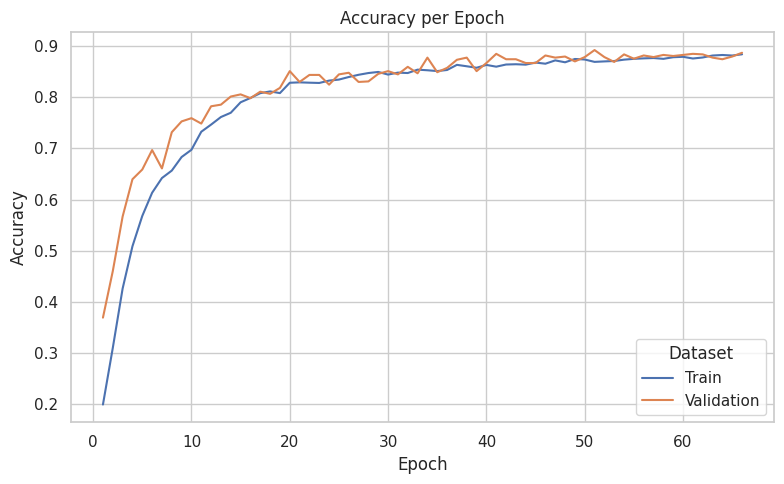

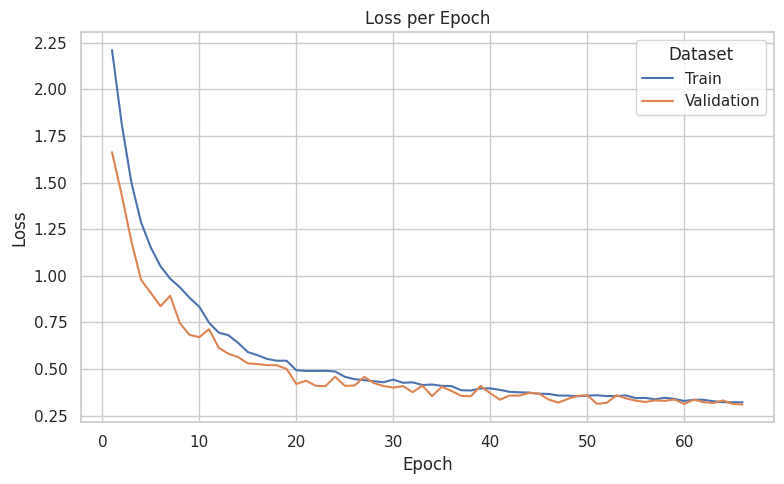

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vit_drone.py
────────────────────────────────────────────────────────────────────────
Trains a Vision Transformer from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vit_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0].name}")
    except RuntimeError:
        print("GPUs already initialized; memory growth could not be configured.")
else:
    print("GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
print(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL (USING VISION TRANSFORMER) ──────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128, transformer_layers=8,
                          dropout=0.5):
    """
    Basic Vision Transformer:
    - Extract patches via Conv2D
    - Project patches into embeddings
    - Add positional embeddings
    - Stack transformer blocks (MHSA + MLP)
    - Pool and classification head
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim), name='reshape_patches')(x)

    # 2) Positional embedding
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=n_patches,
                                     output_dim=embed_dim,
                                     name='pos_embedding')(positions)
    x = x + pos_embedding

    # 3) Transformer blocks
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln1_block{i}')(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                         key_dim=embed_dim,
                                         name=f'mhsa_block{i}')(x1, x1)
        x2 = layers.Add(name=f'residual_attn_block{i}')([attn, x])

        x3 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln2_block{i}')(x2)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(x3)
        mlp = layers.Dense(embed_dim,
                           name=f'mlp2_block{i}')(mlp)
        x = layers.Add(name=f'residual_mlp_block{i}')([mlp, x2])

    # 4) Pooling + classifier head
    x = layers.LayerNormalization(epsilon=1e-6,
                                   name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='ViT_Classifier')

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=num_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")
history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()



► Attempting to load model from /content/drive/MyDrive/DroneDetect_ViT/vit_drone.h5 …
⚠ Could not load full model (too many positional arguments). Rebuilding architecture …
✔ Weights loaded with model.load_weights().

Total test samples: 947
Test-set class distribution:
 label
MP2    150
MIN    150
AIR    150
MP1    150
INS    149
DIS    100
PHA     98
Name: count, dtype: int64 

Found 947 validated image filenames belonging to 7 classes.
► Generating predictions …


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 563ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         AIR     0.9328    0.7400    0.8253       150
         DIS     0.9608    0.9800    0.9703       100
         INS     0.7609    0.9396    0.8408       149
         MIN     0.9804    1.0000    0.9901       150
         MP1     0.9385    0.8133    0.8714       150
         MP2     0.8313    0.8867    0.8581       150
         PHA     0.9495    0.9592    0.9543        98

    accuracy                         0.8955       947
   macro avg     0.9077    0.9027    0.9015       947
weighted avg     0.9028    0.8955    0.8950       947



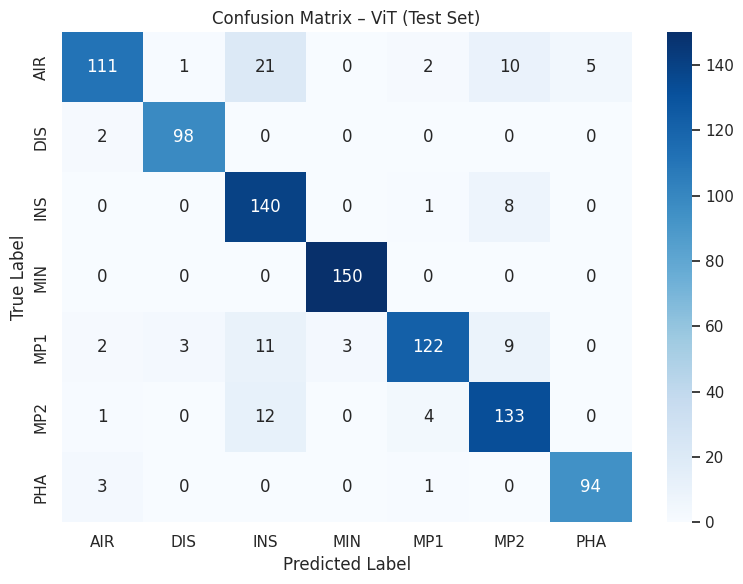

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vit_drone.py
────────────────────────────────────────────────────────────────────────
Evaluates the Vision Transformer (ViT) trained to classify drone types.

Workflow
╰─►  1) Attempts to load the full .h5 model; if that fails, rebuilds the
        architecture and loads only the weights.
     2) Generates predictions on the test split stored in test_split.csv.
     3) Prints a classification report and displays a confusion matrix
        with English titles and axis labels.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT")
MODEL_PATH = MODEL_DIR / "vit_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 1) Function to rebuild the same ViT architecture used during training
# ──────────────────────────────────────────────────────────────────────────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128,
                          transformer_layers=8, dropout=0.5):
    """Minimal Vision Transformer classifier."""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim),
                       name='reshape_patches')(x)

    # Learnable positional embeddings
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_emb   = layers.Embedding(input_dim=n_patches,
                                 output_dim=embed_dim,
                                 name='pos_embedding')(positions)
    x = x + pos_emb

    # Transformer encoder blocks
    for i in range(transformer_layers):
        # Multi-head self-attention
        ln1 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln1_block{i}')(x)
        att = layers.MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim,
                                        name=f'mhsa_block{i}')(ln1, ln1)
        x   = layers.Add(name=f'residual_attn_block{i}')([att, x])

        # Feed-forward MLP
        ln2 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln2_block{i}')(x)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(ln2)
        mlp = layers.Dense(embed_dim, name=f'mlp2_block{i}')(mlp)
        x   = layers.Add(name=f'residual_mlp_block{i}')([mlp, x])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6, name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs, outputs, name='ViT_Classifier')

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load the trained model (full model or just weights)
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n► Attempting to load model from {MODEL_PATH} …")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✔ Model loaded successfully with tf.keras.models.load_model().")
except Exception as e:
    print(f"⚠ Could not load full model ({e}). Rebuilding architecture …")
    # Read test CSV to infer the number of classes
    tmp_df     = pd.read_csv(TEST_CSV)
    class_list = sorted(tmp_df["label"].unique())
    n_classes  = len(class_list)

    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=n_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.load_weights(MODEL_PATH)
    print("✔ Weights loaded with model.load_weights().")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Prepare the test data generator
# ──────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv(TEST_CSV)
print(f"\nTotal test samples: {len(test_df)}")
print("Test-set class distribution:\n", test_df["label"].value_counts(), "\n")

datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)
label_names = list(gen_test.class_indices.keys())

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluation
# ──────────────────────────────────────────────────────────────────────────────
print("► Generating predictions …")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix – ViT (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# VGG - 15 ms

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gera_espectrogramas_dronedetect.py
──────────────────────────────────
Gera 1 espectrograma STFT (224×224) por segmento de 15 ms ao longo
de TODO o arquivo .dat do DroneDetect-V2, salvando em PNG ou NumPy.

Retomável via checkpoint_MOD.pickle (set, drone, arquivo).

Estrutura esperada:
<ROOT_DIR>/<interference>/<drone>/<arquivo>.dat
Ex.: .../CLEAN/AIR_FY/AIR_0010_00.dat
"""
from __future__ import annotations

import os
import re
import pickle
import shutil
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm.auto import tqdm

# ─────────────────── CONFIGURAÇÕES ────────────────────
ROOT_DIR: str = (
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2"
)

# ======= bloco “Specifications” =========
n_per_seg: int            = 1024          # STFT: pontos por segmento
n_overlap_spec: int       = 120           # STFT: overlap
psd_win_type: str         = "hamming"     # janela ('hamming', 'hann', ...)
t_seg_ms: int             = 15            # duração de cada segmento (ms)
hop_ms: int               = 15            # passo entre segmentos (ms)
feature_to_save: List[str]= ['SPEC']      # ['SPEC','PSD','RAW']
format_to_save: List[str] = ['IMG']       # ['IMG','ARR'] ou ambas
interference_folders       = ['CLEAN']     # ['WIFI','BLUE','BOTH','CLEAN']
to_add: bool              = True          # False = recriar pasta de saída
# =======================================

FS: int        = 60_000_000               # taxa de amostragem (Hz)
DIM_PX         = (224, 224)               # tamanho imagem
DPI_IMG        = 100
FEATURES_ROOT  = ROOT_DIR + "_FEATURES_MOD_15ms"
CHK_FILE       = Path(FEATURES_ROOT) / "checkpoint_MOD_15ms.pickle"
WINDOW         = get_window(psd_win_type, n_per_seg)

# Conversão ms → amostras
SAMP_SEG: int  = int(t_seg_ms / 1e3 * FS)  # 15 ms → 900000 amostras
SAMP_HOP: int  = int(hop_ms  / 1e3 * FS)   # 15 ms → 900000 amostras
assert SAMP_HOP > 0 and SAMP_SEG >= SAMP_HOP, "hop_ms deve ser >0 e ≤ t_seg_ms"

# ────────────────── UTILITÁRIAS ──────────────────
def load_iq(path: Path) -> np.ndarray:
    """Lê .dat (float32 intercalado) → complex64 normalizado (z-score)."""
    raw = np.fromfile(path, dtype=np.float32)
    iq  = raw.view(np.complex64)
    return (iq - iq.mean()) / (np.sqrt(iq.var() + 1e-10))

def calc_specgram(x: np.ndarray) -> np.ndarray:
    """Espectrograma (magnitude dB) mantendo apenas frequências ≥ 0."""
    _, _, Z = stft(
        x, fs=FS,
        nperseg=n_per_seg,
        noverlap=n_overlap_spec,
        window=WINDOW,
        return_onesided=False
    )
    spec = 20 * np.log10(np.abs(Z) + 1e-10)
    return spec[: spec.shape[0] // 2, :]   # corta a metade negativa

def save_png(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    plt.figure(
        figsize=(DIM_PX[0]/DPI_IMG, DIM_PX[1]/DPI_IMG),
        dpi=DPI_IMG
    )
    plt.axis('off')
    plt.imshow(arr, origin='lower', aspect='auto', cmap='inferno')
    plt.savefig(
        folder / f"{name}.png",
        dpi=DPI_IMG,
        bbox_inches='tight',
        pad_inches=0
    )
    plt.close()

def save_npy(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    np.save(folder / f"{name}.npy", arr.astype(np.float32))

def load_ckpt() -> Dict[str, int]:
    if CHK_FILE.exists():
        return pickle.loads(CHK_FILE.read_bytes())
    return {"set_i": 0, "drone_i": 0, "file_i": 0}

def save_ckpt(state: Dict[str, int]):
    CHK_FILE.parent.mkdir(parents=True, exist_ok=True)
    CHK_FILE.write_bytes(pickle.dumps(state))

# ───────────────────── MAIN ──────────────────────
def main():
    # Prepara pasta de saída
    if not to_add and Path(FEATURES_ROOT).exists():
        shutil.rmtree(FEATURES_ROOT)
    Path(FEATURES_ROOT).mkdir(exist_ok=True)

    ckpt = load_ckpt()

    for set_i, interf in enumerate(interference_folders[ckpt["set_i"]:], start=ckpt["set_i"]):
        dir_set = Path(ROOT_DIR) / interf
        drone_dirs = sorted(p for p in dir_set.iterdir() if p.is_dir())

        for d_i, drone_dir in enumerate(drone_dirs[ckpt["drone_i"]:], start=ckpt["drone_i"]):
            files = sorted(f for f in drone_dir.glob("*.dat"))

            for f_i, fpath in enumerate(files[ckpt["file_i"]:], start=ckpt["file_i"]):
                # ---- nomes amigáveis ----
                m_fold = re.match(r"([^_]+)_(.+)", drone_dir.name)
                drone_name, cond_name = (
                    m_fold.groups() if m_fold else (drone_dir.name, "UNK")
                )

                m_file = re.match(r".*_(\d{4})_(\d{2})\.dat", fpath.name)
                fi_num, counter = (m_file.groups() if m_file else ("0000", "00"))

                # ---- processamento do arquivo ----
                iq = load_iq(fpath)
                n_segs = max(1, (len(iq) - SAMP_SEG) // SAMP_HOP + 1)

                for seg_idx in range(n_segs):
                    start = seg_idx * SAMP_HOP
                    end   = start + SAMP_SEG
                    if end > len(iq):
                        break
                    segment = iq[start:end]

                    if 'SPEC' in feature_to_save:
                        spec = calc_specgram(segment)

                    seg_tag = f"seg{seg_idx:03d}"
                    base = (
                        f"{interf}_{drone_name}_{cond_name}_"
                        f"{fi_num}_{counter}_{seg_tag}"
                    )

                    if 'IMG' in format_to_save and 'SPEC' in feature_to_save:
                        save_png(spec, Path(FEATURES_ROOT)/"IMG_SPEC", base)

                    if 'ARR' in format_to_save and 'SPEC' in feature_to_save:
                        save_npy(spec, Path(FEATURES_ROOT)/"ARR_SPEC", base)

                # ---- checkpoint: arquivo concluído ----
                ckpt.update({"set_i": set_i, "drone_i": d_i, "file_i": f_i+1})
                save_ckpt(ckpt)

            # terminou drone
            ckpt.update({"file_i": 0, "drone_i": d_i+1})
            save_ckpt(ckpt)

        # terminou interference set
        ckpt.update({"drone_i": 0, "set_i": set_i+1})
        save_ckpt(ckpt)

    print("  Espectrogramas gerados para todos os arquivos e segmentos.")

if __name__ == "__main__":
    main()


  Espectrogramas gerados para todos os arquivos e segmentos.


In [ ]:
import os
from collections import defaultdict

# Caminho-raiz dos espectrogramas
root_dir = ("/content/drive/MyDrive/Projeto - Classificação RF/"
            "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_15ms/IMG_SPEC")

# Inicializa contadores
total = 0
por_pasta = defaultdict(int)   # {subpasta: quantidade}

# Percorre recursivamente
for dirpath, _, files in os.walk(root_dir):
    # mantém apenas imagens; ajuste conforme necessário
    imgs = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if imgs:
        rel = os.path.relpath(dirpath, root_dir)  # subpasta relativa
        por_pasta[rel] += len(imgs)
        total += len(imgs)

# Mostra resultados
print(f"Total de imagens encontradas: {total}\n")
print("Contagem por subpasta:")
for pasta, qtd in sorted(por_pasta.items()):
    print(f"  {pasta:<40} {qtd:>6}")


Total de imagens encontradas: 12619

Contagem por subpasta:
  .                                         12619


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
conta_espectrogramas_por_drone.py
─────────────────────────────────────────────────────────────────
Percorre todos os PNG/JPG sob IMG_SPEC, extrai o tipo de drone
(padrão:  <interf>_<DRONE>_<cond>_<id>_segXXX.png)
e plota a distribuição com Plotly.

Exemplo de nome: CLEAN_AIR_FY_0010_00_seg000.png
 → tipo de drone = "AIR"
"""

import os
from collections import Counter
from pathlib import Path

import pandas as pd
import plotly.express as px

# Caminho-raiz dos espectrogramas
ROOT_DIR = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_15ms/IMG_SPEC")

# ─────────── CONTAGEM ────────────
contador = Counter()

for path in ROOT_DIR.rglob("*"):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        partes = path.stem.split("_")            # divide pelo “_”
        if len(partes) >= 3:
            drone_tipo = partes[1]               # ex.: "AIR"
            contador[drone_tipo] += 1

# converte para DataFrame (mais fácil de ordenar/plotar)
df = (pd.DataFrame({"Drone": list(contador.keys()),
                    "Quantidade": list(contador.values())})
        .sort_values("Quantidade", ascending=False))

print(f"Total de imagens: {df['Quantidade'].sum()}")
display(df)

# ─────────── GRÁFICO ─────────────
fig = px.bar(df,
             x="Drone", y="Quantidade",
             text="Quantidade",
             color="Drone",
             title="Distribuição de Espectrogramas por Tipo de Drone",
             labels=dict(Drone="Tipo de Drone", Quantidade="Nº de Imagens"))

fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(yaxis=dict(title="Quantidade"),
                  xaxis=dict(title="Tipo de Drone"),
                  uniformtext_minsize=8, uniformtext_mode="hide",
                  bargap=0.25,
                  template="plotly_white")

fig.show()


Total de imagens: 12619


Drone  Quantidade
0   AIR        1995
4   MP1        1995
3   MIN        1995
5   MP2        1995
2   INS        1979
1   DIS        1330
6   PHA        1330

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd

ROOT_IMG = Path(
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_15ms/IMG_SPEC"
)
MODEL_DIR = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

rows, bad = [], []

for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexando / validando PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()                 # detecta PNG inválido
        parts = p.stem.split("_")
        if len(parts) >= 2:
            label = parts[1]            # segundo campo → rótulo (“AIR”, …)
            rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"Imagens válidas: {len(rows)}  –  Corrompidas descartadas: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "arquivos_corrompidos.txt",
                          index=False, header=False)

df = pd.DataFrame(rows)
print("\nDistribuição original (após filtro):")
display(df["label"].value_counts())


Indexando / validando PNGs: 0it [00:00, ?it/s]

Imagens válidas: 12619  –  Corrompidas descartadas: 0

Distribuição original (após filtro):


label
AIR    1995
MP1    1995
MIN    1995
MP2    1995
INS    1979
DIS    1330
PHA    1330
Name: count, dtype: int64

 GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 12619
Corrupted PNGs: 0

Original distribution (post-filter):


label
AIR    1995
MP1    1995
MIN    1995
MP2    1995
INS    1979
DIS    1330
PHA    1330
Name: count, dtype: int64


Distribution after split:
Train     :
label
AIR    1596
MP1    1596
MP2    1596
MIN    1596
INS    1583
DIS    1064
PHA    1064
Name: count, dtype: int64
Validation:
label
MP2    200
MIN    200
MP1    199
AIR    199
INS    198
PHA    133
DIS    133
Name: count, dtype: int64
Test      :
label
AIR    200
MP1    200
MIN    199
MP2    199
INS    198
PHA    133
DIS    133
Name: count, dtype: int64
Found 10095 validated image filenames belonging to 7 classes.
Found 1262 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.63154, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 292s - 923ms/step - accuracy: 0.3888 - loss: 1.5380 - val_accuracy: 0.6315 - val_loss: 0.9609
Epoch 2/100



Epoch 2: val_accuracy improved from 0.63154 to 0.72742, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 156s - 493ms/step - accuracy: 0.6325 - loss: 0.9694 - val_accuracy: 0.7274 - val_loss: 0.7315
Epoch 3/100



Epoch 3: val_accuracy improved from 0.72742 to 0.77575, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 161s - 509ms/step - accuracy: 0.7014 - loss: 0.7808 - val_accuracy: 0.7758 - val_loss: 0.5878
Epoch 4/100



Epoch 4: val_accuracy improved from 0.77575 to 0.80666, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 160s - 507ms/step - accuracy: 0.7379 - loss: 0.6884 - val_accuracy: 0.8067 - val_loss: 0.5411
Epoch 5/100



Epoch 5: val_accuracy did not improve from 0.80666
316/316 - 157s - 497ms/step - accuracy: 0.7781 - loss: 0.5989 - val_accuracy: 0.8059 - val_loss: 0.5351
Epoch 6/100



Epoch 6: val_accuracy improved from 0.80666 to 0.84152, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 156s - 494ms/step - accuracy: 0.8030 - loss: 0.5485 - val_accuracy: 0.8415 - val_loss: 0.4160
Epoch 7/100



Epoch 7: val_accuracy improved from 0.84152 to 0.85975, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 160s - 507ms/step - accuracy: 0.8339 - loss: 0.4659 - val_accuracy: 0.8597 - val_loss: 0.3783
Epoch 8/100



Epoch 8: val_accuracy improved from 0.85975 to 0.87242, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 161s - 511ms/step - accuracy: 0.8464 - loss: 0.4308 - val_accuracy: 0.8724 - val_loss: 0.3663
Epoch 9/100



Epoch 9: val_accuracy improved from 0.87242 to 0.89303, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 160s - 506ms/step - accuracy: 0.8622 - loss: 0.3859 - val_accuracy: 0.8930 - val_loss: 0.3133
Epoch 10/100



Epoch 10: val_accuracy improved from 0.89303 to 0.89857, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 161s - 508ms/step - accuracy: 0.8678 - loss: 0.3595 - val_accuracy: 0.8986 - val_loss: 0.2895
Epoch 11/100



Epoch 11: val_accuracy improved from 0.89857 to 0.90491, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 160s - 506ms/step - accuracy: 0.8817 - loss: 0.3315 - val_accuracy: 0.9049 - val_loss: 0.2690
Epoch 12/100



Epoch 12: val_accuracy improved from 0.90491 to 0.91442, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 161s - 510ms/step - accuracy: 0.8920 - loss: 0.2973 - val_accuracy: 0.9144 - val_loss: 0.2580
Epoch 13/100



Epoch 13: val_accuracy did not improve from 0.91442
316/316 - 157s - 497ms/step - accuracy: 0.8969 - loss: 0.2897 - val_accuracy: 0.9113 - val_loss: 0.2561
Epoch 14/100



Epoch 14: val_accuracy did not improve from 0.91442
316/316 - 152s - 480ms/step - accuracy: 0.9084 - loss: 0.2651 - val_accuracy: 0.9128 - val_loss: 0.2483
Epoch 15/100



Epoch 15: val_accuracy did not improve from 0.91442
316/316 - 152s - 480ms/step - accuracy: 0.9072 - loss: 0.2690 - val_accuracy: 0.9033 - val_loss: 0.2591
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.91442
316/316 - 153s - 484ms/step - accuracy: 0.9105 - loss: 0.2438 - val_accuracy: 0.9136 - val_loss: 0.2349
Epoch 17/100



Epoch 17: val_accuracy improved from 0.91442 to 0.92155, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 157s - 498ms/step - accuracy: 0.9220 - loss: 0.2209 - val_accuracy: 0.9216 - val_loss: 0.2215
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.92155
316/316 - 157s - 496ms/step - accuracy: 0.9199 - loss: 0.2239 - val_accuracy: 0.9120 - val_loss: 0.2436
Epoch 19/100



Epoch 19: val_accuracy improved from 0.92155 to 0.92552, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 155s - 489ms/step - accuracy: 0.9220 - loss: 0.2229 - val_accuracy: 0.9255 - val_loss: 0.2071
Epoch 20/100



Epoch 20: val_accuracy improved from 0.92552 to 0.93502, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 161s - 510ms/step - accuracy: 0.9258 - loss: 0.2135 - val_accuracy: 0.9350 - val_loss: 0.1862
Epoch 21/100



Epoch 21: val_accuracy improved from 0.93502 to 0.93978, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 161s - 509ms/step - accuracy: 0.9337 - loss: 0.2007 - val_accuracy: 0.9398 - val_loss: 0.1768
Epoch 22/100



Epoch 22: val_accuracy improved from 0.93978 to 0.94057, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 159s - 504ms/step - accuracy: 0.9370 - loss: 0.1787 - val_accuracy: 0.9406 - val_loss: 0.1768
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.94057
316/316 - 157s - 498ms/step - accuracy: 0.9381 - loss: 0.1716 - val_accuracy: 0.9326 - val_loss: 0.1894
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.94057
316/316 - 152s - 481ms/step - accuracy: 0.9387 - loss: 0.1787 - val_accuracy: 0.9319 - val_loss: 0.1927
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.94057
316/316 - 151s - 479ms/step - accuracy: 0.9347 - loss: 0.1845 - val_accuracy: 0.9279 - val_loss: 0.2150
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.94057
316/316 - 151s - 479ms/step - accuracy: 0.9428 - loss: 0.1643 - val_accuracy: 0.9382 - val_loss: 0.1908
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.94057
316/316 - 152s - 480ms/step - accuracy: 0.9436 - loss: 0.1565 - val_accuracy: 0.9279 - val_loss: 0.1864
Epoch 28/100



Epoch 28: val_accuracy improved from 0.94057 to 0.94691, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 155s - 492ms/step - accuracy: 0.9441 - loss: 0.1548 - val_accuracy: 0.9469 - val_loss: 0.1728
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.94691
316/316 - 155s - 491ms/step - accuracy: 0.9463 - loss: 0.1530 - val_accuracy: 0.9334 - val_loss: 0.2177
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.94691
316/316 - 198s - 627ms/step - accuracy: 0.9484 - loss: 0.1471 - val_accuracy: 0.9295 - val_loss: 0.2116
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.94691
316/316 - 151s - 478ms/step - accuracy: 0.9523 - loss: 0.1398 - val_accuracy: 0.9437 - val_loss: 0.1678
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.94691
316/316 - 151s - 478ms/step - accuracy: 0.9542 - loss: 0.1285 - val_accuracy: 0.9406 - val_loss: 0.1690
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.94691
316/316 - 151s - 479ms/step - accuracy: 0.9526 - loss: 0.1291 - val_accuracy: 0.9358 - val_loss: 0.2098
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.94691
316/316 - 152s - 480ms/step - accuracy: 0.9583 - loss: 0.1227 - val_accuracy: 0.9422 - val_loss: 0.1835
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.94691
316/316 - 151s - 478ms/step - accuracy: 0.9542 - loss: 0.1283 - val_accuracy: 0.9382 - val_loss: 0.1942
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.94691
316/316 - 151s - 478ms/step - accuracy: 0.9520 - loss: 0.1325 - val_accuracy: 0.9358 - val_loss: 0.1913
Epoch 37/100



Epoch 37: val_accuracy improved from 0.94691 to 0.94770, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 156s - 492ms/step - accuracy: 0.9583 - loss: 0.1223 - val_accuracy: 0.9477 - val_loss: 0.1559
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.94770
316/316 - 155s - 491ms/step - accuracy: 0.9602 - loss: 0.1197 - val_accuracy: 0.9342 - val_loss: 0.1949
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.94770
316/316 - 151s - 477ms/step - accuracy: 0.9614 - loss: 0.1114 - val_accuracy: 0.9469 - val_loss: 0.1639
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.94770
316/316 - 151s - 479ms/step - accuracy: 0.9642 - loss: 0.1044 - val_accuracy: 0.9437 - val_loss: 0.1685
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.94770
316/316 - 151s - 478ms/step - accuracy: 0.9612 - loss: 0.1133 - val_accuracy: 0.9303 - val_loss: 0.2226
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.94770
316/316 - 150s - 476ms/step - accuracy: 0.9608 - loss: 0.1136 - val_accuracy: 0.9461 - val_loss: 0.1628
Epoch 43/100



Epoch 43: val_accuracy improved from 0.94770 to 0.94929, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 153s - 486ms/step - accuracy: 0.9643 - loss: 0.1016 - val_accuracy: 0.9493 - val_loss: 0.1699
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.94929
316/316 - 155s - 490ms/step - accuracy: 0.9641 - loss: 0.0993 - val_accuracy: 0.9493 - val_loss: 0.1648
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.94929
316/316 - 151s - 478ms/step - accuracy: 0.9636 - loss: 0.0974 - val_accuracy: 0.9437 - val_loss: 0.1713
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.94929
316/316 - 151s - 476ms/step - accuracy: 0.9641 - loss: 0.0992 - val_accuracy: 0.9398 - val_loss: 0.1548
Epoch 47/100



Epoch 47: val_accuracy improved from 0.94929 to 0.95325, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 157s - 497ms/step - accuracy: 0.9649 - loss: 0.0977 - val_accuracy: 0.9532 - val_loss: 0.1467
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.95325
316/316 - 155s - 490ms/step - accuracy: 0.9686 - loss: 0.0906 - val_accuracy: 0.9414 - val_loss: 0.1708
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.95325
316/316 - 151s - 477ms/step - accuracy: 0.9701 - loss: 0.0830 - val_accuracy: 0.9429 - val_loss: 0.2047
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.95325
316/316 - 151s - 477ms/step - accuracy: 0.9692 - loss: 0.0870 - val_accuracy: 0.9477 - val_loss: 0.1513
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.95325
316/316 - 151s - 477ms/step - accuracy: 0.9687 - loss: 0.0881 - val_accuracy: 0.9517 - val_loss: 0.1496
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.95325
316/316 - 151s - 477ms/step - accuracy: 0.9711 - loss: 0.0760 - val_accuracy: 0.9493 - val_loss: 0.1616
Epoch 53/100



Epoch 53: val_accuracy improved from 0.95325 to 0.95404, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 153s - 486ms/step - accuracy: 0.9719 - loss: 0.0743 - val_accuracy: 0.9540 - val_loss: 0.1511
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.95404
316/316 - 155s - 489ms/step - accuracy: 0.9717 - loss: 0.0785 - val_accuracy: 0.9469 - val_loss: 0.1725
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.95404
316/316 - 150s - 476ms/step - accuracy: 0.9718 - loss: 0.0797 - val_accuracy: 0.9477 - val_loss: 0.1949
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.95404
316/316 - 150s - 476ms/step - accuracy: 0.9723 - loss: 0.0765 - val_accuracy: 0.9517 - val_loss: 0.1760
Epoch 57/100



Epoch 57: val_accuracy improved from 0.95404 to 0.95563, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


316/316 - 157s - 496ms/step - accuracy: 0.9717 - loss: 0.0811 - val_accuracy: 0.9556 - val_loss: 0.1755
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.95563
316/316 - 155s - 490ms/step - accuracy: 0.9717 - loss: 0.0818 - val_accuracy: 0.9485 - val_loss: 0.1543
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.95563
316/316 - 150s - 474ms/step - accuracy: 0.9781 - loss: 0.0623 - val_accuracy: 0.9517 - val_loss: 0.1616
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.95563
316/316 - 150s - 474ms/step - accuracy: 0.9699 - loss: 0.0833 - val_accuracy: 0.9540 - val_loss: 0.1602
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.95563
316/316 - 150s - 475ms/step - accuracy: 0.9765 - loss: 0.0657 - val_accuracy: 0.9525 - val_loss: 0.1597
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.95563
316/316 - 150s - 475ms/step - accuracy: 0.9738 - loss: 0.0744 - val_accuracy: 0.9493 - val_loss: 0.1754
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.95563
316/316 - 151s - 477ms/step - accuracy: 0.9790 - loss: 0.0565 - val_accuracy: 0.9414 - val_loss: 0.2171
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.95563
316/316 - 150s - 476ms/step - accuracy: 0.9788 - loss: 0.0594 - val_accuracy: 0.9429 - val_loss: 0.2161
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.95563
316/316 - 150s - 474ms/step - accuracy: 0.9773 - loss: 0.0679 - val_accuracy: 0.9540 - val_loss: 0.1471
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.95563
316/316 - 150s - 475ms/step - accuracy: 0.9768 - loss: 0.0652 - val_accuracy: 0.9437 - val_loss: 0.2416
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.95563
316/316 - 150s - 473ms/step - accuracy: 0.9777 - loss: 0.0609 - val_accuracy: 0.9398 - val_loss: 0.1666
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.95563
316/316 - 149s - 473ms/step - accuracy: 0.9767 - loss: 0.0726 - val_accuracy: 0.9493 - val_loss: 0.1620
Epoch 69/100



Epoch 69: val_accuracy did not improve from 0.95563
316/316 - 150s - 474ms/step - accuracy: 0.9785 - loss: 0.0635 - val_accuracy: 0.9493 - val_loss: 0.1546
Epoch 70/100



Epoch 70: val_accuracy did not improve from 0.95563
316/316 - 150s - 475ms/step - accuracy: 0.9734 - loss: 0.0755 - val_accuracy: 0.9532 - val_loss: 0.1778
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.95563
316/316 - 149s - 473ms/step - accuracy: 0.9806 - loss: 0.0562 - val_accuracy: 0.9469 - val_loss: 0.1852
Epoch 72/100



Epoch 72: val_accuracy did not improve from 0.95563
316/316 - 150s - 473ms/step - accuracy: 0.9814 - loss: 0.0520 - val_accuracy: 0.9525 - val_loss: 0.1776
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 57.


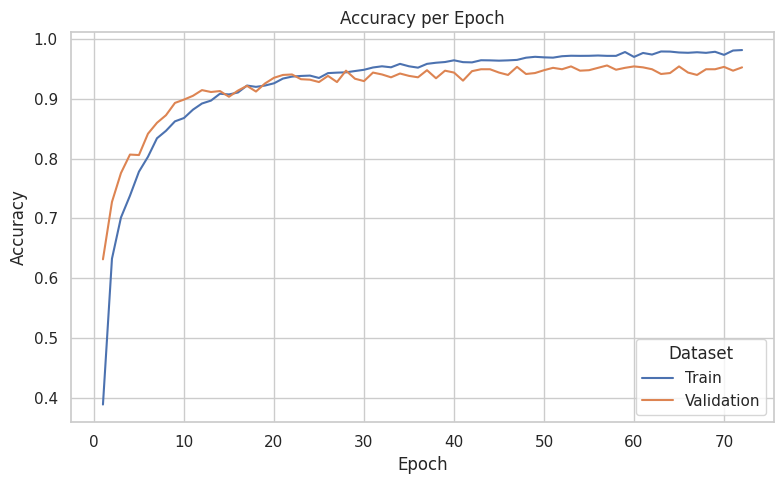

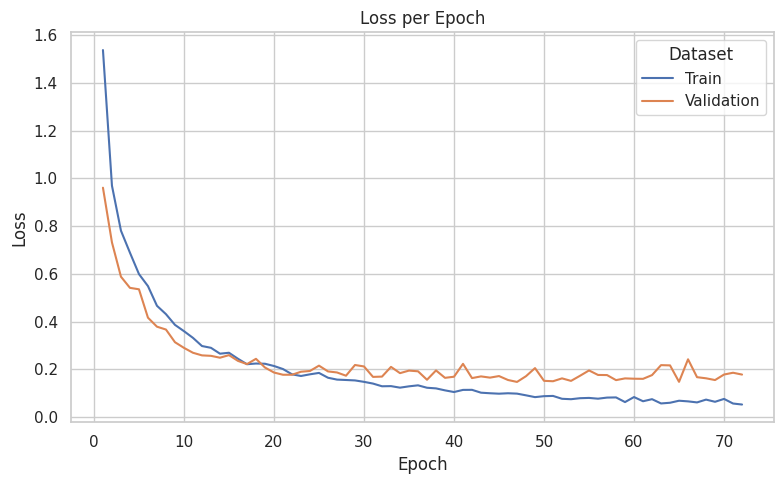

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Trains a VGG-16 from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""

import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_15ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/15ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vgg_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU detected: {gpus[0].name}")
    except RuntimeError:
        print(" GPUs already initialized; memory growth could not be configured.")
else:
    print(" GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

# build DataFrame
import pandas as pd

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
display(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL ──────────
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model = VGG16(weights=None, include_top=False,
                       input_shape=(*IMG_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


Loading model from /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5 …


Total test samples: 1262
Test set distribution:
label
AIR    200
MP1    200
MIN    199
MP2    199
INS    198
PHA    133
DIS    133
Name: count, dtype: int64 

Found 1262 validated image filenames belonging to 7 classes.
Performing predictions on test set…


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step

Classification Report:
              precision    recall  f1-score   support

         AIR     0.9727    0.8900    0.9295       200
         DIS     0.9773    0.9699    0.9736       133
         INS     0.9497    0.9545    0.9521       198
         MIN     0.9755    1.0000    0.9876       199
         MP1     0.9792    0.9400    0.9592       200
         MP2     0.9279    0.9698    0.9484       199
         PHA     0.9028    0.9774    0.9386       133

    accuracy                         0.9556      1262
   macro avg     0.9550    0.9574    0.9556      1262
weighted avg     0.9566    0.9556    0.9555      1262



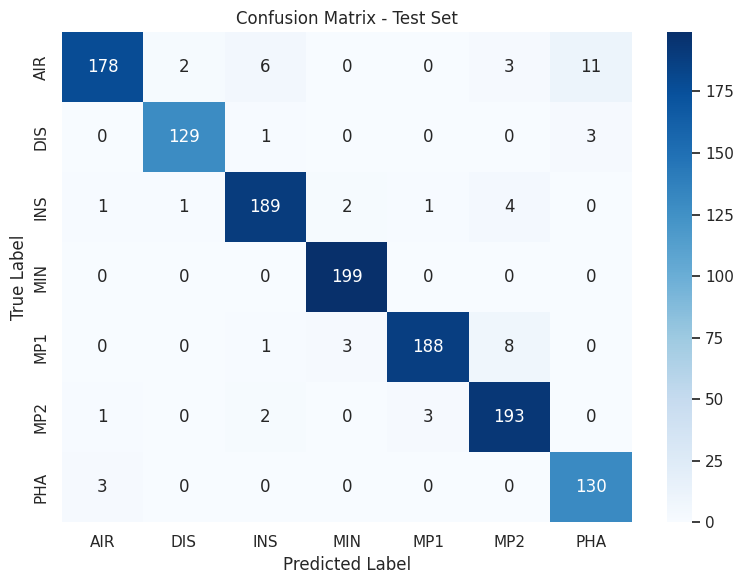

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Loads the saved "vgg_drone.h5" model, evaluates on the test split,
prints classification metrics and displays a confusion matrix using seaborn.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/15ms")
MODEL_PATH = MODEL_DIR / "vgg_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ─────────── LOAD MODEL ───────────
print(f"Loading model from {MODEL_PATH} …")
model = tf.keras.models.load_model(MODEL_PATH)

# ─────────── LOAD TEST SPLIT ───────────
test_df = pd.read_csv(TEST_CSV)
print(f"Total test samples: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts(), "\n")

# ─────────── TEST DATA GENERATOR ───────────
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    test_df,
    x_col="path", y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# ─────────── PREDICTIONS ───────────
print("Performing predictions on test set…")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes
labels = list(gen_test.class_indices.keys())

# ─────────── CLASSIFICATION REPORT ───────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# ─────────── CONFUSION MATRIX ───────────
cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# TRANSFORMER 15 ms

GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 12619
Corrupted PNGs: 0

Original distribution (post-filter):
label
AIR    1995
MP1    1995
MIN    1995
MP2    1995
INS    1979
DIS    1330
PHA    1330
Name: count, dtype: int64

Distribution after split:
Train     :
label
AIR    1596
MP1    1596
MP2    1596
MIN    1596
INS    1583
DIS    1064
PHA    1064
Name: count, dtype: int64
Validation:
label
MP2    200
MIN    200
MP1    199
AIR    199
INS    198
PHA    133
DIS    133
Name: count, dtype: int64
Test      :
label
AIR    200
MP1    200
MIN    199
MP2    199
INS    198
PHA    133
DIS    133
Name: count, dtype: int64
Found 10095 validated image filenames belonging to 7 classes.
Found 1262 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


Model: "ViT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 14, 14,    │     49,216 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_patches     │ (None, 196, 64)   │          0 │ patch_embedding[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ reshape_patches[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block0          │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block0         │ (None, 196, 64)   │     66,368 │ ln1_block0[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block0[0][0… │
│ (Add)               │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block0          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block0 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block0 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block0 │ (None, 196, 64)   │          0 │ mlp2_block0[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block1          │ (None, 196, 64)   │        128 │ residual_mlp_blo… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block1         │ (None, 196, 64)   │     66,368 │ ln1_block1[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block1[0][0… │
│ (Add)               │                   │            │ residual_mlp_blo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block1          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block1 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block1 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block1 │ (None, 196, 64)   │          0 │ mlp2_block1[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 715,399 (2.73 MB)

 Trainable params: 715,399 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.30586, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 310s - 981ms/step - accuracy: 0.1869 - loss: 2.1225 - val_accuracy: 0.3059 - val_loss: 1.7788
Epoch 2/100



Epoch 2: val_accuracy improved from 0.30586 to 0.48177, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 136s - 430ms/step - accuracy: 0.3632 - loss: 1.6041 - val_accuracy: 0.4818 - val_loss: 1.3737
Epoch 3/100



Epoch 3: val_accuracy improved from 0.48177 to 0.57211, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 428ms/step - accuracy: 0.4539 - loss: 1.3934 - val_accuracy: 0.5721 - val_loss: 1.1982
Epoch 4/100



Epoch 4: val_accuracy did not improve from 0.57211
316/316 - 134s - 426ms/step - accuracy: 0.5079 - loss: 1.2943 - val_accuracy: 0.5436 - val_loss: 1.1292
Epoch 5/100



Epoch 5: val_accuracy improved from 0.57211 to 0.60380, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 134s - 424ms/step - accuracy: 0.5470 - loss: 1.1877 - val_accuracy: 0.6038 - val_loss: 1.0788
Epoch 6/100



Epoch 6: val_accuracy improved from 0.60380 to 0.66403, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 426ms/step - accuracy: 0.5822 - loss: 1.1055 - val_accuracy: 0.6640 - val_loss: 0.9177
Epoch 7/100



Epoch 7: val_accuracy improved from 0.66403 to 0.68384, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 137s - 432ms/step - accuracy: 0.6177 - loss: 1.0181 - val_accuracy: 0.6838 - val_loss: 0.8433
Epoch 8/100



Epoch 8: val_accuracy did not improve from 0.68384
316/316 - 134s - 423ms/step - accuracy: 0.6406 - loss: 0.9582 - val_accuracy: 0.6506 - val_loss: 0.8658
Epoch 9/100



Epoch 9: val_accuracy improved from 0.68384 to 0.70602, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 143s - 452ms/step - accuracy: 0.6519 - loss: 0.9319 - val_accuracy: 0.7060 - val_loss: 0.7743
Epoch 10/100



Epoch 10: val_accuracy improved from 0.70602 to 0.71791, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 137s - 434ms/step - accuracy: 0.6696 - loss: 0.8778 - val_accuracy: 0.7179 - val_loss: 0.7374
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.71791
316/316 - 136s - 429ms/step - accuracy: 0.6828 - loss: 0.8525 - val_accuracy: 0.7179 - val_loss: 0.7042
Epoch 12/100



Epoch 12: val_accuracy improved from 0.71791 to 0.72187, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 136s - 429ms/step - accuracy: 0.7120 - loss: 0.7850 - val_accuracy: 0.7219 - val_loss: 0.7217
Epoch 13/100



Epoch 13: val_accuracy improved from 0.72187 to 0.76783, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 428ms/step - accuracy: 0.7241 - loss: 0.7403 - val_accuracy: 0.7678 - val_loss: 0.6365
Epoch 14/100



Epoch 14: val_accuracy did not improve from 0.76783
316/316 - 134s - 425ms/step - accuracy: 0.7336 - loss: 0.7250 - val_accuracy: 0.7464 - val_loss: 0.6330
Epoch 15/100



Epoch 15: val_accuracy improved from 0.76783 to 0.76862, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 428ms/step - accuracy: 0.7484 - loss: 0.6768 - val_accuracy: 0.7686 - val_loss: 0.6271
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.76862
316/316 - 133s - 421ms/step - accuracy: 0.7579 - loss: 0.6507 - val_accuracy: 0.7512 - val_loss: 0.6145
Epoch 17/100



Epoch 17: val_accuracy improved from 0.76862 to 0.77575, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 427ms/step - accuracy: 0.7748 - loss: 0.6165 - val_accuracy: 0.7758 - val_loss: 0.5711
Epoch 18/100



Epoch 18: val_accuracy improved from 0.77575 to 0.81141, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 136s - 431ms/step - accuracy: 0.7784 - loss: 0.6071 - val_accuracy: 0.8114 - val_loss: 0.5183
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.81141
316/316 - 133s - 422ms/step - accuracy: 0.7819 - loss: 0.5882 - val_accuracy: 0.8098 - val_loss: 0.5090
Epoch 20/100



Epoch 20: val_accuracy did not improve from 0.81141
316/316 - 133s - 421ms/step - accuracy: 0.7929 - loss: 0.5714 - val_accuracy: 0.7845 - val_loss: 0.5419
Epoch 21/100



Epoch 21: val_accuracy improved from 0.81141 to 0.81537, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 133s - 421ms/step - accuracy: 0.7948 - loss: 0.5672 - val_accuracy: 0.8154 - val_loss: 0.4828
Epoch 22/100



Epoch 22: val_accuracy improved from 0.81537 to 0.81616, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 426ms/step - accuracy: 0.7998 - loss: 0.5467 - val_accuracy: 0.8162 - val_loss: 0.4663
Epoch 23/100



Epoch 23: val_accuracy improved from 0.81616 to 0.82250, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 426ms/step - accuracy: 0.8055 - loss: 0.5324 - val_accuracy: 0.8225 - val_loss: 0.4487
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.82250
316/316 - 133s - 421ms/step - accuracy: 0.8118 - loss: 0.5042 - val_accuracy: 0.7853 - val_loss: 0.5026
Epoch 25/100



Epoch 25: val_accuracy improved from 0.82250 to 0.83439, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 428ms/step - accuracy: 0.8116 - loss: 0.5088 - val_accuracy: 0.8344 - val_loss: 0.4330
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.83439
316/316 - 134s - 423ms/step - accuracy: 0.8134 - loss: 0.5104 - val_accuracy: 0.8288 - val_loss: 0.4385
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.83439
316/316 - 133s - 421ms/step - accuracy: 0.8234 - loss: 0.4910 - val_accuracy: 0.7884 - val_loss: 0.5406
Epoch 28/100



Epoch 28: val_accuracy improved from 0.83439 to 0.84548, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 426ms/step - accuracy: 0.8274 - loss: 0.4746 - val_accuracy: 0.8455 - val_loss: 0.4193
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.84548
316/316 - 133s - 421ms/step - accuracy: 0.8297 - loss: 0.4645 - val_accuracy: 0.8376 - val_loss: 0.4206
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.84548
316/316 - 135s - 426ms/step - accuracy: 0.8351 - loss: 0.4486 - val_accuracy: 0.8391 - val_loss: 0.4374
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.84548
316/316 - 133s - 422ms/step - accuracy: 0.8364 - loss: 0.4466 - val_accuracy: 0.8067 - val_loss: 0.4582
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.84548
316/316 - 133s - 419ms/step - accuracy: 0.8417 - loss: 0.4347 - val_accuracy: 0.8344 - val_loss: 0.4266
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.84548
316/316 - 133s - 420ms/step - accuracy: 0.8422 - loss: 0.4324 - val_accuracy: 0.8423 - val_loss: 0.4199
Epoch 34/100



Epoch 34: val_accuracy improved from 0.84548 to 0.85182, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 134s - 424ms/step - accuracy: 0.8418 - loss: 0.4344 - val_accuracy: 0.8518 - val_loss: 0.3860
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.85182
316/316 - 131s - 415ms/step - accuracy: 0.8448 - loss: 0.4231 - val_accuracy: 0.8423 - val_loss: 0.4063
Epoch 36/100



Epoch 36: val_accuracy improved from 0.85182 to 0.86212, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 132s - 419ms/step - accuracy: 0.8494 - loss: 0.4136 - val_accuracy: 0.8621 - val_loss: 0.3962
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.86212
316/316 - 132s - 417ms/step - accuracy: 0.8490 - loss: 0.4050 - val_accuracy: 0.8415 - val_loss: 0.4057
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.86212
316/316 - 131s - 415ms/step - accuracy: 0.8532 - loss: 0.4006 - val_accuracy: 0.8225 - val_loss: 0.4882
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.86212
316/316 - 133s - 422ms/step - accuracy: 0.8558 - loss: 0.3987 - val_accuracy: 0.8407 - val_loss: 0.4184
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.86212
316/316 - 134s - 425ms/step - accuracy: 0.8538 - loss: 0.3994 - val_accuracy: 0.8558 - val_loss: 0.3580
Epoch 41/100



Epoch 41: val_accuracy improved from 0.86212 to 0.87005, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 136s - 430ms/step - accuracy: 0.8621 - loss: 0.3751 - val_accuracy: 0.8700 - val_loss: 0.3579
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.87005
316/316 - 134s - 424ms/step - accuracy: 0.8587 - loss: 0.3812 - val_accuracy: 0.8637 - val_loss: 0.3517
Epoch 43/100



Epoch 43: val_accuracy improved from 0.87005 to 0.88035, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 429ms/step - accuracy: 0.8586 - loss: 0.3783 - val_accuracy: 0.8803 - val_loss: 0.3365
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.88035
316/316 - 134s - 424ms/step - accuracy: 0.8606 - loss: 0.3800 - val_accuracy: 0.8558 - val_loss: 0.3819
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.88035
316/316 - 133s - 422ms/step - accuracy: 0.8621 - loss: 0.3694 - val_accuracy: 0.8574 - val_loss: 0.3591
Epoch 46/100



Epoch 46: val_accuracy improved from 0.88035 to 0.88590, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 428ms/step - accuracy: 0.8673 - loss: 0.3580 - val_accuracy: 0.8859 - val_loss: 0.3252
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.88590
316/316 - 133s - 422ms/step - accuracy: 0.8667 - loss: 0.3583 - val_accuracy: 0.8700 - val_loss: 0.3293
Epoch 48/100



Epoch 48: val_accuracy improved from 0.88590 to 0.89144, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 427ms/step - accuracy: 0.8687 - loss: 0.3460 - val_accuracy: 0.8914 - val_loss: 0.3030
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.89144
316/316 - 133s - 421ms/step - accuracy: 0.8708 - loss: 0.3465 - val_accuracy: 0.8796 - val_loss: 0.3484
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.89144
316/316 - 133s - 420ms/step - accuracy: 0.8694 - loss: 0.3456 - val_accuracy: 0.8875 - val_loss: 0.3190
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.89144
316/316 - 132s - 417ms/step - accuracy: 0.8737 - loss: 0.3372 - val_accuracy: 0.8851 - val_loss: 0.3138
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.89144
316/316 - 131s - 416ms/step - accuracy: 0.8654 - loss: 0.3470 - val_accuracy: 0.8756 - val_loss: 0.3429
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.89144
316/316 - 132s - 417ms/step - accuracy: 0.8740 - loss: 0.3290 - val_accuracy: 0.8772 - val_loss: 0.3049
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.89144
316/316 - 131s - 414ms/step - accuracy: 0.8745 - loss: 0.3310 - val_accuracy: 0.8883 - val_loss: 0.2878
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.89144
316/316 - 131s - 416ms/step - accuracy: 0.8760 - loss: 0.3352 - val_accuracy: 0.8843 - val_loss: 0.3122
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.89144
316/316 - 130s - 412ms/step - accuracy: 0.8789 - loss: 0.3216 - val_accuracy: 0.8859 - val_loss: 0.3157
Epoch 57/100



Epoch 57: val_accuracy improved from 0.89144 to 0.89461, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 132s - 418ms/step - accuracy: 0.8801 - loss: 0.3270 - val_accuracy: 0.8946 - val_loss: 0.3174
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.89461
316/316 - 132s - 418ms/step - accuracy: 0.8772 - loss: 0.3173 - val_accuracy: 0.8930 - val_loss: 0.2864
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.89461
316/316 - 133s - 420ms/step - accuracy: 0.8819 - loss: 0.3181 - val_accuracy: 0.8827 - val_loss: 0.2966
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.89461
316/316 - 129s - 410ms/step - accuracy: 0.8817 - loss: 0.3158 - val_accuracy: 0.8859 - val_loss: 0.2973
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.89461
316/316 - 129s - 409ms/step - accuracy: 0.8847 - loss: 0.3097 - val_accuracy: 0.8851 - val_loss: 0.2886
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.89461
316/316 - 130s - 412ms/step - accuracy: 0.8859 - loss: 0.3068 - val_accuracy: 0.8811 - val_loss: 0.3103
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.89461
316/316 - 129s - 409ms/step - accuracy: 0.8866 - loss: 0.3034 - val_accuracy: 0.8891 - val_loss: 0.2720
Epoch 64/100



Epoch 64: val_accuracy improved from 0.89461 to 0.89699, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 131s - 415ms/step - accuracy: 0.8848 - loss: 0.3081 - val_accuracy: 0.8970 - val_loss: 0.2810
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.89699
316/316 - 128s - 405ms/step - accuracy: 0.8899 - loss: 0.2928 - val_accuracy: 0.8859 - val_loss: 0.3133
Epoch 66/100



Epoch 66: val_accuracy improved from 0.89699 to 0.90808, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 129s - 410ms/step - accuracy: 0.8878 - loss: 0.3039 - val_accuracy: 0.9081 - val_loss: 0.2545
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.90808
316/316 - 128s - 404ms/step - accuracy: 0.8923 - loss: 0.2821 - val_accuracy: 0.9002 - val_loss: 0.2729
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.90808
316/316 - 127s - 402ms/step - accuracy: 0.8873 - loss: 0.3017 - val_accuracy: 0.8930 - val_loss: 0.2982
Epoch 69/100



Epoch 69: val_accuracy did not improve from 0.90808
316/316 - 131s - 415ms/step - accuracy: 0.8967 - loss: 0.2825 - val_accuracy: 0.9010 - val_loss: 0.2874
Epoch 70/100



Epoch 70: val_accuracy improved from 0.90808 to 0.91204, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 133s - 421ms/step - accuracy: 0.8908 - loss: 0.2905 - val_accuracy: 0.9120 - val_loss: 0.2303
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.91204
316/316 - 131s - 414ms/step - accuracy: 0.8971 - loss: 0.2745 - val_accuracy: 0.9010 - val_loss: 0.2731
Epoch 72/100



Epoch 72: val_accuracy did not improve from 0.91204
316/316 - 132s - 417ms/step - accuracy: 0.8928 - loss: 0.2854 - val_accuracy: 0.8954 - val_loss: 0.2785
Epoch 73/100



Epoch 73: val_accuracy did not improve from 0.91204
316/316 - 131s - 416ms/step - accuracy: 0.8969 - loss: 0.2774 - val_accuracy: 0.8922 - val_loss: 0.3437
Epoch 74/100



Epoch 74: val_accuracy did not improve from 0.91204
316/316 - 133s - 420ms/step - accuracy: 0.8930 - loss: 0.2883 - val_accuracy: 0.8930 - val_loss: 0.2861
Epoch 75/100



Epoch 75: val_accuracy did not improve from 0.91204
316/316 - 133s - 421ms/step - accuracy: 0.9009 - loss: 0.2678 - val_accuracy: 0.8970 - val_loss: 0.2733
Epoch 76/100



Epoch 76: val_accuracy did not improve from 0.91204
316/316 - 133s - 420ms/step - accuracy: 0.8990 - loss: 0.2756 - val_accuracy: 0.8954 - val_loss: 0.2959
Epoch 77/100



Epoch 77: val_accuracy did not improve from 0.91204
316/316 - 134s - 424ms/step - accuracy: 0.8965 - loss: 0.2745 - val_accuracy: 0.9010 - val_loss: 0.2675
Epoch 78/100



Epoch 78: val_accuracy did not improve from 0.91204
316/316 - 133s - 421ms/step - accuracy: 0.9015 - loss: 0.2646 - val_accuracy: 0.9065 - val_loss: 0.2383
Epoch 79/100



Epoch 79: val_accuracy improved from 0.91204 to 0.92235, saving model to /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5


316/316 - 135s - 428ms/step - accuracy: 0.9019 - loss: 0.2617 - val_accuracy: 0.9223 - val_loss: 0.2188
Epoch 80/100



Epoch 80: val_accuracy did not improve from 0.92235
316/316 - 133s - 421ms/step - accuracy: 0.9026 - loss: 0.2619 - val_accuracy: 0.8978 - val_loss: 0.2715
Epoch 81/100



Epoch 81: val_accuracy did not improve from 0.92235
316/316 - 134s - 423ms/step - accuracy: 0.8972 - loss: 0.2712 - val_accuracy: 0.9049 - val_loss: 0.2583
Epoch 82/100



Epoch 82: val_accuracy did not improve from 0.92235
316/316 - 134s - 423ms/step - accuracy: 0.9044 - loss: 0.2589 - val_accuracy: 0.9089 - val_loss: 0.2400
Epoch 83/100



Epoch 83: val_accuracy did not improve from 0.92235
316/316 - 135s - 427ms/step - accuracy: 0.9048 - loss: 0.2579 - val_accuracy: 0.8788 - val_loss: 0.3185
Epoch 84/100



Epoch 84: val_accuracy did not improve from 0.92235
316/316 - 134s - 424ms/step - accuracy: 0.9019 - loss: 0.2593 - val_accuracy: 0.8851 - val_loss: 0.2946
Epoch 85/100



Epoch 85: val_accuracy did not improve from 0.92235
316/316 - 134s - 425ms/step - accuracy: 0.9035 - loss: 0.2639 - val_accuracy: 0.8899 - val_loss: 0.2787
Epoch 86/100



Epoch 86: val_accuracy did not improve from 0.92235
316/316 - 134s - 425ms/step - accuracy: 0.9084 - loss: 0.2523 - val_accuracy: 0.9017 - val_loss: 0.2624
Epoch 87/100



Epoch 87: val_accuracy did not improve from 0.92235
316/316 - 133s - 422ms/step - accuracy: 0.9103 - loss: 0.2408 - val_accuracy: 0.9120 - val_loss: 0.2351
Epoch 88/100



Epoch 88: val_accuracy did not improve from 0.92235
316/316 - 134s - 425ms/step - accuracy: 0.9130 - loss: 0.2446 - val_accuracy: 0.9097 - val_loss: 0.2319
Epoch 89/100



Epoch 89: val_accuracy did not improve from 0.92235
316/316 - 134s - 424ms/step - accuracy: 0.9086 - loss: 0.2474 - val_accuracy: 0.8914 - val_loss: 0.2811
Epoch 90/100



Epoch 90: val_accuracy did not improve from 0.92235
316/316 - 133s - 420ms/step - accuracy: 0.9143 - loss: 0.2327 - val_accuracy: 0.8534 - val_loss: 0.4071
Epoch 91/100



Epoch 91: val_accuracy did not improve from 0.92235
316/316 - 133s - 422ms/step - accuracy: 0.9091 - loss: 0.2464 - val_accuracy: 0.9152 - val_loss: 0.2364
Epoch 92/100



Epoch 92: val_accuracy did not improve from 0.92235
316/316 - 135s - 426ms/step - accuracy: 0.9119 - loss: 0.2377 - val_accuracy: 0.9097 - val_loss: 0.2537
Epoch 93/100



Epoch 93: val_accuracy did not improve from 0.92235
316/316 - 133s - 422ms/step - accuracy: 0.9181 - loss: 0.2202 - val_accuracy: 0.9144 - val_loss: 0.2329
Epoch 94/100



Epoch 94: val_accuracy did not improve from 0.92235
316/316 - 133s - 419ms/step - accuracy: 0.9127 - loss: 0.2391 - val_accuracy: 0.9152 - val_loss: 0.2218
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 79.


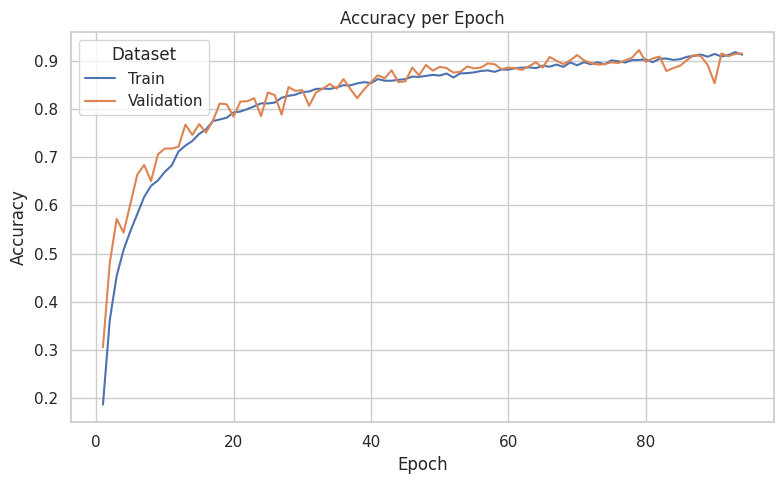

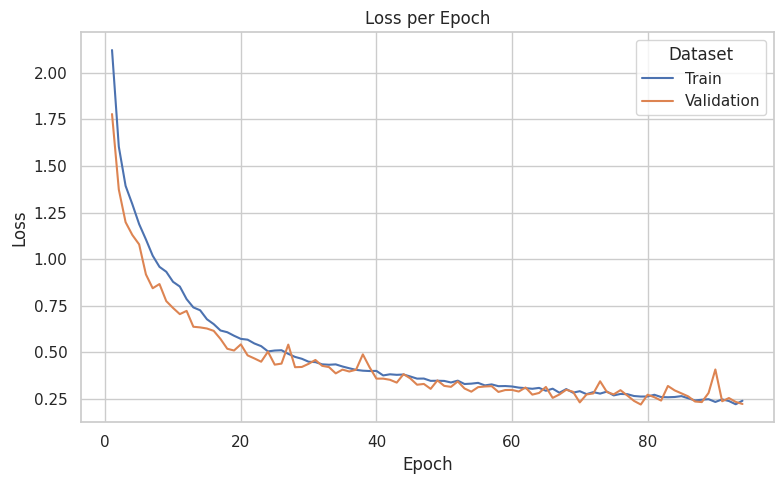

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vit_drone.py
────────────────────────────────────────────────────────────────────────
Trains a Vision Transformer from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────


ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_15ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_15ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vit_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0].name}")
    except RuntimeError:
        print("GPUs already initialized; memory growth could not be configured.")
else:
    print("GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
print(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL (USING VISION TRANSFORMER) ──────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128, transformer_layers=8,
                          dropout=0.5):
    """
    Basic Vision Transformer:
    - Extract patches via Conv2D
    - Project patches into embeddings
    - Add positional embeddings
    - Stack transformer blocks (MHSA + MLP)
    - Pool and classification head
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim), name='reshape_patches')(x)

    # 2) Positional embedding
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=n_patches,
                                     output_dim=embed_dim,
                                     name='pos_embedding')(positions)
    x = x + pos_embedding

    # 3) Transformer blocks
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln1_block{i}')(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                         key_dim=embed_dim,
                                         name=f'mhsa_block{i}')(x1, x1)
        x2 = layers.Add(name=f'residual_attn_block{i}')([attn, x])

        x3 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln2_block{i}')(x2)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(x3)
        mlp = layers.Dense(embed_dim,
                           name=f'mlp2_block{i}')(mlp)
        x = layers.Add(name=f'residual_mlp_block{i}')([mlp, x2])

    # 4) Pooling + classifier head
    x = layers.LayerNormalization(epsilon=1e-6,
                                   name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='ViT_Classifier')

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=num_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")
history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()



► Attempting to load model from /content/drive/MyDrive/DroneDetect_ViT_15ms/vit_drone.h5 …
⚠ Could not load full model (too many positional arguments). Rebuilding architecture …
✔ Weights loaded with model.load_weights().

Total test samples: 1262
Test-set class distribution:
 label
AIR    200
MP1    200
MIN    199
MP2    199
INS    198
PHA    133
DIS    133
Name: count, dtype: int64 

Found 1262 validated image filenames belonging to 7 classes.
► Generating predictions …


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         AIR     0.9091    0.8000    0.8511       200
         DIS     0.9847    0.9699    0.9773       133
         INS     0.8673    0.8586    0.8629       198
         MIN     0.9900    1.0000    0.9950       199
         MP1     0.8462    0.9350    0.8884       200
         MP2     0.7865    0.7588    0.7724       199
         PHA     0.8966    0.9774    0.9353       133

    accuracy                         0.8922      1262
   macro avg     0.8972    0.9000    0.8975      1262
weighted avg     0.8926    0.8922    0.8913      1262



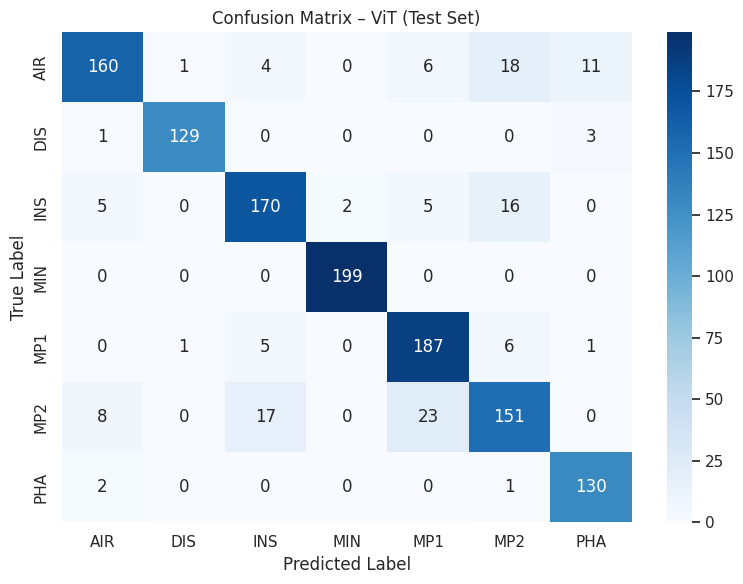

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vit_drone.py
────────────────────────────────────────────────────────────────────────
Evaluates the Vision Transformer (ViT) trained to classify drone types.

Workflow
╰─►  1) Attempts to load the full .h5 model; if that fails, rebuilds the
        architecture and loads only the weights.
     2) Generates predictions on the test split stored in test_split.csv.
     3) Prints a classification report and displays a confusion matrix
        with English titles and axis labels.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_15ms")
MODEL_PATH = MODEL_DIR / "vit_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"



IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 1) Function to rebuild the same ViT architecture used during training
# ──────────────────────────────────────────────────────────────────────────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128,
                          transformer_layers=8, dropout=0.5):
    """Minimal Vision Transformer classifier."""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim),
                       name='reshape_patches')(x)

    # Learnable positional embeddings
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_emb   = layers.Embedding(input_dim=n_patches,
                                 output_dim=embed_dim,
                                 name='pos_embedding')(positions)
    x = x + pos_emb

    # Transformer encoder blocks
    for i in range(transformer_layers):
        # Multi-head self-attention
        ln1 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln1_block{i}')(x)
        att = layers.MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim,
                                        name=f'mhsa_block{i}')(ln1, ln1)
        x   = layers.Add(name=f'residual_attn_block{i}')([att, x])

        # Feed-forward MLP
        ln2 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln2_block{i}')(x)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(ln2)
        mlp = layers.Dense(embed_dim, name=f'mlp2_block{i}')(mlp)
        x   = layers.Add(name=f'residual_mlp_block{i}')([mlp, x])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6, name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs, outputs, name='ViT_Classifier')

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load the trained model (full model or just weights)
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n► Attempting to load model from {MODEL_PATH} …")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✔ Model loaded successfully with tf.keras.models.load_model().")
except Exception as e:
    print(f"⚠ Could not load full model ({e}). Rebuilding architecture …")
    # Read test CSV to infer the number of classes
    tmp_df     = pd.read_csv(TEST_CSV)
    class_list = sorted(tmp_df["label"].unique())
    n_classes  = len(class_list)

    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=n_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.load_weights(MODEL_PATH)
    print("✔ Weights loaded with model.load_weights().")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Prepare the test data generator
# ──────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv(TEST_CSV)
print(f"\nTotal test samples: {len(test_df)}")
print("Test-set class distribution:\n", test_df["label"].value_counts(), "\n")

datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)
label_names = list(gen_test.class_indices.keys())

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluation
# ──────────────────────────────────────────────────────────────────────────────
print("► Generating predictions …")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix – ViT (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# VGG 10 ms


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gera_espectrogramas_dronedetect.py
──────────────────────────────────
Gera 1 espectrograma STFT (224×224) por segmento de 10 ms ao longo
de TODO o arquivo .dat do DroneDetect-V2, salvando em PNG ou NumPy.

Retomável via checkpoint_MOD.pickle (set, drone, arquivo).

Estrutura esperada:
<ROOT_DIR>/<interference>/<drone>/<arquivo>.dat
Ex.: .../CLEAN/AIR_FY/AIR_0010_00.dat
"""
from __future__ import annotations

import os
import re
import pickle
import shutil
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm.auto import tqdm

# ─────────────────── CONFIGURAÇÕES ────────────────────
ROOT_DIR: str = (
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2"
)

# ======= bloco “Specifications” =========
n_per_seg: int            = 1024          # STFT: pontos por segmento
n_overlap_spec: int       = 120           # STFT: overlap
psd_win_type: str         = "hamming"     # janela ('hamming', 'hann', ...)
t_seg_ms: int             = 10            # duração de cada segmento (ms)
hop_ms: int               = 10            # passo entre segmentos (ms)
feature_to_save: List[str]= ['SPEC']      # ['SPEC','PSD','RAW']
format_to_save: List[str] = ['IMG']       # ['IMG','ARR'] ou ambas
interference_folders       = ['CLEAN']     # ['WIFI','BLUE','BOTH','CLEAN']
to_add: bool              = True          # False = recriar pasta de saída
# =======================================

FS: int        = 60_000_000               # taxa de amostragem (Hz)
DIM_PX         = (224, 224)               # tamanho imagem
DPI_IMG        = 100
FEATURES_ROOT  = ROOT_DIR + "_FEATURES_MOD_10ms"
CHK_FILE       = Path(FEATURES_ROOT) / "checkpoint_MOD_10ms.pickle"
WINDOW         = get_window(psd_win_type, n_per_seg)

# Conversão ms → amostras
SAMP_SEG: int  = int(t_seg_ms / 1e3 * FS)  # 10 ms → 600000 amostras
SAMP_HOP: int  = int(hop_ms  / 1e3 * FS)   # 10 ms → 600000 amostras
assert SAMP_HOP > 0 and SAMP_SEG >= SAMP_HOP, "hop_ms deve ser >0 e ≤ t_seg_ms"

# ────────────────── UTILITÁRIAS ──────────────────
def load_iq(path: Path) -> np.ndarray:
    """Lê .dat (float32 intercalado) → complex64 normalizado (z-score)."""
    raw = np.fromfile(path, dtype=np.float32)
    iq  = raw.view(np.complex64)
    return (iq - iq.mean()) / (np.sqrt(iq.var() + 1e-10))

def calc_specgram(x: np.ndarray) -> np.ndarray:
    """Espectrograma (magnitude dB) mantendo apenas frequências ≥ 0."""
    _, _, Z = stft(
        x, fs=FS,
        nperseg=n_per_seg,
        noverlap=n_overlap_spec,
        window=WINDOW,
        return_onesided=False
    )
    spec = 20 * np.log10(np.abs(Z) + 1e-10)
    return spec[: spec.shape[0] // 2, :]   # corta a metade negativa

def save_png(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    plt.figure(
        figsize=(DIM_PX[0]/DPI_IMG, DIM_PX[1]/DPI_IMG),
        dpi=DPI_IMG
    )
    plt.axis('off')
    plt.imshow(arr, origin='lower', aspect='auto', cmap='inferno')
    plt.savefig(
        folder / f"{name}.png",
        dpi=DPI_IMG,
        bbox_inches='tight',
        pad_inches=0
    )
    plt.close()

def save_npy(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    np.save(folder / f"{name}.npy", arr.astype(np.float32))

def load_ckpt() -> Dict[str, int]:
    if CHK_FILE.exists():
        return pickle.loads(CHK_FILE.read_bytes())
    return {"set_i": 0, "drone_i": 0, "file_i": 0}

def save_ckpt(state: Dict[str, int]):
    CHK_FILE.parent.mkdir(parents=True, exist_ok=True)
    CHK_FILE.write_bytes(pickle.dumps(state))

# ───────────────────── MAIN ──────────────────────
def main():
    # Prepara pasta de saída
    if not to_add and Path(FEATURES_ROOT).exists():
        shutil.rmtree(FEATURES_ROOT)
    Path(FEATURES_ROOT).mkdir(exist_ok=True)

    ckpt = load_ckpt()

    for set_i, interf in enumerate(interference_folders[ckpt["set_i"]:], start=ckpt["set_i"]):
        dir_set = Path(ROOT_DIR) / interf
        drone_dirs = sorted(p for p in dir_set.iterdir() if p.is_dir())

        for d_i, drone_dir in enumerate(drone_dirs[ckpt["drone_i"]:], start=ckpt["drone_i"]):
            files = sorted(f for f in drone_dir.glob("*.dat"))

            for f_i, fpath in enumerate(files[ckpt["file_i"]:], start=ckpt["file_i"]):
                # ---- nomes amigáveis ----
                m_fold = re.match(r"([^_]+)_(.+)", drone_dir.name)
                drone_name, cond_name = (
                    m_fold.groups() if m_fold else (drone_dir.name, "UNK")
                )

                m_file = re.match(r".*_(\d{4})_(\d{2})\.dat", fpath.name)
                fi_num, counter = (m_file.groups() if m_file else ("0000", "00"))

                # ---- processamento do arquivo ----
                iq = load_iq(fpath)
                n_segs = max(1, (len(iq) - SAMP_SEG) // SAMP_HOP + 1)

                for seg_idx in range(n_segs):
                    start = seg_idx * SAMP_HOP
                    end   = start + SAMP_SEG
                    if end > len(iq):
                        break
                    segment = iq[start:end]

                    if 'SPEC' in feature_to_save:
                        spec = calc_specgram(segment)

                    seg_tag = f"seg{seg_idx:03d}"
                    base = (
                        f"{interf}_{drone_name}_{cond_name}_"
                        f"{fi_num}_{counter}_{seg_tag}"
                    )

                    if 'IMG' in format_to_save and 'SPEC' in feature_to_save:
                        save_png(spec, Path(FEATURES_ROOT)/"IMG_SPEC", base)

                    if 'ARR' in format_to_save and 'SPEC' in feature_to_save:
                        save_npy(spec, Path(FEATURES_ROOT)/"ARR_SPEC", base)

                # ---- checkpoint: arquivo concluído ----
                ckpt.update({"set_i": set_i, "drone_i": d_i, "file_i": f_i+1})
                save_ckpt(ckpt)

            # terminou drone
            ckpt.update({"file_i": 0, "drone_i": d_i+1})
            save_ckpt(ckpt)

        # terminou interference set
        ckpt.update({"drone_i": 0, "set_i": set_i+1})
        save_ckpt(ckpt)

    print("  Espectrogramas gerados para todos os arquivos e segmentos.")

if __name__ == "__main__":
    main()


  Espectrogramas gerados para todos os arquivos e segmentos.


In [ ]:
import os
from collections import defaultdict

# Caminho-raiz dos espectrogramas
root_dir = ("/content/drive/MyDrive/Projeto - Classificação RF/"
            "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_10ms/IMG_SPEC")

# Inicializa contadores
total = 0
por_pasta = defaultdict(int)   # {subpasta: quantidade}

# Percorre recursivamente
for dirpath, _, files in os.walk(root_dir):
    # mantém apenas imagens; ajuste conforme necessário
    imgs = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if imgs:
        rel = os.path.relpath(dirpath, root_dir)  # subpasta relativa
        por_pasta[rel] += len(imgs)
        total += len(imgs)

# Mostra resultados
print(f"Total de imagens encontradas: {total}\n")
print("Contagem por subpasta:")
for pasta, qtd in sorted(por_pasta.items()):
    print(f"  {pasta:<40} {qtd:>6}")


Total de imagens encontradas: 18975

Contagem por subpasta:
  .                                         18975


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
conta_espectrogramas_por_drone.py
─────────────────────────────────────────────────────────────────
Percorre todos os PNG/JPG sob IMG_SPEC, extrai o tipo de drone
(padrão:  <interf>_<DRONE>_<cond>_<id>_segXXX.png)
e plota a distribuição com Plotly.

Exemplo de nome: CLEAN_AIR_FY_0010_00_seg000.png
 → tipo de drone = "AIR"
"""

import os
from collections import Counter
from pathlib import Path

import pandas as pd
import plotly.express as px

# Caminho-raiz dos espectrogramas
ROOT_DIR = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_10ms/IMG_SPEC")

# ─────────── CONTAGEM ────────────
contador = Counter()

for path in ROOT_DIR.rglob("*"):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        partes = path.stem.split("_")            # divide pelo “_”
        if len(partes) >= 3:
            drone_tipo = partes[1]               # ex.: "AIR"
            contador[drone_tipo] += 1

# converte para DataFrame (mais fácil de ordenar/plotar)
df = (pd.DataFrame({"Drone": list(contador.keys()),
                    "Quantidade": list(contador.values())})
        .sort_values("Quantidade", ascending=False))

print(f"Total de imagens: {df['Quantidade'].sum()}")
display(df)

# ─────────── GRÁFICO ─────────────
fig = px.bar(df,
             x="Drone", y="Quantidade",
             text="Quantidade",
             color="Drone",
             title="Distribuição de Espectrogramas por Tipo de Drone",
             labels=dict(Drone="Tipo de Drone", Quantidade="Nº de Imagens"))

fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(yaxis=dict(title="Quantidade"),
                  xaxis=dict(title="Tipo de Drone"),
                  uniformtext_minsize=8, uniformtext_mode="hide",
                  bargap=0.25,
                  template="plotly_white")

fig.show()


Total de imagens: 18975


Drone  Quantidade
0   AIR        3000
3   MIN        3000
4   MP1        3000
5   MP2        3000
2   INS        2975
1   DIS        2000
6   PHA        2000

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd

ROOT_IMG = Path(
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_10ms/IMG_SPEC"
)
MODEL_DIR = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

rows, bad = [], []

for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexando / validando PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()                 # detecta PNG inválido
        parts = p.stem.split("_")
        if len(parts) >= 2:
            label = parts[1]            # segundo campo → rótulo (“AIR”, …)
            rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"Imagens válidas: {len(rows)}  –  Corrompidas descartadas: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "arquivos_corrompidos.txt",
                          index=False, header=False)

df = pd.DataFrame(rows)
print("\nDistribuição original (após filtro):")
display(df["label"].value_counts())


Indexando / validando PNGs: 0it [00:00, ?it/s]

Imagens válidas: 18975  –  Corrompidas descartadas: 0

Distribuição original (após filtro):


label
AIR    3000
MIN    3000
MP1    3000
MP2    3000
INS    2975
DIS    2000
PHA    2000
Name: count, dtype: int64

 GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 18975
Corrupted PNGs: 0

Original distribution (post-filter):


label
AIR    3000
MIN    3000
MP1    3000
MP2    3000
INS    2975
DIS    2000
PHA    2000
Name: count, dtype: int64


Distribution after split:
Train     :
label
AIR    2400
MP1    2400
MP2    2400
MIN    2400
INS    2380
PHA    1600
DIS    1600
Name: count, dtype: int64
Validation:
label
MP2    300
AIR    300
MIN    300
MP1    300
INS    297
PHA    200
DIS    200
Name: count, dtype: int64
Test      :
label
MP1    300
AIR    300
MP2    300
MIN    300
INS    298
PHA    200
DIS    200
Name: count, dtype: int64
Found 15180 validated image filenames belonging to 7 classes.
Found 1897 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.28888, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 529s - 1s/step - accuracy: 0.1875 - loss: 1.9006 - val_accuracy: 0.2889 - val_loss: 1.5932
Epoch 2/100



Epoch 2: val_accuracy improved from 0.28888 to 0.66579, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 238s - 501ms/step - accuracy: 0.4957 - loss: 1.2828 - val_accuracy: 0.6658 - val_loss: 0.8319
Epoch 3/100



Epoch 3: val_accuracy improved from 0.66579 to 0.75804, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 238s - 501ms/step - accuracy: 0.6655 - loss: 0.8458 - val_accuracy: 0.7580 - val_loss: 0.5984
Epoch 4/100



Epoch 4: val_accuracy improved from 0.75804 to 0.82868, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 236s - 497ms/step - accuracy: 0.7505 - loss: 0.6615 - val_accuracy: 0.8287 - val_loss: 0.4742
Epoch 5/100



Epoch 5: val_accuracy improved from 0.82868 to 0.84396, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 239s - 504ms/step - accuracy: 0.7944 - loss: 0.5547 - val_accuracy: 0.8440 - val_loss: 0.4335
Epoch 6/100



Epoch 6: val_accuracy did not improve from 0.84396
475/475 - 235s - 495ms/step - accuracy: 0.8194 - loss: 0.4930 - val_accuracy: 0.8429 - val_loss: 0.4044
Epoch 7/100



Epoch 7: val_accuracy improved from 0.84396 to 0.87085, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 235s - 495ms/step - accuracy: 0.8420 - loss: 0.4372 - val_accuracy: 0.8708 - val_loss: 0.3542
Epoch 8/100



Epoch 8: val_accuracy improved from 0.87085 to 0.87138, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 235s - 495ms/step - accuracy: 0.8526 - loss: 0.4074 - val_accuracy: 0.8714 - val_loss: 0.3414
Epoch 9/100



Epoch 9: val_accuracy improved from 0.87138 to 0.89035, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 235s - 494ms/step - accuracy: 0.8682 - loss: 0.3692 - val_accuracy: 0.8904 - val_loss: 0.2943
Epoch 10/100



Epoch 10: val_accuracy improved from 0.89035 to 0.89352, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 238s - 502ms/step - accuracy: 0.8718 - loss: 0.3518 - val_accuracy: 0.8935 - val_loss: 0.2894
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.89352
475/475 - 236s - 497ms/step - accuracy: 0.8849 - loss: 0.3151 - val_accuracy: 0.8914 - val_loss: 0.2970
Epoch 12/100



Epoch 12: val_accuracy improved from 0.89352 to 0.91197, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 238s - 501ms/step - accuracy: 0.8907 - loss: 0.3028 - val_accuracy: 0.9120 - val_loss: 0.2513
Epoch 13/100



Epoch 13: val_accuracy improved from 0.91197 to 0.91460, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 237s - 498ms/step - accuracy: 0.8995 - loss: 0.2784 - val_accuracy: 0.9146 - val_loss: 0.2406
Epoch 14/100



Epoch 14: val_accuracy did not improve from 0.91460
475/475 - 233s - 491ms/step - accuracy: 0.9069 - loss: 0.2572 - val_accuracy: 0.8851 - val_loss: 0.2903
Epoch 15/100



Epoch 15: val_accuracy improved from 0.91460 to 0.92145, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 236s - 498ms/step - accuracy: 0.9167 - loss: 0.2307 - val_accuracy: 0.9215 - val_loss: 0.2371
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.92145
475/475 - 233s - 490ms/step - accuracy: 0.9213 - loss: 0.2225 - val_accuracy: 0.9193 - val_loss: 0.2331
Epoch 17/100



Epoch 17: val_accuracy improved from 0.92145 to 0.93200, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 237s - 498ms/step - accuracy: 0.9236 - loss: 0.2122 - val_accuracy: 0.9320 - val_loss: 0.2077
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.93200
475/475 - 231s - 486ms/step - accuracy: 0.9284 - loss: 0.2030 - val_accuracy: 0.9288 - val_loss: 0.1952
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.93200
475/475 - 232s - 489ms/step - accuracy: 0.9307 - loss: 0.1926 - val_accuracy: 0.9299 - val_loss: 0.1957
Epoch 20/100



Epoch 20: val_accuracy did not improve from 0.93200
475/475 - 232s - 488ms/step - accuracy: 0.9316 - loss: 0.1919 - val_accuracy: 0.9288 - val_loss: 0.1978
Epoch 21/100



Epoch 21: val_accuracy improved from 0.93200 to 0.93305, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 236s - 498ms/step - accuracy: 0.9366 - loss: 0.1841 - val_accuracy: 0.9331 - val_loss: 0.1826
Epoch 22/100



Epoch 22: val_accuracy improved from 0.93305 to 0.93938, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 235s - 495ms/step - accuracy: 0.9399 - loss: 0.1678 - val_accuracy: 0.9394 - val_loss: 0.1917
Epoch 23/100



Epoch 23: val_accuracy improved from 0.93938 to 0.94412, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 235s - 494ms/step - accuracy: 0.9392 - loss: 0.1697 - val_accuracy: 0.9441 - val_loss: 0.1732
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.94412
475/475 - 233s - 491ms/step - accuracy: 0.9449 - loss: 0.1529 - val_accuracy: 0.9341 - val_loss: 0.2290
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.94412
475/475 - 232s - 489ms/step - accuracy: 0.9445 - loss: 0.1587 - val_accuracy: 0.9309 - val_loss: 0.1979
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.94412
475/475 - 231s - 486ms/step - accuracy: 0.9489 - loss: 0.1446 - val_accuracy: 0.9410 - val_loss: 0.1830
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.94412
475/475 - 231s - 487ms/step - accuracy: 0.9478 - loss: 0.1443 - val_accuracy: 0.9420 - val_loss: 0.1668
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.94412
475/475 - 236s - 497ms/step - accuracy: 0.9539 - loss: 0.1330 - val_accuracy: 0.9441 - val_loss: 0.1692
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.94412
475/475 - 231s - 487ms/step - accuracy: 0.9494 - loss: 0.1401 - val_accuracy: 0.9341 - val_loss: 0.1854
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.94412
475/475 - 230s - 485ms/step - accuracy: 0.9526 - loss: 0.1283 - val_accuracy: 0.9436 - val_loss: 0.1681
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.94412
475/475 - 231s - 485ms/step - accuracy: 0.9529 - loss: 0.1316 - val_accuracy: 0.9431 - val_loss: 0.1608
Epoch 32/100



Epoch 32: val_accuracy improved from 0.94412 to 0.94834, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 235s - 496ms/step - accuracy: 0.9579 - loss: 0.1191 - val_accuracy: 0.9483 - val_loss: 0.1565
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.94834
475/475 - 235s - 495ms/step - accuracy: 0.9571 - loss: 0.1193 - val_accuracy: 0.9468 - val_loss: 0.1632
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.94834
475/475 - 234s - 492ms/step - accuracy: 0.9590 - loss: 0.1143 - val_accuracy: 0.9478 - val_loss: 0.1590
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.94834
475/475 - 231s - 486ms/step - accuracy: 0.9577 - loss: 0.1181 - val_accuracy: 0.9468 - val_loss: 0.1722
Epoch 36/100



Epoch 36: val_accuracy improved from 0.94834 to 0.95361, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 236s - 496ms/step - accuracy: 0.9596 - loss: 0.1114 - val_accuracy: 0.9536 - val_loss: 0.1470
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.95361
475/475 - 232s - 488ms/step - accuracy: 0.9607 - loss: 0.1099 - val_accuracy: 0.9420 - val_loss: 0.1800
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.95361
475/475 - 234s - 492ms/step - accuracy: 0.9609 - loss: 0.1080 - val_accuracy: 0.9468 - val_loss: 0.1592
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.95361
475/475 - 231s - 485ms/step - accuracy: 0.9619 - loss: 0.1051 - val_accuracy: 0.9494 - val_loss: 0.1430
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.95361
475/475 - 234s - 494ms/step - accuracy: 0.9614 - loss: 0.1037 - val_accuracy: 0.9510 - val_loss: 0.1529
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.95361
475/475 - 235s - 494ms/step - accuracy: 0.9657 - loss: 0.0927 - val_accuracy: 0.9494 - val_loss: 0.1561
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.95361
475/475 - 233s - 491ms/step - accuracy: 0.9660 - loss: 0.0951 - val_accuracy: 0.9489 - val_loss: 0.1534
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.95361
475/475 - 232s - 488ms/step - accuracy: 0.9621 - loss: 0.1032 - val_accuracy: 0.9315 - val_loss: 0.2266
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.95361
475/475 - 231s - 487ms/step - accuracy: 0.9665 - loss: 0.0919 - val_accuracy: 0.9483 - val_loss: 0.1638
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.95361
475/475 - 232s - 489ms/step - accuracy: 0.9676 - loss: 0.0874 - val_accuracy: 0.9473 - val_loss: 0.1602
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.95361
475/475 - 230s - 485ms/step - accuracy: 0.9677 - loss: 0.0899 - val_accuracy: 0.9515 - val_loss: 0.1296
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.95361
475/475 - 232s - 489ms/step - accuracy: 0.9698 - loss: 0.0840 - val_accuracy: 0.9473 - val_loss: 0.1432
Epoch 48/100



Epoch 48: val_accuracy improved from 0.95361 to 0.95625, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


475/475 - 233s - 490ms/step - accuracy: 0.9673 - loss: 0.0903 - val_accuracy: 0.9562 - val_loss: 0.1580
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.95625
475/475 - 230s - 484ms/step - accuracy: 0.9686 - loss: 0.0867 - val_accuracy: 0.9515 - val_loss: 0.1543
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.95625
475/475 - 229s - 482ms/step - accuracy: 0.9700 - loss: 0.0848 - val_accuracy: 0.9531 - val_loss: 0.1558
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.95625
475/475 - 233s - 491ms/step - accuracy: 0.9696 - loss: 0.0838 - val_accuracy: 0.9499 - val_loss: 0.1847
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.95625
475/475 - 234s - 493ms/step - accuracy: 0.9708 - loss: 0.0825 - val_accuracy: 0.9489 - val_loss: 0.1752
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.95625
475/475 - 234s - 492ms/step - accuracy: 0.9709 - loss: 0.0781 - val_accuracy: 0.9541 - val_loss: 0.1582
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.95625
475/475 - 233s - 490ms/step - accuracy: 0.9726 - loss: 0.0779 - val_accuracy: 0.9504 - val_loss: 0.1627
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.95625
475/475 - 232s - 489ms/step - accuracy: 0.9713 - loss: 0.0784 - val_accuracy: 0.9499 - val_loss: 0.1375
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.95625
475/475 - 232s - 488ms/step - accuracy: 0.9743 - loss: 0.0701 - val_accuracy: 0.9520 - val_loss: 0.1705
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.95625
475/475 - 233s - 491ms/step - accuracy: 0.9719 - loss: 0.0785 - val_accuracy: 0.9441 - val_loss: 0.1660
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.95625
475/475 - 233s - 491ms/step - accuracy: 0.9708 - loss: 0.0789 - val_accuracy: 0.9457 - val_loss: 0.1845
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.95625
475/475 - 233s - 491ms/step - accuracy: 0.9763 - loss: 0.0693 - val_accuracy: 0.9541 - val_loss: 0.1510
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.95625
475/475 - 234s - 493ms/step - accuracy: 0.9749 - loss: 0.0680 - val_accuracy: 0.9483 - val_loss: 0.1536
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.95625
475/475 - 233s - 490ms/step - accuracy: 0.9750 - loss: 0.0698 - val_accuracy: 0.9468 - val_loss: 0.1827
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.95625
475/475 - 235s - 495ms/step - accuracy: 0.9746 - loss: 0.0721 - val_accuracy: 0.9526 - val_loss: 0.1660
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.95625
475/475 - 231s - 486ms/step - accuracy: 0.9736 - loss: 0.0729 - val_accuracy: 0.9510 - val_loss: 0.1301
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 48.


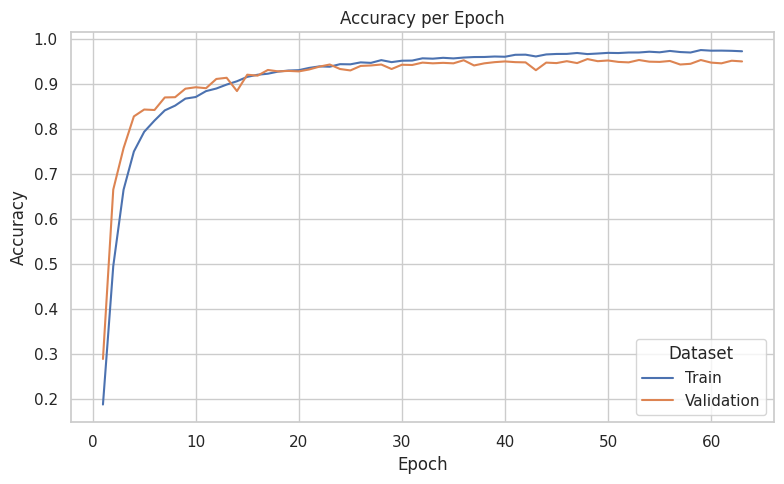

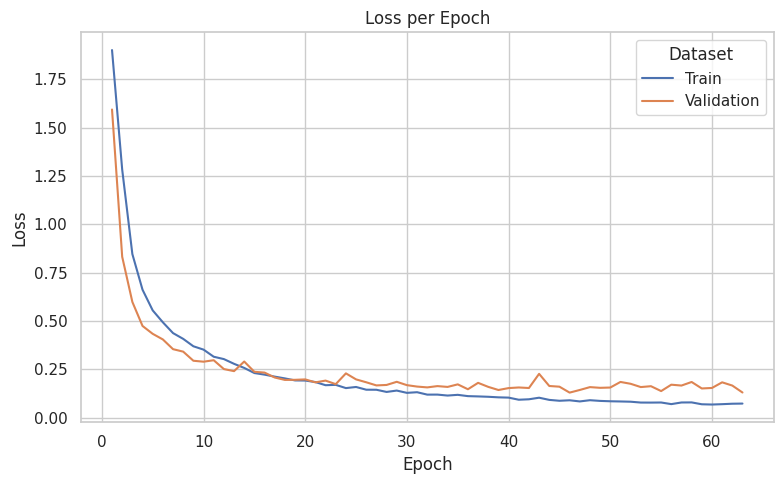

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Trains a VGG-16 from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""

import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_10ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/15ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vgg_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU detected: {gpus[0].name}")
    except RuntimeError:
        print(" GPUs already initialized; memory growth could not be configured.")
else:
    print(" GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

# build DataFrame
import pandas as pd

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
display(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL ──────────
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model = VGG16(weights=None, include_top=False,
                       input_shape=(*IMG_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


Loading model from /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5 …


Total test samples: 1898
Test set distribution:
label
MP1    300
AIR    300
MP2    300
MIN    300
INS    298
PHA    200
DIS    200
Name: count, dtype: int64 

Found 1898 validated image filenames belonging to 7 classes.
Performing predictions on test set…


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step

Classification Report:
              precision    recall  f1-score   support

         AIR     0.9329    0.9733    0.9527       300
         DIS     0.9461    0.9650    0.9554       200
         INS     0.9590    0.9430    0.9509       298
         MIN     1.0000    0.9933    0.9967       300
         MP1     0.9650    0.9200    0.9420       300
         MP2     0.9058    0.9300    0.9178       300
         PHA     0.9643    0.9450    0.9545       200

    accuracy                         0.9526      1898
   macro avg     0.9533    0.9528    0.9529      1898
weighted avg     0.9531    0.9526    0.9526      1898



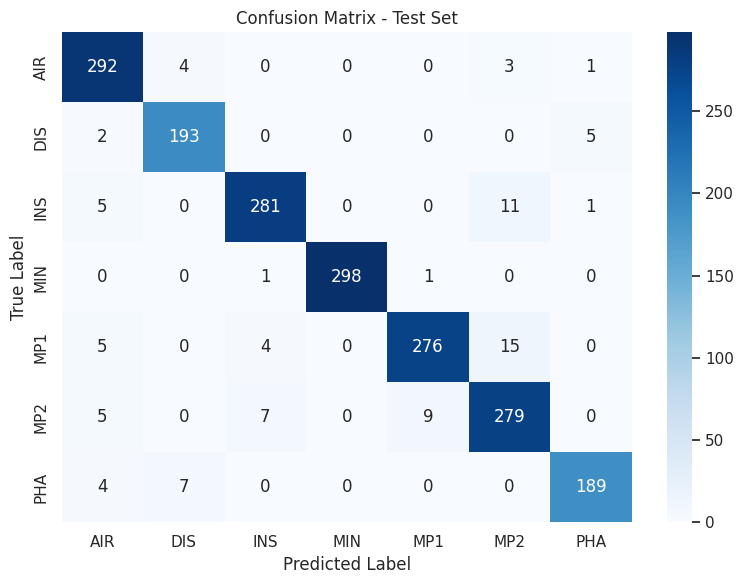

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Loads the saved "vgg_drone.h5" model, evaluates on the test split,
prints classification metrics and displays a confusion matrix using seaborn.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/15ms")
MODEL_PATH = MODEL_DIR / "vgg_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ─────────── LOAD MODEL ───────────
print(f"Loading model from {MODEL_PATH} …")
model = tf.keras.models.load_model(MODEL_PATH)

# ─────────── LOAD TEST SPLIT ───────────
test_df = pd.read_csv(TEST_CSV)
print(f"Total test samples: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts(), "\n")

# ─────────── TEST DATA GENERATOR ───────────
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    test_df,
    x_col="path", y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# ─────────── PREDICTIONS ───────────
print("Performing predictions on test set…")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes
labels = list(gen_test.class_indices.keys())

# ─────────── CLASSIFICATION REPORT ───────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# ─────────── CONFUSION MATRIX ───────────
cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# TRANSFORMER 10 ms

GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 18975
Corrupted PNGs: 0

Original distribution (post-filter):
label
AIR    3000
MIN    3000
MP1    3000
MP2    3000
INS    2975
DIS    2000
PHA    2000
Name: count, dtype: int64

Distribution after split:
Train     :
label
AIR    2400
MP1    2400
MP2    2400
MIN    2400
INS    2380
PHA    1600
DIS    1600
Name: count, dtype: int64
Validation:
label
MP2    300
AIR    300
MIN    300
MP1    300
INS    297
PHA    200
DIS    200
Name: count, dtype: int64
Test      :
label
MP1    300
AIR    300
MP2    300
MIN    300
INS    298
PHA    200
DIS    200
Name: count, dtype: int64
Found 15180 validated image filenames belonging to 7 classes.
Found 1897 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


Model: "ViT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding (Conv2D)  │ (None, 14, 14, 64)     │         49,216 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_patches (Reshape) │ (None, 196, 64)        │              0 │ patch_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 196, 64)        │              0 │ reshape_patches[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln1_block0                │ (None, 196, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mhsa_block0               │ (None, 196, 64)        │         66,368 │ ln1_block0[0][0],      │
│ (MultiHeadAttention)      │                        │                │ ln1_block0[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_attn_block0      │ (None, 196, 64)        │              0 │ mhsa_block0[0][0],     │
│ (Add)                     │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln2_block0                │ (None, 196, 64)        │            128 │ residual_attn_block0[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp1_block0 (Dense)       │ (None, 196, 128)       │          8,320 │ ln2_block0[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp2_block0 (Dense)       │ (None, 196, 64)        │          8,256 │ mlp1_block0[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_mlp_block0 (Add) │ (None, 196, 64)        │              0 │ mlp2_block0[0][0],     │
│                           │                        │                │ residual_attn_block0[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln1_block1                │ (None, 196, 64)        │            128 │ residual_mlp_block0[0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mhsa_block1               │ (None, 196, 64)        │         66,368 │ ln1_block1[0][0],      │
│ (MultiHeadAttention)      │                        │                │ ln1_block1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_attn_block1      │ (None, 196, 64)        │              0 │ mhsa_block1[0][0],     │
│ (Add)                     │                        │                │ residual_mlp_block0[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ln2_block1                │ (None, 196, 64)        │            128 │ residual_attn_block1[… │
│ (LayerNormalization) 

 Total params: 715,399 (2.73 MB)

 Trainable params: 715,399 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.40959, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 441s - 929ms/step - accuracy: 0.2304 - loss: 1.9765 - val_accuracy: 0.4096 - val_loss: 1.4691
Epoch 2/100



Epoch 2: val_accuracy improved from 0.40959 to 0.46811, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 412ms/step - accuracy: 0.3962 - loss: 1.5190 - val_accuracy: 0.4681 - val_loss: 1.3524
Epoch 3/100



Epoch 3: val_accuracy improved from 0.46811 to 0.53980, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 198s - 416ms/step - accuracy: 0.4574 - loss: 1.3847 - val_accuracy: 0.5398 - val_loss: 1.1943
Epoch 4/100



Epoch 4: val_accuracy improved from 0.53980 to 0.60464, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 197s - 415ms/step - accuracy: 0.5258 - loss: 1.2220 - val_accuracy: 0.6046 - val_loss: 1.0424
Epoch 5/100



Epoch 5: val_accuracy improved from 0.60464 to 0.62889, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 414ms/step - accuracy: 0.5767 - loss: 1.0957 - val_accuracy: 0.6289 - val_loss: 0.9602
Epoch 6/100



Epoch 6: val_accuracy improved from 0.62889 to 0.67001, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 202s - 425ms/step - accuracy: 0.6104 - loss: 1.0120 - val_accuracy: 0.6700 - val_loss: 0.8580
Epoch 7/100



Epoch 7: val_accuracy did not improve from 0.67001
475/475 - 197s - 415ms/step - accuracy: 0.6325 - loss: 0.9632 - val_accuracy: 0.6500 - val_loss: 0.9157
Epoch 8/100



Epoch 8: val_accuracy improved from 0.67001 to 0.67317, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 198s - 418ms/step - accuracy: 0.6544 - loss: 0.9108 - val_accuracy: 0.6732 - val_loss: 0.8620
Epoch 9/100



Epoch 9: val_accuracy improved from 0.67317 to 0.69531, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 200s - 421ms/step - accuracy: 0.6713 - loss: 0.8664 - val_accuracy: 0.6953 - val_loss: 0.7582
Epoch 10/100



Epoch 10: val_accuracy improved from 0.69531 to 0.71903, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 198s - 416ms/step - accuracy: 0.6808 - loss: 0.8393 - val_accuracy: 0.7190 - val_loss: 0.7117
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.71903
475/475 - 193s - 406ms/step - accuracy: 0.6943 - loss: 0.8014 - val_accuracy: 0.7174 - val_loss: 0.6992
Epoch 12/100



Epoch 12: val_accuracy improved from 0.71903 to 0.72641, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 199s - 418ms/step - accuracy: 0.7128 - loss: 0.7529 - val_accuracy: 0.7264 - val_loss: 0.6923
Epoch 13/100



Epoch 13: val_accuracy improved from 0.72641 to 0.75751, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 194s - 409ms/step - accuracy: 0.7198 - loss: 0.7371 - val_accuracy: 0.7575 - val_loss: 0.6201
Epoch 14/100



Epoch 14: val_accuracy improved from 0.75751 to 0.77385, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 193s - 407ms/step - accuracy: 0.7363 - loss: 0.6962 - val_accuracy: 0.7739 - val_loss: 0.5703
Epoch 15/100



Epoch 15: val_accuracy did not improve from 0.77385
475/475 - 190s - 400ms/step - accuracy: 0.7487 - loss: 0.6668 - val_accuracy: 0.7559 - val_loss: 0.6229
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.77385
475/475 - 191s - 403ms/step - accuracy: 0.7576 - loss: 0.6412 - val_accuracy: 0.7501 - val_loss: 0.6224
Epoch 17/100



Epoch 17: val_accuracy improved from 0.77385 to 0.78334, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 200s - 422ms/step - accuracy: 0.7622 - loss: 0.6211 - val_accuracy: 0.7833 - val_loss: 0.5545
Epoch 18/100



Epoch 18: val_accuracy improved from 0.78334 to 0.79652, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 414ms/step - accuracy: 0.7758 - loss: 0.5951 - val_accuracy: 0.7965 - val_loss: 0.5253
Epoch 19/100



Epoch 19: val_accuracy improved from 0.79652 to 0.80496, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 195s - 410ms/step - accuracy: 0.7756 - loss: 0.5911 - val_accuracy: 0.8050 - val_loss: 0.5101
Epoch 20/100



Epoch 20: val_accuracy did not improve from 0.80496
475/475 - 194s - 408ms/step - accuracy: 0.7891 - loss: 0.5643 - val_accuracy: 0.7981 - val_loss: 0.4902
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.80496
475/475 - 198s - 416ms/step - accuracy: 0.7885 - loss: 0.5629 - val_accuracy: 0.8023 - val_loss: 0.5143
Epoch 22/100



Epoch 22: val_accuracy improved from 0.80496 to 0.80917, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 412ms/step - accuracy: 0.7941 - loss: 0.5452 - val_accuracy: 0.8092 - val_loss: 0.4754
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.80917
475/475 - 194s - 408ms/step - accuracy: 0.7914 - loss: 0.5414 - val_accuracy: 0.7923 - val_loss: 0.5095
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.80917
475/475 - 193s - 407ms/step - accuracy: 0.8005 - loss: 0.5258 - val_accuracy: 0.7934 - val_loss: 0.5167
Epoch 25/100



Epoch 25: val_accuracy improved from 0.80917 to 0.81339, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 413ms/step - accuracy: 0.8003 - loss: 0.5338 - val_accuracy: 0.8134 - val_loss: 0.4999
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.81339
475/475 - 193s - 407ms/step - accuracy: 0.8014 - loss: 0.5292 - val_accuracy: 0.7886 - val_loss: 0.5484
Epoch 27/100



Epoch 27: val_accuracy improved from 0.81339 to 0.82762, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 194s - 409ms/step - accuracy: 0.8086 - loss: 0.5062 - val_accuracy: 0.8276 - val_loss: 0.4289
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.82762
475/475 - 195s - 411ms/step - accuracy: 0.8070 - loss: 0.5050 - val_accuracy: 0.8181 - val_loss: 0.4476
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.82762
475/475 - 198s - 416ms/step - accuracy: 0.8125 - loss: 0.4906 - val_accuracy: 0.8187 - val_loss: 0.4632
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.82762
475/475 - 194s - 408ms/step - accuracy: 0.8181 - loss: 0.4800 - val_accuracy: 0.8250 - val_loss: 0.4398
Epoch 31/100



Epoch 31: val_accuracy improved from 0.82762 to 0.83342, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 200s - 420ms/step - accuracy: 0.8186 - loss: 0.4731 - val_accuracy: 0.8334 - val_loss: 0.4036
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.83342
475/475 - 195s - 411ms/step - accuracy: 0.8199 - loss: 0.4643 - val_accuracy: 0.8260 - val_loss: 0.4236
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.83342
475/475 - 193s - 406ms/step - accuracy: 0.8271 - loss: 0.4534 - val_accuracy: 0.8303 - val_loss: 0.4143
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.83342
475/475 - 192s - 403ms/step - accuracy: 0.8262 - loss: 0.4459 - val_accuracy: 0.8171 - val_loss: 0.4516
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.83342
475/475 - 191s - 401ms/step - accuracy: 0.8296 - loss: 0.4411 - val_accuracy: 0.8155 - val_loss: 0.4492
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.83342
475/475 - 196s - 412ms/step - accuracy: 0.8314 - loss: 0.4431 - val_accuracy: 0.8260 - val_loss: 0.4283
Epoch 37/100



Epoch 37: val_accuracy improved from 0.83342 to 0.84976, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 197s - 415ms/step - accuracy: 0.8345 - loss: 0.4272 - val_accuracy: 0.8498 - val_loss: 0.3877
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.84976
475/475 - 194s - 408ms/step - accuracy: 0.8365 - loss: 0.4235 - val_accuracy: 0.8492 - val_loss: 0.3817
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.84976
475/475 - 193s - 406ms/step - accuracy: 0.8372 - loss: 0.4174 - val_accuracy: 0.8445 - val_loss: 0.3948
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.84976
475/475 - 197s - 415ms/step - accuracy: 0.8437 - loss: 0.4111 - val_accuracy: 0.8450 - val_loss: 0.4118
Epoch 41/100



Epoch 41: val_accuracy improved from 0.84976 to 0.85978, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 195s - 411ms/step - accuracy: 0.8447 - loss: 0.4054 - val_accuracy: 0.8598 - val_loss: 0.3666
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.85978
475/475 - 195s - 410ms/step - accuracy: 0.8445 - loss: 0.3930 - val_accuracy: 0.8350 - val_loss: 0.4090
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.85978
475/475 - 198s - 417ms/step - accuracy: 0.8488 - loss: 0.3935 - val_accuracy: 0.8487 - val_loss: 0.3841
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.85978
475/475 - 196s - 414ms/step - accuracy: 0.8462 - loss: 0.3979 - val_accuracy: 0.8329 - val_loss: 0.4223
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.85978
475/475 - 197s - 415ms/step - accuracy: 0.8533 - loss: 0.3866 - val_accuracy: 0.8598 - val_loss: 0.3706
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.85978
475/475 - 198s - 418ms/step - accuracy: 0.8577 - loss: 0.3710 - val_accuracy: 0.8477 - val_loss: 0.3805
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.85978
475/475 - 198s - 417ms/step - accuracy: 0.8563 - loss: 0.3738 - val_accuracy: 0.8492 - val_loss: 0.3826
Epoch 48/100



Epoch 48: val_accuracy improved from 0.85978 to 0.86452, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 413ms/step - accuracy: 0.8559 - loss: 0.3735 - val_accuracy: 0.8645 - val_loss: 0.3457
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.86452
475/475 - 200s - 421ms/step - accuracy: 0.8594 - loss: 0.3657 - val_accuracy: 0.8513 - val_loss: 0.3620
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.86452
475/475 - 200s - 421ms/step - accuracy: 0.8573 - loss: 0.3670 - val_accuracy: 0.8550 - val_loss: 0.3625
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.86452
475/475 - 198s - 416ms/step - accuracy: 0.8597 - loss: 0.3647 - val_accuracy: 0.8513 - val_loss: 0.3840
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.86452
475/475 - 199s - 420ms/step - accuracy: 0.8614 - loss: 0.3611 - val_accuracy: 0.8535 - val_loss: 0.3727
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.86452
475/475 - 198s - 416ms/step - accuracy: 0.8674 - loss: 0.3530 - val_accuracy: 0.8629 - val_loss: 0.3445
Epoch 54/100



Epoch 54: val_accuracy improved from 0.86452 to 0.87454, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 199s - 419ms/step - accuracy: 0.8638 - loss: 0.3521 - val_accuracy: 0.8745 - val_loss: 0.3385
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.87454
475/475 - 201s - 424ms/step - accuracy: 0.8682 - loss: 0.3418 - val_accuracy: 0.8714 - val_loss: 0.3218
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.87454
475/475 - 202s - 425ms/step - accuracy: 0.8663 - loss: 0.3482 - val_accuracy: 0.8603 - val_loss: 0.3663
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.87454
475/475 - 201s - 424ms/step - accuracy: 0.8691 - loss: 0.3404 - val_accuracy: 0.8635 - val_loss: 0.3496
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.87454
475/475 - 196s - 412ms/step - accuracy: 0.8697 - loss: 0.3366 - val_accuracy: 0.8687 - val_loss: 0.3243
Epoch 59/100



Epoch 59: val_accuracy improved from 0.87454 to 0.87507, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 195s - 410ms/step - accuracy: 0.8725 - loss: 0.3365 - val_accuracy: 0.8751 - val_loss: 0.3109
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.87507
475/475 - 195s - 410ms/step - accuracy: 0.8674 - loss: 0.3434 - val_accuracy: 0.8745 - val_loss: 0.3144
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.87507
475/475 - 200s - 422ms/step - accuracy: 0.8752 - loss: 0.3330 - val_accuracy: 0.8529 - val_loss: 0.3630
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.87507
475/475 - 196s - 412ms/step - accuracy: 0.8753 - loss: 0.3263 - val_accuracy: 0.8677 - val_loss: 0.3371
Epoch 63/100



Epoch 63: val_accuracy improved from 0.87507 to 0.89404, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 199s - 418ms/step - accuracy: 0.8763 - loss: 0.3229 - val_accuracy: 0.8940 - val_loss: 0.2917
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.89404
475/475 - 198s - 417ms/step - accuracy: 0.8789 - loss: 0.3220 - val_accuracy: 0.8730 - val_loss: 0.3336
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.89404
475/475 - 196s - 413ms/step - accuracy: 0.8766 - loss: 0.3155 - val_accuracy: 0.8724 - val_loss: 0.3234
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.89404
475/475 - 195s - 410ms/step - accuracy: 0.8767 - loss: 0.3201 - val_accuracy: 0.8846 - val_loss: 0.3067
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.89404
475/475 - 197s - 414ms/step - accuracy: 0.8833 - loss: 0.3036 - val_accuracy: 0.8856 - val_loss: 0.2909
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.89404
475/475 - 194s - 409ms/step - accuracy: 0.8808 - loss: 0.3129 - val_accuracy: 0.8756 - val_loss: 0.3264
Epoch 69/100



Epoch 69: val_accuracy did not improve from 0.89404
475/475 - 195s - 411ms/step - accuracy: 0.8826 - loss: 0.3094 - val_accuracy: 0.8809 - val_loss: 0.3012
Epoch 70/100



Epoch 70: val_accuracy did not improve from 0.89404
475/475 - 199s - 419ms/step - accuracy: 0.8874 - loss: 0.2988 - val_accuracy: 0.8724 - val_loss: 0.3210
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.89404
475/475 - 196s - 412ms/step - accuracy: 0.8877 - loss: 0.3009 - val_accuracy: 0.8888 - val_loss: 0.2920
Epoch 72/100



Epoch 72: val_accuracy did not improve from 0.89404
475/475 - 194s - 407ms/step - accuracy: 0.8894 - loss: 0.2921 - val_accuracy: 0.8629 - val_loss: 0.3196
Epoch 73/100



Epoch 73: val_accuracy did not improve from 0.89404
475/475 - 194s - 407ms/step - accuracy: 0.8881 - loss: 0.2885 - val_accuracy: 0.8745 - val_loss: 0.3543
Epoch 74/100



Epoch 74: val_accuracy did not improve from 0.89404
475/475 - 195s - 410ms/step - accuracy: 0.8894 - loss: 0.2927 - val_accuracy: 0.8698 - val_loss: 0.3191
Epoch 75/100



Epoch 75: val_accuracy did not improve from 0.89404
475/475 - 201s - 422ms/step - accuracy: 0.8918 - loss: 0.2918 - val_accuracy: 0.8861 - val_loss: 0.3066
Epoch 76/100



Epoch 76: val_accuracy improved from 0.89404 to 0.90511, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 213s - 449ms/step - accuracy: 0.8902 - loss: 0.2875 - val_accuracy: 0.9051 - val_loss: 0.2637
Epoch 77/100



Epoch 77: val_accuracy did not improve from 0.90511
475/475 - 203s - 428ms/step - accuracy: 0.8889 - loss: 0.2878 - val_accuracy: 0.8861 - val_loss: 0.2953
Epoch 78/100



Epoch 78: val_accuracy did not improve from 0.90511
475/475 - 217s - 457ms/step - accuracy: 0.8953 - loss: 0.2778 - val_accuracy: 0.8814 - val_loss: 0.2897
Epoch 79/100



Epoch 79: val_accuracy did not improve from 0.90511
475/475 - 210s - 443ms/step - accuracy: 0.8950 - loss: 0.2800 - val_accuracy: 0.8914 - val_loss: 0.2953
Epoch 80/100



Epoch 80: val_accuracy did not improve from 0.90511
475/475 - 216s - 455ms/step - accuracy: 0.8933 - loss: 0.2821 - val_accuracy: 0.8940 - val_loss: 0.2853
Epoch 81/100



Epoch 81: val_accuracy did not improve from 0.90511
475/475 - 199s - 419ms/step - accuracy: 0.8943 - loss: 0.2777 - val_accuracy: 0.8872 - val_loss: 0.2896
Epoch 82/100



Epoch 82: val_accuracy did not improve from 0.90511
475/475 - 195s - 410ms/step - accuracy: 0.8974 - loss: 0.2739 - val_accuracy: 0.8909 - val_loss: 0.2821
Epoch 83/100



Epoch 83: val_accuracy improved from 0.90511 to 0.90828, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 413ms/step - accuracy: 0.8945 - loss: 0.2791 - val_accuracy: 0.9083 - val_loss: 0.2456
Epoch 84/100



Epoch 84: val_accuracy did not improve from 0.90828
475/475 - 195s - 410ms/step - accuracy: 0.8976 - loss: 0.2682 - val_accuracy: 0.8840 - val_loss: 0.3110
Epoch 85/100



Epoch 85: val_accuracy did not improve from 0.90828
475/475 - 196s - 413ms/step - accuracy: 0.8976 - loss: 0.2742 - val_accuracy: 0.8867 - val_loss: 0.2838
Epoch 86/100



Epoch 86: val_accuracy did not improve from 0.90828
475/475 - 195s - 411ms/step - accuracy: 0.9004 - loss: 0.2628 - val_accuracy: 0.8861 - val_loss: 0.2672
Epoch 87/100



Epoch 87: val_accuracy did not improve from 0.90828
475/475 - 194s - 408ms/step - accuracy: 0.8988 - loss: 0.2663 - val_accuracy: 0.8830 - val_loss: 0.2987
Epoch 88/100



Epoch 88: val_accuracy did not improve from 0.90828
475/475 - 197s - 414ms/step - accuracy: 0.9046 - loss: 0.2565 - val_accuracy: 0.8824 - val_loss: 0.2887
Epoch 89/100



Epoch 89: val_accuracy did not improve from 0.90828
475/475 - 195s - 411ms/step - accuracy: 0.9020 - loss: 0.2581 - val_accuracy: 0.8998 - val_loss: 0.2686
Epoch 90/100



Epoch 90: val_accuracy improved from 0.90828 to 0.91091, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 196s - 413ms/step - accuracy: 0.9077 - loss: 0.2481 - val_accuracy: 0.9109 - val_loss: 0.2325
Epoch 91/100



Epoch 91: val_accuracy did not improve from 0.91091
475/475 - 196s - 413ms/step - accuracy: 0.9033 - loss: 0.2515 - val_accuracy: 0.9062 - val_loss: 0.2383
Epoch 92/100



Epoch 92: val_accuracy did not improve from 0.91091
475/475 - 196s - 413ms/step - accuracy: 0.9085 - loss: 0.2499 - val_accuracy: 0.9062 - val_loss: 0.2360
Epoch 93/100



Epoch 93: val_accuracy did not improve from 0.91091
475/475 - 195s - 411ms/step - accuracy: 0.9117 - loss: 0.2378 - val_accuracy: 0.8882 - val_loss: 0.2901
Epoch 94/100



Epoch 94: val_accuracy did not improve from 0.91091
475/475 - 195s - 411ms/step - accuracy: 0.9134 - loss: 0.2380 - val_accuracy: 0.9062 - val_loss: 0.2334
Epoch 95/100



Epoch 95: val_accuracy improved from 0.91091 to 0.91882, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 197s - 415ms/step - accuracy: 0.9044 - loss: 0.2541 - val_accuracy: 0.9188 - val_loss: 0.2119
Epoch 96/100



Epoch 96: val_accuracy did not improve from 0.91882
475/475 - 198s - 416ms/step - accuracy: 0.9134 - loss: 0.2294 - val_accuracy: 0.8993 - val_loss: 0.2592
Epoch 97/100



Epoch 97: val_accuracy improved from 0.91882 to 0.92409, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 197s - 414ms/step - accuracy: 0.9132 - loss: 0.2343 - val_accuracy: 0.9241 - val_loss: 0.2059
Epoch 98/100



Epoch 98: val_accuracy did not improve from 0.92409
475/475 - 198s - 416ms/step - accuracy: 0.9138 - loss: 0.2293 - val_accuracy: 0.9220 - val_loss: 0.2147
Epoch 99/100



Epoch 99: val_accuracy did not improve from 0.92409
475/475 - 195s - 410ms/step - accuracy: 0.9173 - loss: 0.2224 - val_accuracy: 0.9077 - val_loss: 0.2468
Epoch 100/100



Epoch 100: val_accuracy improved from 0.92409 to 0.92831, saving model to /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5


475/475 - 198s - 416ms/step - accuracy: 0.9134 - loss: 0.2310 - val_accuracy: 0.9283 - val_loss: 0.1996
Restoring model weights from the end of the best epoch: 100.


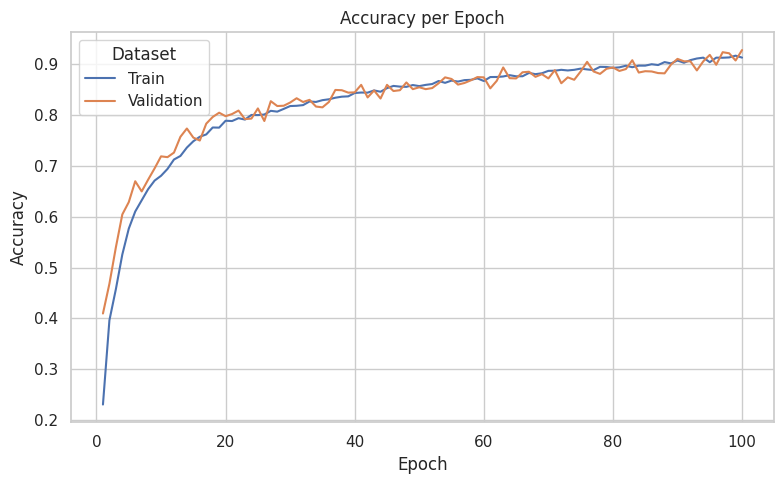

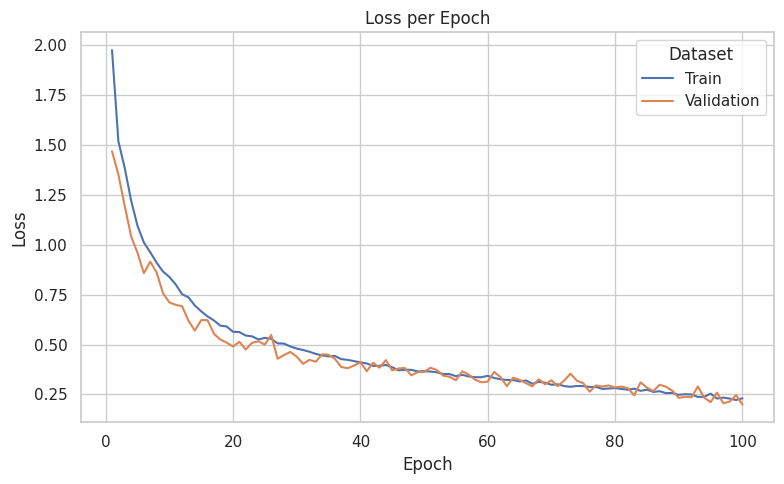

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vit_drone.py
────────────────────────────────────────────────────────────────────────
Trains a Vision Transformer from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────


ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_10ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_10ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vit_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0].name}")
    except RuntimeError:
        print("GPUs already initialized; memory growth could not be configured.")
else:
    print("GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
print(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL (USING VISION TRANSFORMER) ──────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128, transformer_layers=8,
                          dropout=0.5):
    """
    Basic Vision Transformer:
    - Extract patches via Conv2D
    - Project patches into embeddings
    - Add positional embeddings
    - Stack transformer blocks (MHSA + MLP)
    - Pool and classification head
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim), name='reshape_patches')(x)

    # 2) Positional embedding
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=n_patches,
                                     output_dim=embed_dim,
                                     name='pos_embedding')(positions)
    x = x + pos_embedding

    # 3) Transformer blocks
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln1_block{i}')(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                         key_dim=embed_dim,
                                         name=f'mhsa_block{i}')(x1, x1)
        x2 = layers.Add(name=f'residual_attn_block{i}')([attn, x])

        x3 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln2_block{i}')(x2)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(x3)
        mlp = layers.Dense(embed_dim,
                           name=f'mlp2_block{i}')(mlp)
        x = layers.Add(name=f'residual_mlp_block{i}')([mlp, x2])

    # 4) Pooling + classifier head
    x = layers.LayerNormalization(epsilon=1e-6,
                                   name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='ViT_Classifier')

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=num_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")
history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()



► Attempting to load model from /content/drive/MyDrive/DroneDetect_ViT_10ms/vit_drone.h5 …
⚠ Could not load full model (too many positional arguments). Rebuilding architecture …
✔ Weights loaded with model.load_weights().

Total test samples: 1898
Test-set class distribution:
 label
MP1    300
AIR    300
MP2    300
MIN    300
INS    298
PHA    200
DIS    200
Name: count, dtype: int64 

Found 1898 validated image filenames belonging to 7 classes.
► Generating predictions …


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         AIR     0.9054    0.8933    0.8993       300
         DIS     0.9643    0.9450    0.9545       200
         INS     0.8842    0.9228    0.9031       298
         MIN     0.9834    0.9900    0.9867       300
         MP1     0.9301    0.8433    0.8846       300
         MP2     0.8056    0.8567    0.8304       300
         PHA     0.9059    0.9150    0.9104       200

    accuracy                         0.9073      1898
   macro avg     0.9113    0.9095    0.9099      1898
weighted avg     0.9088    0.9073    0.9075      1898



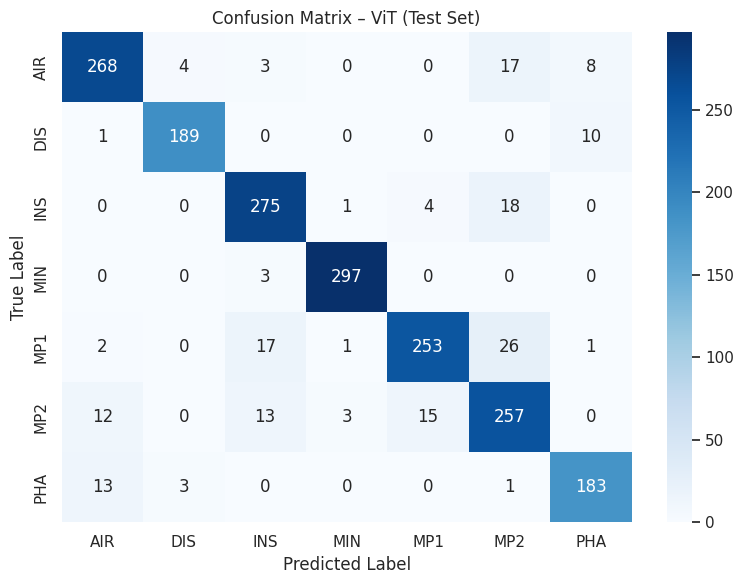

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vit_drone.py
────────────────────────────────────────────────────────────────────────
Evaluates the Vision Transformer (ViT) trained to classify drone types.

Workflow
╰─►  1) Attempts to load the full .h5 model; if that fails, rebuilds the
        architecture and loads only the weights.
     2) Generates predictions on the test split stored in test_split.csv.
     3) Prints a classification report and displays a confusion matrix
        with English titles and axis labels.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_10ms")
MODEL_PATH = MODEL_DIR / "vit_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"


IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 1) Function to rebuild the same ViT architecture used during training
# ──────────────────────────────────────────────────────────────────────────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128,
                          transformer_layers=8, dropout=0.5):
    """Minimal Vision Transformer classifier."""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim),
                       name='reshape_patches')(x)

    # Learnable positional embeddings
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_emb   = layers.Embedding(input_dim=n_patches,
                                 output_dim=embed_dim,
                                 name='pos_embedding')(positions)
    x = x + pos_emb

    # Transformer encoder blocks
    for i in range(transformer_layers):
        # Multi-head self-attention
        ln1 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln1_block{i}')(x)
        att = layers.MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim,
                                        name=f'mhsa_block{i}')(ln1, ln1)
        x   = layers.Add(name=f'residual_attn_block{i}')([att, x])

        # Feed-forward MLP
        ln2 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln2_block{i}')(x)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(ln2)
        mlp = layers.Dense(embed_dim, name=f'mlp2_block{i}')(mlp)
        x   = layers.Add(name=f'residual_mlp_block{i}')([mlp, x])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6, name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs, outputs, name='ViT_Classifier')

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load the trained model (full model or just weights)
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n► Attempting to load model from {MODEL_PATH} …")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✔ Model loaded successfully with tf.keras.models.load_model().")
except Exception as e:
    print(f"⚠ Could not load full model ({e}). Rebuilding architecture …")
    # Read test CSV to infer the number of classes
    tmp_df     = pd.read_csv(TEST_CSV)
    class_list = sorted(tmp_df["label"].unique())
    n_classes  = len(class_list)

    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=n_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.load_weights(MODEL_PATH)
    print("✔ Weights loaded with model.load_weights().")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Prepare the test data generator
# ──────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv(TEST_CSV)
print(f"\nTotal test samples: {len(test_df)}")
print("Test-set class distribution:\n", test_df["label"].value_counts(), "\n")

datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)
label_names = list(gen_test.class_indices.keys())

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluation
# ──────────────────────────────────────────────────────────────────────────────
print("► Generating predictions …")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix – ViT (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# VGG 5 ms

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gera_espectrogramas_dronedetect.py
──────────────────────────────────
Gera 1 espectrograma STFT (224×224) por segmento de 5 ms ao longo
de TODO o arquivo .dat do DroneDetect-V2, salvando em PNG ou NumPy.

Retomável via checkpoint_MOD.pickle (set, drone, arquivo).

Estrutura esperada:
<ROOT_DIR>/<interference>/<drone>/<arquivo>.dat
Ex.: .../CLEAN/AIR_FY/AIR_0010_00.dat
"""
from __future__ import annotations

import os
import re
import pickle
import shutil
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm.auto import tqdm

# ─────────────────── CONFIGURAÇÕES ────────────────────
ROOT_DIR: str = (
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2"
)

# ======= bloco “Specifications” =========
n_per_seg: int            = 1024          # STFT: pontos por segmento
n_overlap_spec: int       = 120           # STFT: overlap
psd_win_type: str         = "hamming"     # janela ('hamming', 'hann', ...)
t_seg_ms: int             = 5             # duração de cada segmento (ms)
hop_ms: int               = 5             # passo entre segmentos (ms)
feature_to_save: List[str]= ['SPEC']      # ['SPEC','PSD','RAW']
format_to_save: List[str] = ['IMG']       # ['IMG','ARR'] ou ambas
interference_folders       = ['CLEAN']     # ['WIFI','BLUE','BOTH','CLEAN']
to_add: bool              = True          # False = recriar pasta de saída
# =======================================

FS: int        = 60_000_000               # taxa de amostragem (Hz)
DIM_PX         = (224, 224)               # tamanho imagem
DPI_IMG        = 100
FEATURES_ROOT  = ROOT_DIR + "_FEATURES_MOD_5ms"
CHK_FILE       = Path(FEATURES_ROOT) / "checkpoint_MOD_5ms.pickle"
WINDOW         = get_window(psd_win_type, n_per_seg)

# Conversão ms → amostras
SAMP_SEG: int  = int(t_seg_ms / 1e3 * FS)  # 5 ms → 300000 amostras
SAMP_HOP: int  = int(hop_ms  / 1e3 * FS)   # 5 ms → 300000 amostras
assert SAMP_HOP > 0 and SAMP_SEG >= SAMP_HOP, "hop_ms deve ser >0 e ≤ t_seg_ms"

# ────────────────── UTILITÁRIAS ──────────────────
def load_iq(path: Path) -> np.ndarray:
    """Lê .dat (float32 intercalado) → complex64 normalizado (z-score)."""
    raw = np.fromfile(path, dtype=np.float32)
    iq  = raw.view(np.complex64)
    return (iq - iq.mean()) / (np.sqrt(iq.var() + 1e-10))

def calc_specgram(x: np.ndarray) -> np.ndarray:
    """Espectrograma (magnitude dB) mantendo apenas frequências ≥ 0."""
    _, _, Z = stft(
        x, fs=FS,
        nperseg=n_per_seg,
        noverlap=n_overlap_spec,
        window=WINDOW,
        return_onesided=False
    )
    spec = 20 * np.log10(np.abs(Z) + 1e-10)
    return spec[: spec.shape[0] // 2, :]   # corta a metade negativa

def save_png(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    plt.figure(
        figsize=(DIM_PX[0]/DPI_IMG, DIM_PX[1]/DPI_IMG),
        dpi=DPI_IMG
    )
    plt.axis('off')
    plt.imshow(arr, origin='lower', aspect='auto', cmap='inferno')
    plt.savefig(
        folder / f"{name}.png",
        dpi=DPI_IMG,
        bbox_inches='tight',
        pad_inches=0
    )
    plt.close()

def save_npy(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    np.save(folder / f"{name}.npy", arr.astype(np.float32))

def load_ckpt() -> Dict[str, int]:
    if CHK_FILE.exists():
        return pickle.loads(CHK_FILE.read_bytes())
    return {"set_i": 0, "drone_i": 0, "file_i": 0}

def save_ckpt(state: Dict[str, int]):
    CHK_FILE.parent.mkdir(parents=True, exist_ok=True)
    CHK_FILE.write_bytes(pickle.dumps(state))

# ───────────────────── MAIN ──────────────────────
def main():
    # Prepara pasta de saída
    if not to_add and Path(FEATURES_ROOT).exists():
        shutil.rmtree(FEATURES_ROOT)
    Path(FEATURES_ROOT).mkdir(exist_ok=True)

    ckpt = load_ckpt()

    for set_i, interf in enumerate(interference_folders[ckpt["set_i"]:], start=ckpt["set_i"]):
        dir_set = Path(ROOT_DIR) / interf
        drone_dirs = sorted(p for p in dir_set.iterdir() if p.is_dir())

        for d_i, drone_dir in enumerate(drone_dirs[ckpt["drone_i"]:], start=ckpt["drone_i"]):
            files = sorted(f for f in drone_dir.glob("*.dat"))

            for f_i, fpath in enumerate(files[ckpt["file_i"]:], start=ckpt["file_i"]):
                # ---- nomes amigáveis ----
                m_fold = re.match(r"([^_]+)_(.+)", drone_dir.name)
                drone_name, cond_name = (
                    m_fold.groups() if m_fold else (drone_dir.name, "UNK")
                )

                m_file = re.match(r".*_(\d{4})_(\d{2})\.dat", fpath.name)
                fi_num, counter = (m_file.groups() if m_file else ("0000", "00"))

                # ---- processamento do arquivo ----
                iq = load_iq(fpath)
                n_segs = max(1, (len(iq) - SAMP_SEG) // SAMP_HOP + 1)

                for seg_idx in range(n_segs):
                    start = seg_idx * SAMP_HOP
                    end   = start + SAMP_SEG
                    if end > len(iq):
                        break
                    segment = iq[start:end]

                    if 'SPEC' in feature_to_save:
                        spec = calc_specgram(segment)

                    seg_tag = f"seg{seg_idx:03d}"
                    base = (
                        f"{interf}_{drone_name}_{cond_name}_"
                        f"{fi_num}_{counter}_{seg_tag}"
                    )

                    if 'IMG' in format_to_save and 'SPEC' in feature_to_save:
                        save_png(spec, Path(FEATURES_ROOT)/"IMG_SPEC", base)

                    if 'ARR' in format_to_save and 'SPEC' in feature_to_save:
                        save_npy(spec, Path(FEATURES_ROOT)/"ARR_SPEC", base)

                # ---- checkpoint: arquivo concluído ----
                ckpt.update({"set_i": set_i, "drone_i": d_i, "file_i": f_i+1})
                save_ckpt(ckpt)

            # terminou drone
            ckpt.update({"file_i": 0, "drone_i": d_i+1})
            save_ckpt(ckpt)

        # terminou interference set
        ckpt.update({"drone_i": 0, "set_i": set_i+1})
        save_ckpt(ckpt)

    print("  Espectrogramas gerados para todos os arquivos e segmentos.")

if __name__ == "__main__":
    main()


  Espectrogramas gerados para todos os arquivos e segmentos.


In [ ]:
import os
from collections import defaultdict

# Caminho-raiz dos espectrogramas
root_dir = ("/content/drive/MyDrive/Projeto - Classificação RF/"
            "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_5ms/IMG_SPEC")

# Inicializa contadores
total = 0
por_pasta = defaultdict(int)   # {subpasta: quantidade}

# Percorre recursivamente
for dirpath, _, files in os.walk(root_dir):
    # mantém apenas imagens; ajuste conforme necessário
    imgs = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if imgs:
        rel = os.path.relpath(dirpath, root_dir)  # subpasta relativa
        por_pasta[rel] += len(imgs)
        total += len(imgs)

# Mostra resultados
print(f"Total de imagens encontradas: {total}\n")
print("Contagem por subpasta:")
for pasta, qtd in sorted(por_pasta.items()):
    print(f"  {pasta:<40} {qtd:>6}")


Total de imagens encontradas: 37951

Contagem por subpasta:
  .                                         37951


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
conta_espectrogramas_por_drone.py
─────────────────────────────────────────────────────────────────
Percorre todos os PNG/JPG sob IMG_SPEC, extrai o tipo de drone
(padrão:  <interf>_<DRONE>_<cond>_<id>_segXXX.png)
e plota a distribuição com Plotly.

Exemplo de nome: CLEAN_AIR_FY_0010_00_seg000.png
 → tipo de drone = "AIR"
"""

import os
from collections import Counter
from pathlib import Path

import pandas as pd
import plotly.express as px

# Caminho-raiz dos espectrogramas
ROOT_DIR = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_5ms/IMG_SPEC")

# ─────────── CONTAGEM ────────────
contador = Counter()

for path in ROOT_DIR.rglob("*"):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        partes = path.stem.split("_")            # divide pelo “_”
        if len(partes) >= 3:
            drone_tipo = partes[1]               # ex.: "AIR"
            contador[drone_tipo] += 1

# converte para DataFrame (mais fácil de ordenar/plotar)
df = (pd.DataFrame({"Drone": list(contador.keys()),
                    "Quantidade": list(contador.values())})
        .sort_values("Quantidade", ascending=False))

print(f"Total de imagens: {df['Quantidade'].sum()}")
display(df)

# ─────────── GRÁFICO ─────────────
fig = px.bar(df,
             x="Drone", y="Quantidade",
             text="Quantidade",
             color="Drone",
             title="Distribuição de Espectrogramas por Tipo de Drone",
             labels=dict(Drone="Tipo de Drone", Quantidade="Nº de Imagens"))

fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(yaxis=dict(title="Quantidade"),
                  xaxis=dict(title="Tipo de Drone"),
                  uniformtext_minsize=8, uniformtext_mode="hide",
                  bargap=0.25,
                  template="plotly_white")

fig.show()


Total de imagens: 37951


Drone  Quantidade
1   MP2        6000
2   MP1        6000
3   MIN        6000
6   AIR        6000
4   INS        5951
0   PHA        4000
5   DIS        4000

 GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 37951
Corrupted PNGs: 0

Original distribution (post-filter):


label
MP2    6000
MP1    6000
MIN    6000
AIR    6000
INS    5951
PHA    4000
DIS    4000
Name: count, dtype: int64


Distribution after split:
Train     :
label
AIR    4800
MIN    4800
MP2    4800
MP1    4800
INS    4760
DIS    3200
PHA    3200
Name: count, dtype: int64
Validation:
label
MP1    600
AIR    600
MIN    600
MP2    600
INS    595
PHA    400
DIS    400
Name: count, dtype: int64
Test      :
label
MP2    600
AIR    600
MP1    600
MIN    600
INS    596
PHA    400
DIS    400
Name: count, dtype: int64
Found 30360 validated image filenames belonging to 7 classes.
Found 3795 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.68538, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 811s - 855ms/step - accuracy: 0.4856 - loss: 1.2879 - val_accuracy: 0.6854 - val_loss: 0.7764
Epoch 2/100



Epoch 2: val_accuracy improved from 0.68538 to 0.74466, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 497s - 523ms/step - accuracy: 0.6972 - loss: 0.7654 - val_accuracy: 0.7447 - val_loss: 0.6210
Epoch 3/100



Epoch 3: val_accuracy improved from 0.74466 to 0.81423, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 498s - 524ms/step - accuracy: 0.7616 - loss: 0.6138 - val_accuracy: 0.8142 - val_loss: 0.4635
Epoch 4/100



Epoch 4: val_accuracy improved from 0.81423 to 0.84611, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 497s - 523ms/step - accuracy: 0.7989 - loss: 0.5187 - val_accuracy: 0.8461 - val_loss: 0.4160
Epoch 5/100



Epoch 5: val_accuracy improved from 0.84611 to 0.85481, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 495s - 521ms/step - accuracy: 0.8185 - loss: 0.4673 - val_accuracy: 0.8548 - val_loss: 0.3842
Epoch 6/100



Epoch 6: val_accuracy did not improve from 0.85481
949/949 - 492s - 518ms/step - accuracy: 0.8356 - loss: 0.4293 - val_accuracy: 0.8482 - val_loss: 0.3906
Epoch 7/100



Epoch 7: val_accuracy improved from 0.85481 to 0.87642, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 493s - 520ms/step - accuracy: 0.8528 - loss: 0.3821 - val_accuracy: 0.8764 - val_loss: 0.3328
Epoch 8/100



Epoch 8: val_accuracy improved from 0.87642 to 0.88406, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 495s - 521ms/step - accuracy: 0.8634 - loss: 0.3589 - val_accuracy: 0.8841 - val_loss: 0.2993
Epoch 9/100



Epoch 9: val_accuracy did not improve from 0.88406
949/949 - 489s - 516ms/step - accuracy: 0.8735 - loss: 0.3286 - val_accuracy: 0.8801 - val_loss: 0.3150
Epoch 10/100



Epoch 10: val_accuracy improved from 0.88406 to 0.89592, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 492s - 519ms/step - accuracy: 0.8812 - loss: 0.3123 - val_accuracy: 0.8959 - val_loss: 0.2728
Epoch 11/100



Epoch 11: val_accuracy improved from 0.89592 to 0.89723, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 493s - 520ms/step - accuracy: 0.8903 - loss: 0.2885 - val_accuracy: 0.8972 - val_loss: 0.2639
Epoch 12/100



Epoch 12: val_accuracy improved from 0.89723 to 0.90119, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 493s - 519ms/step - accuracy: 0.8941 - loss: 0.2767 - val_accuracy: 0.9012 - val_loss: 0.2531
Epoch 13/100



Epoch 13: val_accuracy improved from 0.90119 to 0.90751, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 492s - 519ms/step - accuracy: 0.8990 - loss: 0.2658 - val_accuracy: 0.9075 - val_loss: 0.2576
Epoch 14/100



Epoch 14: val_accuracy did not improve from 0.90751
949/949 - 488s - 514ms/step - accuracy: 0.9073 - loss: 0.2521 - val_accuracy: 0.9041 - val_loss: 0.2530
Epoch 15/100



Epoch 15: val_accuracy improved from 0.90751 to 0.91779, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 487s - 513ms/step - accuracy: 0.9071 - loss: 0.2431 - val_accuracy: 0.9178 - val_loss: 0.2154
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.91779
949/949 - 488s - 514ms/step - accuracy: 0.9095 - loss: 0.2342 - val_accuracy: 0.9178 - val_loss: 0.2170
Epoch 17/100



Epoch 17: val_accuracy did not improve from 0.91779
949/949 - 484s - 509ms/step - accuracy: 0.9132 - loss: 0.2210 - val_accuracy: 0.9017 - val_loss: 0.2497
Epoch 18/100



Epoch 18: val_accuracy improved from 0.91779 to 0.92490, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 485s - 511ms/step - accuracy: 0.9179 - loss: 0.2147 - val_accuracy: 0.9249 - val_loss: 0.1985
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.92490
949/949 - 483s - 509ms/step - accuracy: 0.9205 - loss: 0.2053 - val_accuracy: 0.8980 - val_loss: 0.2713
Epoch 20/100



Epoch 20: val_accuracy improved from 0.92490 to 0.93017, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 482s - 507ms/step - accuracy: 0.9193 - loss: 0.2120 - val_accuracy: 0.9302 - val_loss: 0.1966
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.93017
949/949 - 485s - 511ms/step - accuracy: 0.9249 - loss: 0.1972 - val_accuracy: 0.9249 - val_loss: 0.2010
Epoch 22/100



Epoch 22: val_accuracy improved from 0.93017 to 0.93070, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 486s - 512ms/step - accuracy: 0.9274 - loss: 0.1892 - val_accuracy: 0.9307 - val_loss: 0.1868
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.93070
949/949 - 486s - 512ms/step - accuracy: 0.9265 - loss: 0.1889 - val_accuracy: 0.9157 - val_loss: 0.2347
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.93070
949/949 - 483s - 509ms/step - accuracy: 0.9304 - loss: 0.1803 - val_accuracy: 0.9267 - val_loss: 0.2040
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.93070
949/949 - 480s - 506ms/step - accuracy: 0.9316 - loss: 0.1788 - val_accuracy: 0.9302 - val_loss: 0.1669
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.93070
949/949 - 481s - 507ms/step - accuracy: 0.9292 - loss: 0.1791 - val_accuracy: 0.9244 - val_loss: 0.1975
Epoch 27/100



Epoch 27: val_accuracy improved from 0.93070 to 0.94124, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 487s - 513ms/step - accuracy: 0.9338 - loss: 0.1740 - val_accuracy: 0.9412 - val_loss: 0.1730
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.94124
949/949 - 485s - 511ms/step - accuracy: 0.9356 - loss: 0.1648 - val_accuracy: 0.9386 - val_loss: 0.1533
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.94124
949/949 - 480s - 506ms/step - accuracy: 0.9369 - loss: 0.1603 - val_accuracy: 0.9320 - val_loss: 0.1872
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.94124
949/949 - 483s - 509ms/step - accuracy: 0.9351 - loss: 0.1634 - val_accuracy: 0.9333 - val_loss: 0.1868
Epoch 31/100



Epoch 31: val_accuracy improved from 0.94124 to 0.94466, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 483s - 509ms/step - accuracy: 0.9377 - loss: 0.1605 - val_accuracy: 0.9447 - val_loss: 0.1481
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.94466
949/949 - 483s - 509ms/step - accuracy: 0.9384 - loss: 0.1574 - val_accuracy: 0.9428 - val_loss: 0.1530
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.94466
949/949 - 479s - 505ms/step - accuracy: 0.9393 - loss: 0.1565 - val_accuracy: 0.9426 - val_loss: 0.1665
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.94466
949/949 - 481s - 507ms/step - accuracy: 0.9416 - loss: 0.1482 - val_accuracy: 0.9344 - val_loss: 0.1839
Epoch 35/100



Epoch 35: val_accuracy improved from 0.94466 to 0.94783, saving model to /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5


949/949 - 483s - 509ms/step - accuracy: 0.9429 - loss: 0.1468 - val_accuracy: 0.9478 - val_loss: 0.1532
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.94783
949/949 - 484s - 510ms/step - accuracy: 0.9412 - loss: 0.1484 - val_accuracy: 0.9449 - val_loss: 0.1427
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.94783
949/949 - 481s - 507ms/step - accuracy: 0.9433 - loss: 0.1417 - val_accuracy: 0.9170 - val_loss: 0.2902
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.94783
949/949 - 479s - 505ms/step - accuracy: 0.9442 - loss: 0.1435 - val_accuracy: 0.9291 - val_loss: 0.2314
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.94783
949/949 - 480s - 506ms/step - accuracy: 0.9477 - loss: 0.1341 - val_accuracy: 0.9478 - val_loss: 0.1584
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.94783
949/949 - 480s - 506ms/step - accuracy: 0.9467 - loss: 0.1387 - val_accuracy: 0.9407 - val_loss: 0.1621
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.94783
949/949 - 480s - 506ms/step - accuracy: 0.9496 - loss: 0.1323 - val_accuracy: 0.9460 - val_loss: 0.1500
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.94783
949/949 - 480s - 506ms/step - accuracy: 0.9476 - loss: 0.1327 - val_accuracy: 0.9433 - val_loss: 0.1695
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.94783
949/949 - 475s - 501ms/step - accuracy: 0.9458 - loss: 0.1402 - val_accuracy: 0.9447 - val_loss: 0.1554
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.94783
949/949 - 478s - 503ms/step - accuracy: 0.9483 - loss: 0.1340 - val_accuracy: 0.9407 - val_loss: 0.1624
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.94783
949/949 - 479s - 504ms/step - accuracy: 0.9499 - loss: 0.1295 - val_accuracy: 0.9415 - val_loss: 0.1691
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.94783
949/949 - 479s - 505ms/step - accuracy: 0.9508 - loss: 0.1267 - val_accuracy: 0.9431 - val_loss: 0.1549
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.94783
949/949 - 478s - 503ms/step - accuracy: 0.9510 - loss: 0.1229 - val_accuracy: 0.9381 - val_loss: 0.1895
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.94783
949/949 - 479s - 504ms/step - accuracy: 0.9504 - loss: 0.1298 - val_accuracy: 0.9441 - val_loss: 0.1549
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.94783
949/949 - 480s - 505ms/step - accuracy: 0.9526 - loss: 0.1200 - val_accuracy: 0.9473 - val_loss: 0.1575
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.94783
949/949 - 477s - 502ms/step - accuracy: 0.9532 - loss: 0.1203 - val_accuracy: 0.9320 - val_loss: 0.2014
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 35.


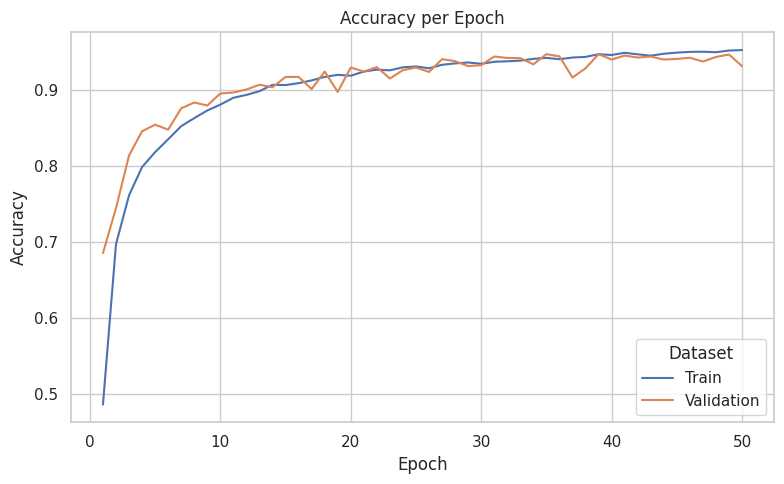

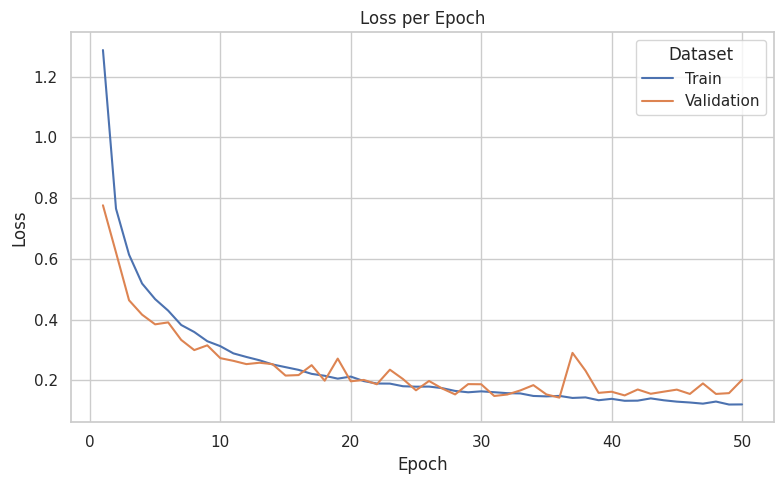

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Trains a VGG-16 from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""

import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_5ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/15ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vgg_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU detected: {gpus[0].name}")
    except RuntimeError:
        print(" GPUs already initialized; memory growth could not be configured.")
else:
    print(" GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

# build DataFrame
import pandas as pd

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
display(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL ──────────
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model = VGG16(weights=None, include_top=False,
                       input_shape=(*IMG_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


Loading model from /content/drive/MyDrive/DroneDetect_VGG/15ms/vgg_drone.h5 …


Total test samples: 3796
Test set distribution:
label
MP2    600
AIR    600
MP1    600
MIN    600
INS    596
PHA    400
DIS    400
Name: count, dtype: int64 

Found 3796 validated image filenames belonging to 7 classes.
Performing predictions on test set…


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step

Classification Report:
              precision    recall  f1-score   support

         AIR     0.9386    0.9433    0.9410       600
         DIS     0.8630    0.9450    0.9021       400
         INS     0.9071    0.9664    0.9358       596
         MIN     0.9966    0.9750    0.9857       600
         MP1     0.9736    0.9217    0.9469       600
         MP2     0.9303    0.9117    0.9209       600
         PHA     0.9231    0.8700    0.8958       400

    accuracy                         0.9360      3796
   macro avg     0.9332    0.9333    0.9326      3796
weighted avg     0.9374    0.9360    0.9361      3796



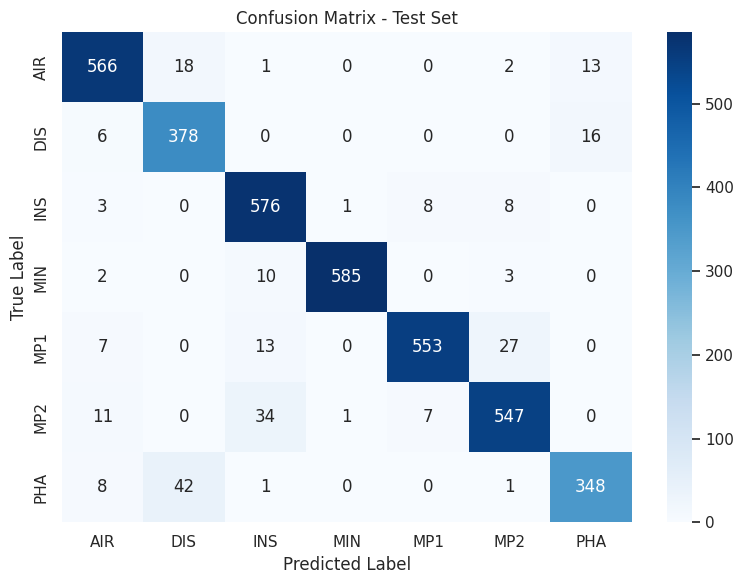

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Loads the saved "vgg_drone.h5" model, evaluates on the test split,
prints classification metrics and displays a confusion matrix using seaborn.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/15ms")
MODEL_PATH = MODEL_DIR / "vgg_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"


IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ─────────── LOAD MODEL ───────────
print(f"Loading model from {MODEL_PATH} …")
model = tf.keras.models.load_model(MODEL_PATH)

# ─────────── LOAD TEST SPLIT ───────────
test_df = pd.read_csv(TEST_CSV)
print(f"Total test samples: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts(), "\n")

# ─────────── TEST DATA GENERATOR ───────────
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    test_df,
    x_col="path", y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# ─────────── PREDICTIONS ───────────
print("Performing predictions on test set…")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes
labels = list(gen_test.class_indices.keys())

# ─────────── CLASSIFICATION REPORT ───────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# ─────────── CONFUSION MATRIX ───────────
cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# TRANSFORMER 5 ms

GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 37951
Corrupted PNGs: 0

Original distribution (post-filter):
label
MP2    6000
MP1    6000
MIN    6000
AIR    6000
INS    5951
PHA    4000
DIS    4000
Name: count, dtype: int64

Distribution after split:
Train     :
label
AIR    4800
MIN    4800
MP2    4800
MP1    4800
INS    4760
DIS    3200
PHA    3200
Name: count, dtype: int64
Validation:
label
MP1    600
AIR    600
MIN    600
MP2    600
INS    595
PHA    400
DIS    400
Name: count, dtype: int64
Test      :
label
MP2    600
AIR    600
MP1    600
MIN    600
INS    596
PHA    400
DIS    400
Name: count, dtype: int64
Found 30360 validated image filenames belonging to 7 classes.
Found 3795 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


Model: "ViT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 14, 14,    │     49,216 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_patches     │ (None, 196, 64)   │          0 │ patch_embedding[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ reshape_patches[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block0          │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block0         │ (None, 196, 64)   │     66,368 │ ln1_block0[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block0[0][0… │
│ (Add)               │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block0          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block0 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block0 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block0 │ (None, 196, 64)   │          0 │ mlp2_block0[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block1          │ (None, 196, 64)   │        128 │ residual_mlp_blo… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block1         │ (None, 196, 64)   │     66,368 │ ln1_block1[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block1[0][0… │
│ (Add)               │                   │            │ residual_mlp_blo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block1          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block1 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block1 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block1 │ (None, 196, 64)   │          0 │ mlp2_block1[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 715,399 (2.73 MB)

 Trainable params: 715,399 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.46324, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 635s - 669ms/step - accuracy: 0.2996 - loss: 1.8182 - val_accuracy: 0.4632 - val_loss: 1.3518
Epoch 2/100



Epoch 2: val_accuracy improved from 0.46324 to 0.56706, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 378s - 398ms/step - accuracy: 0.4695 - loss: 1.3462 - val_accuracy: 0.5671 - val_loss: 1.1071
Epoch 3/100



Epoch 3: val_accuracy improved from 0.56706 to 0.60606, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 380s - 400ms/step - accuracy: 0.5573 - loss: 1.1210 - val_accuracy: 0.6061 - val_loss: 0.9559
Epoch 4/100



Epoch 4: val_accuracy improved from 0.60606 to 0.64848, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 384s - 404ms/step - accuracy: 0.5962 - loss: 1.0121 - val_accuracy: 0.6485 - val_loss: 0.8502
Epoch 5/100



Epoch 5: val_accuracy improved from 0.64848 to 0.66087, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 381s - 401ms/step - accuracy: 0.6300 - loss: 0.9260 - val_accuracy: 0.6609 - val_loss: 0.8171
Epoch 6/100



Epoch 6: val_accuracy improved from 0.66087 to 0.69407, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 377s - 397ms/step - accuracy: 0.6538 - loss: 0.8620 - val_accuracy: 0.6941 - val_loss: 0.7431
Epoch 7/100



Epoch 7: val_accuracy did not improve from 0.69407
949/949 - 375s - 395ms/step - accuracy: 0.6735 - loss: 0.8157 - val_accuracy: 0.6906 - val_loss: 0.7530
Epoch 8/100



Epoch 8: val_accuracy improved from 0.69407 to 0.70672, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 376s - 396ms/step - accuracy: 0.6872 - loss: 0.7892 - val_accuracy: 0.7067 - val_loss: 0.7114
Epoch 9/100



Epoch 9: val_accuracy improved from 0.70672 to 0.71252, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 378s - 398ms/step - accuracy: 0.7014 - loss: 0.7551 - val_accuracy: 0.7125 - val_loss: 0.7257
Epoch 10/100



Epoch 10: val_accuracy improved from 0.71252 to 0.73202, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 382s - 402ms/step - accuracy: 0.7055 - loss: 0.7364 - val_accuracy: 0.7320 - val_loss: 0.6661
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.73202
949/949 - 378s - 398ms/step - accuracy: 0.7093 - loss: 0.7232 - val_accuracy: 0.7183 - val_loss: 0.6628
Epoch 12/100



Epoch 12: val_accuracy did not improve from 0.73202
949/949 - 377s - 397ms/step - accuracy: 0.7209 - loss: 0.7035 - val_accuracy: 0.7146 - val_loss: 0.7016
Epoch 13/100



Epoch 13: val_accuracy did not improve from 0.73202
949/949 - 378s - 398ms/step - accuracy: 0.7238 - loss: 0.6901 - val_accuracy: 0.7233 - val_loss: 0.6979
Epoch 14/100



Epoch 14: val_accuracy improved from 0.73202 to 0.75125, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 382s - 402ms/step - accuracy: 0.7279 - loss: 0.6800 - val_accuracy: 0.7513 - val_loss: 0.6317
Epoch 15/100



Epoch 15: val_accuracy did not improve from 0.75125
949/949 - 380s - 401ms/step - accuracy: 0.7362 - loss: 0.6587 - val_accuracy: 0.7470 - val_loss: 0.6256
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.75125
949/949 - 375s - 396ms/step - accuracy: 0.7381 - loss: 0.6536 - val_accuracy: 0.7373 - val_loss: 0.6317
Epoch 17/100



Epoch 17: val_accuracy improved from 0.75125 to 0.77365, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 380s - 400ms/step - accuracy: 0.7451 - loss: 0.6357 - val_accuracy: 0.7736 - val_loss: 0.5740
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.77365
949/949 - 379s - 399ms/step - accuracy: 0.7510 - loss: 0.6235 - val_accuracy: 0.7534 - val_loss: 0.5926
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.77365
949/949 - 376s - 396ms/step - accuracy: 0.7524 - loss: 0.6166 - val_accuracy: 0.7563 - val_loss: 0.5839
Epoch 20/100



Epoch 20: val_accuracy did not improve from 0.77365
949/949 - 376s - 396ms/step - accuracy: 0.7589 - loss: 0.5981 - val_accuracy: 0.7610 - val_loss: 0.5849
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.77365
949/949 - 376s - 396ms/step - accuracy: 0.7643 - loss: 0.5893 - val_accuracy: 0.7549 - val_loss: 0.5862
Epoch 22/100



Epoch 22: val_accuracy improved from 0.77365 to 0.77602, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 376s - 396ms/step - accuracy: 0.7700 - loss: 0.5712 - val_accuracy: 0.7760 - val_loss: 0.5561
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.77602
949/949 - 374s - 394ms/step - accuracy: 0.7745 - loss: 0.5605 - val_accuracy: 0.7668 - val_loss: 0.5732
Epoch 24/100



Epoch 24: val_accuracy improved from 0.77602 to 0.78235, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 375s - 395ms/step - accuracy: 0.7821 - loss: 0.5444 - val_accuracy: 0.7823 - val_loss: 0.5322
Epoch 25/100



Epoch 25: val_accuracy improved from 0.78235 to 0.78788, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 376s - 396ms/step - accuracy: 0.7842 - loss: 0.5366 - val_accuracy: 0.7879 - val_loss: 0.5102
Epoch 26/100



Epoch 26: val_accuracy improved from 0.78788 to 0.79368, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 377s - 397ms/step - accuracy: 0.7907 - loss: 0.5266 - val_accuracy: 0.7937 - val_loss: 0.5052
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.79368
949/949 - 384s - 405ms/step - accuracy: 0.7914 - loss: 0.5215 - val_accuracy: 0.7742 - val_loss: 0.5180
Epoch 28/100



Epoch 28: val_accuracy improved from 0.79368 to 0.79499, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 382s - 403ms/step - accuracy: 0.7987 - loss: 0.5041 - val_accuracy: 0.7950 - val_loss: 0.4907
Epoch 29/100



Epoch 29: val_accuracy improved from 0.79499 to 0.80580, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 379s - 399ms/step - accuracy: 0.8053 - loss: 0.4930 - val_accuracy: 0.8058 - val_loss: 0.4631
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.80580
949/949 - 378s - 398ms/step - accuracy: 0.8072 - loss: 0.4873 - val_accuracy: 0.7982 - val_loss: 0.4746
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.80580
949/949 - 377s - 397ms/step - accuracy: 0.8096 - loss: 0.4865 - val_accuracy: 0.7887 - val_loss: 0.5068
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.80580
949/949 - 381s - 401ms/step - accuracy: 0.8105 - loss: 0.4739 - val_accuracy: 0.7768 - val_loss: 0.5397
Epoch 33/100



Epoch 33: val_accuracy improved from 0.80580 to 0.81792, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 376s - 396ms/step - accuracy: 0.8145 - loss: 0.4695 - val_accuracy: 0.8179 - val_loss: 0.4502
Epoch 34/100



Epoch 34: val_accuracy improved from 0.81792 to 0.82213, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 374s - 394ms/step - accuracy: 0.8208 - loss: 0.4575 - val_accuracy: 0.8221 - val_loss: 0.4422
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.82213
949/949 - 376s - 396ms/step - accuracy: 0.8266 - loss: 0.4428 - val_accuracy: 0.8005 - val_loss: 0.4797
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.82213
949/949 - 379s - 399ms/step - accuracy: 0.8279 - loss: 0.4424 - val_accuracy: 0.8079 - val_loss: 0.4701
Epoch 37/100



Epoch 37: val_accuracy improved from 0.82213 to 0.83136, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 381s - 401ms/step - accuracy: 0.8352 - loss: 0.4295 - val_accuracy: 0.8314 - val_loss: 0.4531
Epoch 38/100



Epoch 38: val_accuracy improved from 0.83136 to 0.83162, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 378s - 398ms/step - accuracy: 0.8373 - loss: 0.4159 - val_accuracy: 0.8316 - val_loss: 0.4283
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.83162
949/949 - 380s - 400ms/step - accuracy: 0.8368 - loss: 0.4172 - val_accuracy: 0.8213 - val_loss: 0.4428
Epoch 40/100



Epoch 40: val_accuracy improved from 0.83162 to 0.84585, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 380s - 401ms/step - accuracy: 0.8426 - loss: 0.4059 - val_accuracy: 0.8458 - val_loss: 0.3809
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.84585
949/949 - 380s - 400ms/step - accuracy: 0.8436 - loss: 0.4034 - val_accuracy: 0.8422 - val_loss: 0.3875
Epoch 42/100



Epoch 42: val_accuracy improved from 0.84585 to 0.84796, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 381s - 401ms/step - accuracy: 0.8463 - loss: 0.3949 - val_accuracy: 0.8480 - val_loss: 0.3925
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.84796
949/949 - 379s - 400ms/step - accuracy: 0.8524 - loss: 0.3843 - val_accuracy: 0.8466 - val_loss: 0.3797
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.84796
949/949 - 374s - 394ms/step - accuracy: 0.8508 - loss: 0.3807 - val_accuracy: 0.8416 - val_loss: 0.3997
Epoch 45/100



Epoch 45: val_accuracy improved from 0.84796 to 0.84848, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 382s - 402ms/step - accuracy: 0.8545 - loss: 0.3768 - val_accuracy: 0.8485 - val_loss: 0.3968
Epoch 46/100



Epoch 46: val_accuracy improved from 0.84848 to 0.86298, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 380s - 401ms/step - accuracy: 0.8565 - loss: 0.3716 - val_accuracy: 0.8630 - val_loss: 0.3555
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.86298
949/949 - 380s - 401ms/step - accuracy: 0.8542 - loss: 0.3720 - val_accuracy: 0.8606 - val_loss: 0.3454
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.86298
949/949 - 382s - 402ms/step - accuracy: 0.8597 - loss: 0.3611 - val_accuracy: 0.8611 - val_loss: 0.3502
Epoch 49/100



Epoch 49: val_accuracy improved from 0.86298 to 0.86588, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 378s - 399ms/step - accuracy: 0.8677 - loss: 0.3492 - val_accuracy: 0.8659 - val_loss: 0.3470
Epoch 50/100



Epoch 50: val_accuracy improved from 0.86588 to 0.87800, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 378s - 399ms/step - accuracy: 0.8622 - loss: 0.3581 - val_accuracy: 0.8780 - val_loss: 0.3155
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.87800
949/949 - 375s - 395ms/step - accuracy: 0.8665 - loss: 0.3525 - val_accuracy: 0.8746 - val_loss: 0.3284
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.87800
949/949 - 374s - 394ms/step - accuracy: 0.8652 - loss: 0.3478 - val_accuracy: 0.8730 - val_loss: 0.3276
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.87800
949/949 - 374s - 394ms/step - accuracy: 0.8663 - loss: 0.3452 - val_accuracy: 0.8574 - val_loss: 0.3456
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.87800
949/949 - 376s - 396ms/step - accuracy: 0.8707 - loss: 0.3355 - val_accuracy: 0.8582 - val_loss: 0.3536
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.87800
949/949 - 378s - 398ms/step - accuracy: 0.8728 - loss: 0.3325 - val_accuracy: 0.8743 - val_loss: 0.3262
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.87800
949/949 - 379s - 399ms/step - accuracy: 0.8730 - loss: 0.3305 - val_accuracy: 0.8682 - val_loss: 0.3383
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.87800
949/949 - 375s - 395ms/step - accuracy: 0.8738 - loss: 0.3274 - val_accuracy: 0.8709 - val_loss: 0.3238
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.87800
949/949 - 374s - 394ms/step - accuracy: 0.8726 - loss: 0.3295 - val_accuracy: 0.8780 - val_loss: 0.3090
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.87800
949/949 - 377s - 397ms/step - accuracy: 0.8772 - loss: 0.3201 - val_accuracy: 0.8661 - val_loss: 0.3392
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.87800
949/949 - 377s - 397ms/step - accuracy: 0.8776 - loss: 0.3158 - val_accuracy: 0.8772 - val_loss: 0.3239
Epoch 61/100



Epoch 61: val_accuracy improved from 0.87800 to 0.87984, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 375s - 395ms/step - accuracy: 0.8774 - loss: 0.3184 - val_accuracy: 0.8798 - val_loss: 0.3068
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.87984
949/949 - 381s - 401ms/step - accuracy: 0.8796 - loss: 0.3129 - val_accuracy: 0.8767 - val_loss: 0.3108
Epoch 63/100



Epoch 63: val_accuracy improved from 0.87984 to 0.89117, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 385s - 406ms/step - accuracy: 0.8802 - loss: 0.3113 - val_accuracy: 0.8912 - val_loss: 0.2863
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.89117
949/949 - 377s - 398ms/step - accuracy: 0.8832 - loss: 0.3055 - val_accuracy: 0.8719 - val_loss: 0.3241
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.89117
949/949 - 376s - 396ms/step - accuracy: 0.8813 - loss: 0.3035 - val_accuracy: 0.8893 - val_loss: 0.2852
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.89117
949/949 - 376s - 396ms/step - accuracy: 0.8839 - loss: 0.3026 - val_accuracy: 0.8783 - val_loss: 0.3051
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.89117
949/949 - 376s - 396ms/step - accuracy: 0.8845 - loss: 0.3002 - val_accuracy: 0.8551 - val_loss: 0.3573
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.89117
949/949 - 374s - 394ms/step - accuracy: 0.8852 - loss: 0.2976 - val_accuracy: 0.8870 - val_loss: 0.2830
Epoch 69/100



Epoch 69: val_accuracy improved from 0.89117 to 0.89513, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 380s - 401ms/step - accuracy: 0.8852 - loss: 0.2975 - val_accuracy: 0.8951 - val_loss: 0.2762
Epoch 70/100



Epoch 70: val_accuracy did not improve from 0.89513
949/949 - 378s - 398ms/step - accuracy: 0.8877 - loss: 0.2944 - val_accuracy: 0.8809 - val_loss: 0.3080
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.89513
949/949 - 380s - 400ms/step - accuracy: 0.8880 - loss: 0.2923 - val_accuracy: 0.8888 - val_loss: 0.2867
Epoch 72/100



Epoch 72: val_accuracy did not improve from 0.89513
949/949 - 379s - 399ms/step - accuracy: 0.8882 - loss: 0.2915 - val_accuracy: 0.8872 - val_loss: 0.2793
Epoch 73/100



Epoch 73: val_accuracy did not improve from 0.89513
949/949 - 383s - 403ms/step - accuracy: 0.8905 - loss: 0.2820 - val_accuracy: 0.8912 - val_loss: 0.2755
Epoch 74/100



Epoch 74: val_accuracy did not improve from 0.89513
949/949 - 378s - 398ms/step - accuracy: 0.8906 - loss: 0.2824 - val_accuracy: 0.8848 - val_loss: 0.2919
Epoch 75/100



Epoch 75: val_accuracy did not improve from 0.89513
949/949 - 373s - 393ms/step - accuracy: 0.8923 - loss: 0.2819 - val_accuracy: 0.8804 - val_loss: 0.2989
Epoch 76/100



Epoch 76: val_accuracy did not improve from 0.89513
949/949 - 377s - 397ms/step - accuracy: 0.8923 - loss: 0.2782 - val_accuracy: 0.8888 - val_loss: 0.2805
Epoch 77/100



Epoch 77: val_accuracy improved from 0.89513 to 0.90145, saving model to /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5


949/949 - 378s - 398ms/step - accuracy: 0.8953 - loss: 0.2751 - val_accuracy: 0.9014 - val_loss: 0.2555
Epoch 78/100



Epoch 78: val_accuracy did not improve from 0.90145
949/949 - 379s - 400ms/step - accuracy: 0.8955 - loss: 0.2727 - val_accuracy: 0.8933 - val_loss: 0.2701
Epoch 79/100



Epoch 79: val_accuracy did not improve from 0.90145
949/949 - 376s - 396ms/step - accuracy: 0.8967 - loss: 0.2717 - val_accuracy: 0.8704 - val_loss: 0.3273
Epoch 80/100



Epoch 80: val_accuracy did not improve from 0.90145
949/949 - 374s - 394ms/step - accuracy: 0.8931 - loss: 0.2755 - val_accuracy: 0.8830 - val_loss: 0.2941
Epoch 81/100



Epoch 81: val_accuracy did not improve from 0.90145
949/949 - 376s - 396ms/step - accuracy: 0.8953 - loss: 0.2722 - val_accuracy: 0.8880 - val_loss: 0.2827
Epoch 82/100



Epoch 82: val_accuracy did not improve from 0.90145
949/949 - 375s - 395ms/step - accuracy: 0.8962 - loss: 0.2701 - val_accuracy: 0.8949 - val_loss: 0.2675
Epoch 83/100



Epoch 83: val_accuracy did not improve from 0.90145
949/949 - 374s - 394ms/step - accuracy: 0.8961 - loss: 0.2654 - val_accuracy: 0.8648 - val_loss: 0.3413
Epoch 84/100



Epoch 84: val_accuracy did not improve from 0.90145
949/949 - 376s - 396ms/step - accuracy: 0.8993 - loss: 0.2636 - val_accuracy: 0.8872 - val_loss: 0.2941
Epoch 85/100



Epoch 85: val_accuracy did not improve from 0.90145
949/949 - 378s - 398ms/step - accuracy: 0.8985 - loss: 0.2584 - val_accuracy: 0.8885 - val_loss: 0.2878
Epoch 86/100



Epoch 86: val_accuracy did not improve from 0.90145
949/949 - 376s - 396ms/step - accuracy: 0.8993 - loss: 0.2630 - val_accuracy: 0.8888 - val_loss: 0.2802
Epoch 87/100



Epoch 87: val_accuracy did not improve from 0.90145
949/949 - 375s - 396ms/step - accuracy: 0.8992 - loss: 0.2628 - val_accuracy: 0.8822 - val_loss: 0.3003
Epoch 88/100



Epoch 88: val_accuracy did not improve from 0.90145
949/949 - 375s - 395ms/step - accuracy: 0.9015 - loss: 0.2573 - val_accuracy: 0.8875 - val_loss: 0.2802
Epoch 89/100



Epoch 89: val_accuracy did not improve from 0.90145
949/949 - 377s - 397ms/step - accuracy: 0.8998 - loss: 0.2565 - val_accuracy: 0.8885 - val_loss: 0.2871
Epoch 90/100



Epoch 90: val_accuracy did not improve from 0.90145
949/949 - 378s - 398ms/step - accuracy: 0.9033 - loss: 0.2515 - val_accuracy: 0.8856 - val_loss: 0.3027
Epoch 91/100



Epoch 91: val_accuracy did not improve from 0.90145
949/949 - 379s - 400ms/step - accuracy: 0.9006 - loss: 0.2582 - val_accuracy: 0.8896 - val_loss: 0.2696
Epoch 92/100



Epoch 92: val_accuracy did not improve from 0.90145
949/949 - 380s - 400ms/step - accuracy: 0.9031 - loss: 0.2507 - val_accuracy: 0.8856 - val_loss: 0.2795
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 77.


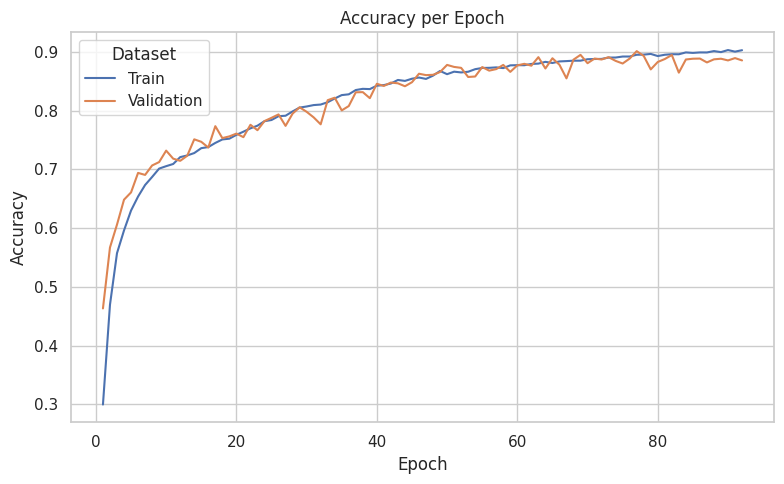

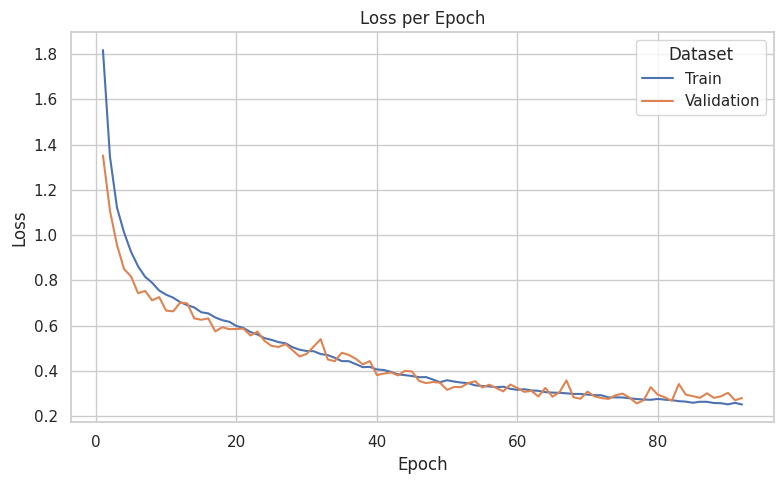

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vit_drone.py
────────────────────────────────────────────────────────────────────────
Trains a Vision Transformer from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────


ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_5ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_5ms")


MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vit_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0].name}")
    except RuntimeError:
        print("GPUs already initialized; memory growth could not be configured.")
else:
    print("GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
print(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL (USING VISION TRANSFORMER) ──────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128, transformer_layers=8,
                          dropout=0.5):
    """
    Basic Vision Transformer:
    - Extract patches via Conv2D
    - Project patches into embeddings
    - Add positional embeddings
    - Stack transformer blocks (MHSA + MLP)
    - Pool and classification head
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim), name='reshape_patches')(x)

    # 2) Positional embedding
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=n_patches,
                                     output_dim=embed_dim,
                                     name='pos_embedding')(positions)
    x = x + pos_embedding

    # 3) Transformer blocks
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln1_block{i}')(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                         key_dim=embed_dim,
                                         name=f'mhsa_block{i}')(x1, x1)
        x2 = layers.Add(name=f'residual_attn_block{i}')([attn, x])

        x3 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln2_block{i}')(x2)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(x3)
        mlp = layers.Dense(embed_dim,
                           name=f'mlp2_block{i}')(mlp)
        x = layers.Add(name=f'residual_mlp_block{i}')([mlp, x2])

    # 4) Pooling + classifier head
    x = layers.LayerNormalization(epsilon=1e-6,
                                   name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='ViT_Classifier')

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=num_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")
history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


43


► Attempting to load model from /content/drive/MyDrive/DroneDetect_ViT_5ms/vit_drone.h5 …
⚠ Could not load full model (too many positional arguments). Rebuilding architecture …
✔ Weights loaded with model.load_weights().

Total test samples: 3796
Test-set class distribution:
 label
MP2    600
AIR    600
MP1    600
MIN    600
INS    596
PHA    400
DIS    400
Name: count, dtype: int64 

Found 3796 validated image filenames belonging to 7 classes.
► Generating predictions …


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         AIR     0.9456    0.9267    0.9360       600
         DIS     0.9392    0.8500    0.8924       400
         INS     0.8639    0.8842    0.8740       596
         MIN     0.9983    0.9750    0.9865       600
         MP1     0.9494    0.8133    0.8761       600
         MP2     0.7708    0.8967    0.8290       600
         PHA     0.8516    0.9325    0.8902       400

    accuracy                         0.8975      3796
   macro avg     0.9027    0.8969    0.8977      3796
weighted avg     0.9035    0.8975    0.8984      3796



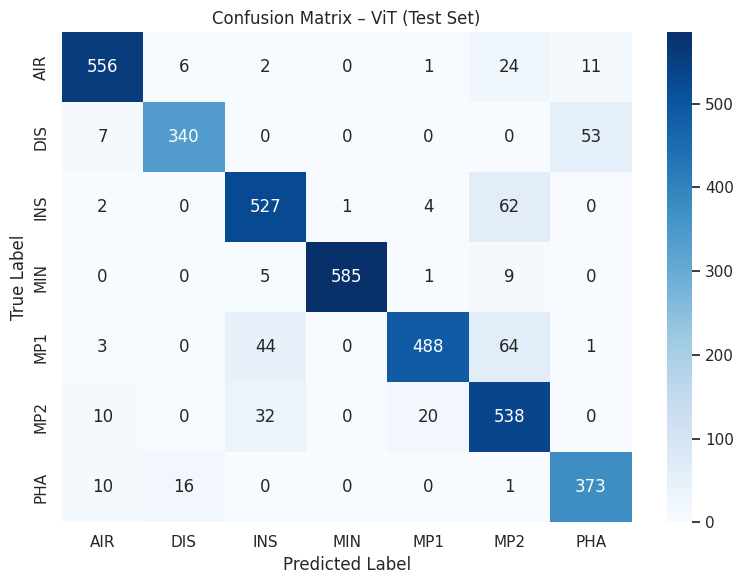

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vit_drone.py
────────────────────────────────────────────────────────────────────────
Evaluates the Vision Transformer (ViT) trained to classify drone types.

Workflow
╰─►  1) Attempts to load the full .h5 model; if that fails, rebuilds the
        architecture and loads only the weights.
     2) Generates predictions on the test split stored in test_split.csv.
     3) Prints a classification report and displays a confusion matrix
        with English titles and axis labels.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_5ms")
MODEL_PATH = MODEL_DIR / "vit_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"



IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 1) Function to rebuild the same ViT architecture used during training
# ──────────────────────────────────────────────────────────────────────────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128,
                          transformer_layers=8, dropout=0.5):
    """Minimal Vision Transformer classifier."""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim),
                       name='reshape_patches')(x)

    # Learnable positional embeddings
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_emb   = layers.Embedding(input_dim=n_patches,
                                 output_dim=embed_dim,
                                 name='pos_embedding')(positions)
    x = x + pos_emb

    # Transformer encoder blocks
    for i in range(transformer_layers):
        # Multi-head self-attention
        ln1 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln1_block{i}')(x)
        att = layers.MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim,
                                        name=f'mhsa_block{i}')(ln1, ln1)
        x   = layers.Add(name=f'residual_attn_block{i}')([att, x])

        # Feed-forward MLP
        ln2 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln2_block{i}')(x)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(ln2)
        mlp = layers.Dense(embed_dim, name=f'mlp2_block{i}')(mlp)
        x   = layers.Add(name=f'residual_mlp_block{i}')([mlp, x])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6, name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs, outputs, name='ViT_Classifier')

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load the trained model (full model or just weights)
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n► Attempting to load model from {MODEL_PATH} …")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✔ Model loaded successfully with tf.keras.models.load_model().")
except Exception as e:
    print(f"⚠ Could not load full model ({e}). Rebuilding architecture …")
    # Read test CSV to infer the number of classes
    tmp_df     = pd.read_csv(TEST_CSV)
    class_list = sorted(tmp_df["label"].unique())
    n_classes  = len(class_list)

    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=n_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.load_weights(MODEL_PATH)
    print("✔ Weights loaded with model.load_weights().")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Prepare the test data generator
# ──────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv(TEST_CSV)
print(f"\nTotal test samples: {len(test_df)}")
print("Test-set class distribution:\n", test_df["label"].value_counts(), "\n")

datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)
label_names = list(gen_test.class_indices.keys())

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluation
# ──────────────────────────────────────────────────────────────────────────────
print("► Generating predictions …")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix – ViT (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# VGG 30 ms

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gera_espectrogramas_dronedetect.py
──────────────────────────────────
Gera 1 espectrograma STFT (224×224) por segmento de 30 ms ao longo
de TODO o arquivo .dat do DroneDetect-V2, salvando em PNG ou NumPy.

Retomável via checkpoint_MOD_30ms.pickle (set, drone, arquivo).

Estrutura esperada:
<ROOT_DIR>/<interference>/<drone>/<arquivo>.dat
Ex.: .../CLEAN/AIR_FY/AIR_0010_00.dat
"""
from __future__ import annotations

import os
import re
import pickle
import shutil
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm.auto import tqdm

# ─────────────────── CONFIGURAÇÕES ────────────────────
ROOT_DIR: str = (
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2"
)

# ======= bloco “Specifications” =========
n_per_seg: int             = 1024          # STFT: pontos por segmento
n_overlap_spec: int        = 120           # STFT: overlap
psd_win_type: str          = "hamming"     # janela ('hamming', 'hann', ...)
t_seg_ms: int              = 30            # ★ duração de cada segmento (ms)
hop_ms: int                = 30            # ★ passo entre segmentos (ms)
feature_to_save: List[str] = ['SPEC']      # ['SPEC','PSD','RAW']
format_to_save: List[str]  = ['IMG']       # ['IMG','ARR'] ou ambas
interference_folders       = ['CLEAN']     # ['WIFI','BLUE','BOTH','CLEAN']
to_add: bool               = True          # False = recriar pasta de saída
# =======================================

FS: int        = 60_000_000               # taxa de amostragem (Hz)
DIM_PX         = (224, 224)               # tamanho imagem
DPI_IMG        = 100
FEATURES_ROOT  = ROOT_DIR + "_FEATURES_MOD_30ms"     # ★ pasta de saída
CHK_FILE       = Path(FEATURES_ROOT) / "checkpoint_MOD_30ms.pickle"
WINDOW         = get_window(psd_win_type, n_per_seg)

# Conversão ms → amostras
SAMP_SEG: int  = int(t_seg_ms / 1e3 * FS)  # 30 ms → 1 800 000 amostras
SAMP_HOP: int  = int(hop_ms  / 1e3 * FS)   # 30 ms → 1 800 000 amostras
assert SAMP_HOP > 0 and SAMP_SEG >= SAMP_HOP, "hop_ms deve ser >0 e ≤ t_seg_ms"

# ────────────────── UTILITÁRIAS ──────────────────
def load_iq(path: Path) -> np.ndarray:
    """Lê .dat (float32 intercalado) → complex64 normalizado (z-score)."""
    raw = np.fromfile(path, dtype=np.float32)
    iq  = raw.view(np.complex64)
    return (iq - iq.mean()) / (np.sqrt(iq.var() + 1e-10))

def calc_specgram(x: np.ndarray) -> np.ndarray:
    """Espectrograma (magnitude dB) mantendo apenas frequências ≥ 0."""
    _, _, Z = stft(
        x, fs=FS,
        nperseg=n_per_seg,
        noverlap=n_overlap_spec,
        window=WINDOW,
        return_onesided=False
    )
    spec = 20 * np.log10(np.abs(Z) + 1e-10)
    return spec[: spec.shape[0] // 2, :]   # corta a metade negativa

def save_png(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    plt.figure(
        figsize=(DIM_PX[0] / DPI_IMG, DIM_PX[1] / DPI_IMG),
        dpi=DPI_IMG
    )
    plt.axis('off')
    plt.imshow(arr, origin='lower', aspect='auto', cmap='inferno')
    plt.savefig(
        folder / f"{name}.png",
        dpi=DPI_IMG,
        bbox_inches='tight',
        pad_inches=0
    )
    plt.close()

def save_npy(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    np.save(folder / f"{name}.npy", arr.astype(np.float32))

def load_ckpt() -> Dict[str, int]:
    if CHK_FILE.exists():
        return pickle.loads(CHK_FILE.read_bytes())
    return {"set_i": 0, "drone_i": 0, "file_i": 0}

def save_ckpt(state: Dict[str, int]):
    CHK_FILE.parent.mkdir(parents=True, exist_ok=True)
    CHK_FILE.write_bytes(pickle.dumps(state))

# ───────────────────── MAIN ──────────────────────
def main():
    # Prepara pasta de saída
    if not to_add and Path(FEATURES_ROOT).exists():
        shutil.rmtree(FEATURES_ROOT)
    Path(FEATURES_ROOT).mkdir(exist_ok=True)

    ckpt = load_ckpt()

    for set_i, interf in enumerate(interference_folders[ckpt["set_i"]:], start=ckpt["set_i"]):
        dir_set = Path(ROOT_DIR) / interf
        drone_dirs = sorted(p for p in dir_set.iterdir() if p.is_dir())

        for d_i, drone_dir in enumerate(drone_dirs[ckpt["drone_i"]:], start=ckpt["drone_i"]):
            files = sorted(f for f in drone_dir.glob("*.dat"))

            for f_i, fpath in enumerate(files[ckpt["file_i"]:], start=ckpt["file_i"]):
                # ---- nomes amigáveis ----
                m_fold = re.match(r"([^_]+)_(.+)", drone_dir.name)
                drone_name, cond_name = (
                    m_fold.groups() if m_fold else (drone_dir.name, "UNK")
                )

                m_file = re.match(r".*_(\d{4})_(\d{2})\.dat", fpath.name)
                fi_num, counter = (m_file.groups() if m_file else ("0000", "00"))

                # ---- processamento do arquivo ----
                iq = load_iq(fpath)
                n_segs = max(1, (len(iq) - SAMP_SEG) // SAMP_HOP + 1)

                for seg_idx in range(n_segs):
                    start = seg_idx * SAMP_HOP
                    end   = start + SAMP_SEG
                    if end > len(iq):
                        break
                    segment = iq[start:end]

                    if 'SPEC' in feature_to_save:
                        spec = calc_specgram(segment)

                    seg_tag = f"seg{seg_idx:03d}"
                    base = (
                        f"{interf}_{drone_name}_{cond_name}_"
                        f"{fi_num}_{counter}_{seg_tag}"
                    )

                    if 'IMG' in format_to_save and 'SPEC' in feature_to_save:
                        save_png(spec, Path(FEATURES_ROOT) / "IMG_SPEC", base)

                    if 'ARR' in format_to_save and 'SPEC' in feature_to_save:
                        save_npy(spec, Path(FEATURES_ROOT) / "ARR_SPEC", base)

                # ---- checkpoint: arquivo concluído ----
                ckpt.update({"set_i": set_i, "drone_i": d_i, "file_i": f_i + 1})
                save_ckpt(ckpt)

            # terminou drone
            ckpt.update({"file_i": 0, "drone_i": d_i + 1})
            save_ckpt(ckpt)

        # terminou interference set
        ckpt.update({"drone_i": 0, "set_i": set_i + 1})
        save_ckpt(ckpt)

    print(" Espectrogramas gerados para todos os arquivos e segmentos (30 ms).")

if __name__ == "__main__":
    main()


 Espectrogramas gerados para todos os arquivos e segmentos (30 ms).


In [ ]:
import os
from collections import defaultdict

# Caminho-raiz dos espectrogramas
root_dir = ("/content/drive/MyDrive/Projeto - Classificação RF/"
            "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_30ms/IMG_SPEC")

# Inicializa contadores
total = 0
por_pasta = defaultdict(int)   # {subpasta: quantidade}

# Percorre recursivamente
for dirpath, _, files in os.walk(root_dir):
    # mantém apenas imagens; ajuste conforme necessário
    imgs = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if imgs:
        rel = os.path.relpath(dirpath, root_dir)  # subpasta relativa
        por_pasta[rel] += len(imgs)
        total += len(imgs)

# Mostra resultados
print(f"Total de imagens encontradas: {total}\n")
print("Contagem por subpasta:")
for pasta, qtd in sorted(por_pasta.items()):
    print(f"  {pasta:<40} {qtd:>6}")


Total de imagens encontradas: 6262

Contagem por subpasta:
  .                                          6262


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
conta_espectrogramas_por_drone.py
─────────────────────────────────────────────────────────────────
Percorre todos os PNG/JPG sob IMG_SPEC, extrai o tipo de drone
(padrão:  <interf>_<DRONE>_<cond>_<id>_segXXX.png)
e plota a distribuição com Plotly.

Exemplo de nome: CLEAN_AIR_FY_0010_00_seg000.png
 → tipo de drone = "AIR"
"""

import os
from collections import Counter
from pathlib import Path

import pandas as pd
import plotly.express as px

# Caminho-raiz dos espectrogramas
ROOT_DIR = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_30ms/IMG_SPEC")

# ─────────── CONTAGEM ────────────
contador = Counter()

for path in ROOT_DIR.rglob("*"):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        partes = path.stem.split("_")            # divide pelo “_”
        if len(partes) >= 3:
            drone_tipo = partes[1]               # ex.: "AIR"
            contador[drone_tipo] += 1

# converte para DataFrame (mais fácil de ordenar/plotar)
df = (pd.DataFrame({"Drone": list(contador.keys()),
                    "Quantidade": list(contador.values())})
        .sort_values("Quantidade", ascending=False))

print(f"Total de imagens: {df['Quantidade'].sum()}")
display(df)

# ─────────── GRÁFICO ─────────────
fig = px.bar(df,
             x="Drone", y="Quantidade",
             text="Quantidade",
             color="Drone",
             title="Distribuição de Espectrogramas por Tipo de Drone",
             labels=dict(Drone="Tipo de Drone", Quantidade="Nº de Imagens"))

fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(yaxis=dict(title="Quantidade"),
                  xaxis=dict(title="Tipo de Drone"),
                  uniformtext_minsize=8, uniformtext_mode="hide",
                  bargap=0.25,
                  template="plotly_white")

fig.show()


Total de imagens: 6262


Drone  Quantidade
0   AIR         990
4   MP1         990
3   MIN         990
5   MP2         990
2   INS         982
1   DIS         660
6   PHA         660

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd

ROOT_IMG = Path(
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_30ms/IMG_SPEC"
)
MODEL_DIR = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

rows, bad = [], []

for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexando / validando PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()                 # detecta PNG inválido
        parts = p.stem.split("_")
        if len(parts) >= 2:
            label = parts[1]            # segundo campo → rótulo (“AIR”, …)
            rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"Imagens válidas: {len(rows)}  –  Corrompidas descartadas: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "arquivos_corrompidos.txt",
                          index=False, header=False)

df = pd.DataFrame(rows)
print("\nDistribuição original (após filtro):")
display(df["label"].value_counts())


Indexando / validando PNGs: 0it [00:00, ?it/s]

Imagens válidas: 6262  –  Corrompidas descartadas: 0

Distribuição original (após filtro):


label
AIR    990
MP1    990
MIN    990
MP2    990
INS    982
DIS    660
PHA    660
Name: count, dtype: int64

 GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 6262
Corrupted PNGs: 0

Original distribution (post-filter):


label
AIR    990
MP1    990
MIN    990
MP2    990
INS    982
DIS    660
PHA    660
Name: count, dtype: int64


Distribution after split:
Train     :
label
MIN    792
AIR    792
MP1    792
MP2    792
INS    785
DIS    528
PHA    528
Name: count, dtype: int64
Validation:
label
MP1    99
MP2    99
AIR    99
MIN    99
INS    98
PHA    66
DIS    66
Name: count, dtype: int64
Test      :
label
AIR    99
MIN    99
MP2    99
INS    99
MP1    99
PHA    66
DIS    66
Name: count, dtype: int64
Found 5009 validated image filenames belonging to 7 classes.
Found 626 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.15815, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 162s - 1s/step - accuracy: 0.1637 - loss: 1.9366 - val_accuracy: 0.1581 - val_loss: 1.9401
Epoch 2/100



Epoch 2: val_accuracy did not improve from 0.15815
157/157 - 76s - 482ms/step - accuracy: 0.1795 - loss: 1.9165 - val_accuracy: 0.1581 - val_loss: 1.9415
Epoch 3/100



Epoch 3: val_accuracy improved from 0.15815 to 0.33227, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 78s - 497ms/step - accuracy: 0.2172 - loss: 1.8628 - val_accuracy: 0.3323 - val_loss: 1.6538
Epoch 4/100



Epoch 4: val_accuracy improved from 0.33227 to 0.52236, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 83s - 527ms/step - accuracy: 0.4274 - loss: 1.4593 - val_accuracy: 0.5224 - val_loss: 1.2181
Epoch 5/100



Epoch 5: val_accuracy improved from 0.52236 to 0.66613, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 82s - 524ms/step - accuracy: 0.5181 - loss: 1.2486 - val_accuracy: 0.6661 - val_loss: 0.9497
Epoch 6/100



Epoch 6: val_accuracy improved from 0.66613 to 0.74760, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 86s - 545ms/step - accuracy: 0.6331 - loss: 0.9956 - val_accuracy: 0.7476 - val_loss: 0.6798
Epoch 7/100



Epoch 7: val_accuracy improved from 0.74760 to 0.80990, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 86s - 550ms/step - accuracy: 0.7123 - loss: 0.7608 - val_accuracy: 0.8099 - val_loss: 0.5307
Epoch 8/100



Epoch 8: val_accuracy did not improve from 0.80990
157/157 - 81s - 515ms/step - accuracy: 0.7660 - loss: 0.6502 - val_accuracy: 0.8067 - val_loss: 0.5460
Epoch 9/100



Epoch 9: val_accuracy improved from 0.80990 to 0.84824, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 82s - 520ms/step - accuracy: 0.8067 - loss: 0.5429 - val_accuracy: 0.8482 - val_loss: 0.4415
Epoch 10/100



Epoch 10: val_accuracy did not improve from 0.84824
157/157 - 81s - 514ms/step - accuracy: 0.8121 - loss: 0.5074 - val_accuracy: 0.8435 - val_loss: 0.4311
Epoch 11/100



Epoch 11: val_accuracy improved from 0.84824 to 0.86422, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 79s - 504ms/step - accuracy: 0.8233 - loss: 0.4787 - val_accuracy: 0.8642 - val_loss: 0.3588
Epoch 12/100



Epoch 12: val_accuracy improved from 0.86422 to 0.87540, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 84s - 534ms/step - accuracy: 0.8551 - loss: 0.4163 - val_accuracy: 0.8754 - val_loss: 0.3275
Epoch 13/100



Epoch 13: val_accuracy improved from 0.87540 to 0.88818, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 88s - 557ms/step - accuracy: 0.8555 - loss: 0.4203 - val_accuracy: 0.8882 - val_loss: 0.3000
Epoch 14/100



Epoch 14: val_accuracy improved from 0.88818 to 0.89776, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 86s - 548ms/step - accuracy: 0.8605 - loss: 0.3750 - val_accuracy: 0.8978 - val_loss: 0.2778
Epoch 15/100



Epoch 15: val_accuracy did not improve from 0.89776
157/157 - 81s - 513ms/step - accuracy: 0.8796 - loss: 0.3417 - val_accuracy: 0.8914 - val_loss: 0.2850
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.89776
157/157 - 76s - 486ms/step - accuracy: 0.8746 - loss: 0.3588 - val_accuracy: 0.8962 - val_loss: 0.2974
Epoch 17/100



Epoch 17: val_accuracy improved from 0.89776 to 0.89936, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 84s - 537ms/step - accuracy: 0.8770 - loss: 0.3536 - val_accuracy: 0.8994 - val_loss: 0.2831
Epoch 18/100



Epoch 18: val_accuracy improved from 0.89936 to 0.90415, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 86s - 547ms/step - accuracy: 0.8884 - loss: 0.3289 - val_accuracy: 0.9042 - val_loss: 0.2704
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.90415
157/157 - 81s - 513ms/step - accuracy: 0.8878 - loss: 0.3147 - val_accuracy: 0.9026 - val_loss: 0.2814
Epoch 20/100



Epoch 20: val_accuracy did not improve from 0.90415
157/157 - 76s - 486ms/step - accuracy: 0.8928 - loss: 0.3015 - val_accuracy: 0.8946 - val_loss: 0.2725
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.90415
157/157 - 76s - 485ms/step - accuracy: 0.8966 - loss: 0.2894 - val_accuracy: 0.8770 - val_loss: 0.3127
Epoch 22/100



Epoch 22: val_accuracy improved from 0.90415 to 0.91374, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 82s - 524ms/step - accuracy: 0.8978 - loss: 0.2957 - val_accuracy: 0.9137 - val_loss: 0.2384
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.91374
157/157 - 81s - 517ms/step - accuracy: 0.9042 - loss: 0.2751 - val_accuracy: 0.8978 - val_loss: 0.2522
Epoch 24/100



Epoch 24: val_accuracy improved from 0.91374 to 0.91534, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 84s - 535ms/step - accuracy: 0.9146 - loss: 0.2552 - val_accuracy: 0.9153 - val_loss: 0.2609
Epoch 25/100



Epoch 25: val_accuracy improved from 0.91534 to 0.92013, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 84s - 532ms/step - accuracy: 0.9112 - loss: 0.2539 - val_accuracy: 0.9201 - val_loss: 0.2231
Epoch 26/100



Epoch 26: val_accuracy improved from 0.92013 to 0.92332, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 86s - 550ms/step - accuracy: 0.9126 - loss: 0.2522 - val_accuracy: 0.9233 - val_loss: 0.2344
Epoch 27/100



Epoch 27: val_accuracy improved from 0.92332 to 0.93610, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 87s - 552ms/step - accuracy: 0.9114 - loss: 0.2613 - val_accuracy: 0.9361 - val_loss: 0.1980
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.93610
157/157 - 81s - 513ms/step - accuracy: 0.9207 - loss: 0.2356 - val_accuracy: 0.9329 - val_loss: 0.2084
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.93610
157/157 - 76s - 486ms/step - accuracy: 0.9233 - loss: 0.2286 - val_accuracy: 0.9313 - val_loss: 0.1902
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.93610
157/157 - 76s - 484ms/step - accuracy: 0.9297 - loss: 0.2138 - val_accuracy: 0.9329 - val_loss: 0.2085
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.93610
157/157 - 76s - 485ms/step - accuracy: 0.9251 - loss: 0.2189 - val_accuracy: 0.9313 - val_loss: 0.1832
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.93610
157/157 - 76s - 486ms/step - accuracy: 0.9343 - loss: 0.1889 - val_accuracy: 0.9265 - val_loss: 0.1990
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.93610
157/157 - 76s - 487ms/step - accuracy: 0.9239 - loss: 0.2164 - val_accuracy: 0.9313 - val_loss: 0.1902
Epoch 34/100



Epoch 34: val_accuracy improved from 0.93610 to 0.94089, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 81s - 515ms/step - accuracy: 0.9301 - loss: 0.2080 - val_accuracy: 0.9409 - val_loss: 0.1746
Epoch 35/100



Epoch 35: val_accuracy improved from 0.94089 to 0.94249, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 88s - 559ms/step - accuracy: 0.9391 - loss: 0.1874 - val_accuracy: 0.9425 - val_loss: 0.1575
Epoch 36/100



Epoch 36: val_accuracy improved from 0.94249 to 0.94888, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 84s - 538ms/step - accuracy: 0.9381 - loss: 0.1847 - val_accuracy: 0.9489 - val_loss: 0.1622
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.94888
157/157 - 80s - 512ms/step - accuracy: 0.9349 - loss: 0.1975 - val_accuracy: 0.9249 - val_loss: 0.2019
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.94888
157/157 - 76s - 485ms/step - accuracy: 0.9114 - loss: 0.2740 - val_accuracy: 0.9169 - val_loss: 0.2557
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.94888
157/157 - 76s - 484ms/step - accuracy: 0.9173 - loss: 0.2467 - val_accuracy: 0.9361 - val_loss: 0.1921
Epoch 40/100



Epoch 40: val_accuracy improved from 0.94888 to 0.95847, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 82s - 519ms/step - accuracy: 0.9341 - loss: 0.1906 - val_accuracy: 0.9585 - val_loss: 0.1451
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.95847
157/157 - 80s - 511ms/step - accuracy: 0.9383 - loss: 0.1730 - val_accuracy: 0.9441 - val_loss: 0.1505
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.95847
157/157 - 76s - 485ms/step - accuracy: 0.9441 - loss: 0.1618 - val_accuracy: 0.9521 - val_loss: 0.1600
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.95847
157/157 - 76s - 486ms/step - accuracy: 0.9435 - loss: 0.1643 - val_accuracy: 0.9441 - val_loss: 0.1810
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.95847
157/157 - 77s - 487ms/step - accuracy: 0.9489 - loss: 0.1502 - val_accuracy: 0.9473 - val_loss: 0.1627
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.95847
157/157 - 76s - 484ms/step - accuracy: 0.9481 - loss: 0.1507 - val_accuracy: 0.9569 - val_loss: 0.1391
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.95847
157/157 - 76s - 485ms/step - accuracy: 0.9467 - loss: 0.1422 - val_accuracy: 0.9409 - val_loss: 0.1820
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.95847
157/157 - 76s - 486ms/step - accuracy: 0.9485 - loss: 0.1589 - val_accuracy: 0.9585 - val_loss: 0.1370
Epoch 48/100



Epoch 48: val_accuracy improved from 0.95847 to 0.96486, saving model to /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5


157/157 - 80s - 512ms/step - accuracy: 0.9529 - loss: 0.1397 - val_accuracy: 0.9649 - val_loss: 0.1349
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.96486
157/157 - 81s - 518ms/step - accuracy: 0.9475 - loss: 0.1442 - val_accuracy: 0.9537 - val_loss: 0.1619
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.96486
157/157 - 76s - 485ms/step - accuracy: 0.9537 - loss: 0.1349 - val_accuracy: 0.9537 - val_loss: 0.1643
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.96486
157/157 - 76s - 484ms/step - accuracy: 0.9547 - loss: 0.1256 - val_accuracy: 0.9521 - val_loss: 0.1727
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.96486
157/157 - 76s - 486ms/step - accuracy: 0.9597 - loss: 0.1192 - val_accuracy: 0.9505 - val_loss: 0.1684
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.96486
157/157 - 76s - 486ms/step - accuracy: 0.9531 - loss: 0.1374 - val_accuracy: 0.9601 - val_loss: 0.1419
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.96486
157/157 - 77s - 487ms/step - accuracy: 0.9497 - loss: 0.1408 - val_accuracy: 0.9585 - val_loss: 0.1618
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.96486
157/157 - 77s - 487ms/step - accuracy: 0.9541 - loss: 0.1304 - val_accuracy: 0.9553 - val_loss: 0.1388
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.96486
157/157 - 76s - 487ms/step - accuracy: 0.9589 - loss: 0.1214 - val_accuracy: 0.9521 - val_loss: 0.1442
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.96486
157/157 - 76s - 484ms/step - accuracy: 0.9609 - loss: 0.1094 - val_accuracy: 0.9569 - val_loss: 0.1404
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.96486
157/157 - 77s - 490ms/step - accuracy: 0.9639 - loss: 0.1052 - val_accuracy: 0.9633 - val_loss: 0.1299
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.96486
157/157 - 76s - 485ms/step - accuracy: 0.9647 - loss: 0.1114 - val_accuracy: 0.9489 - val_loss: 0.2016
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.96486
157/157 - 76s - 486ms/step - accuracy: 0.9605 - loss: 0.1172 - val_accuracy: 0.9521 - val_loss: 0.1487
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.96486
157/157 - 76s - 486ms/step - accuracy: 0.9661 - loss: 0.0949 - val_accuracy: 0.9521 - val_loss: 0.1634
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.96486
157/157 - 76s - 487ms/step - accuracy: 0.9653 - loss: 0.0981 - val_accuracy: 0.9537 - val_loss: 0.1624
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.96486
157/157 - 76s - 486ms/step - accuracy: 0.9617 - loss: 0.1190 - val_accuracy: 0.9617 - val_loss: 0.1624
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 48.


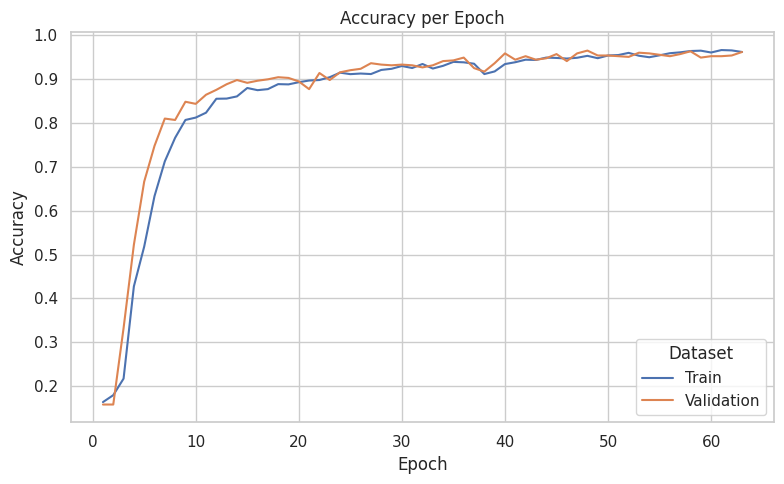

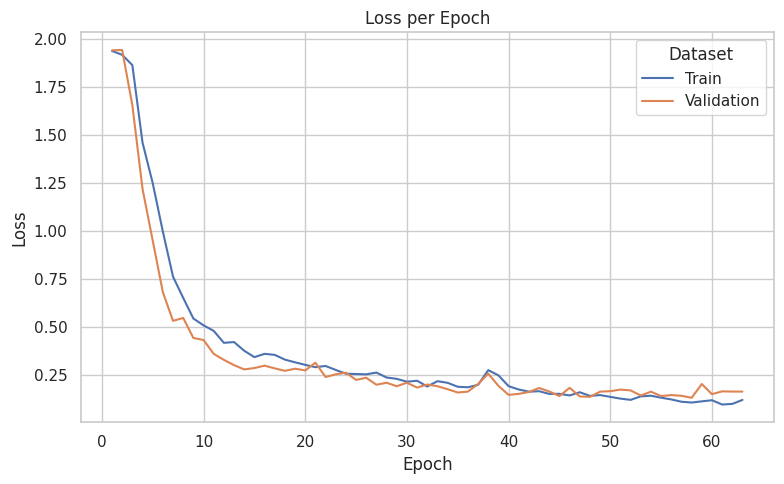

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Trains a VGG-16 from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""

import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_30ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/30ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vgg_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU detected: {gpus[0].name}")
    except RuntimeError:
        print(" GPUs already initialized; memory growth could not be configured.")
else:
    print(" GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

# build DataFrame
import pandas as pd

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
display(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL ──────────
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model = VGG16(weights=None, include_top=False,
                       input_shape=(*IMG_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


Loading model from /content/drive/MyDrive/DroneDetect_VGG/30ms/vgg_drone.h5 …


Total test samples: 627
Test set distribution:
label
AIR    99
MIN    99
MP2    99
INS    99
MP1    99
PHA    66
DIS    66
Name: count, dtype: int64 

Found 627 validated image filenames belonging to 7 classes.
Performing predictions on test set…


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



20/20 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step

Classification Report:
              precision    recall  f1-score   support

         AIR     0.9681    0.9192    0.9430        99
         DIS     1.0000    1.0000    1.0000        66
         INS     0.9792    0.9495    0.9641        99
         MIN     0.9900    1.0000    0.9950        99
         MP1     0.9785    0.9192    0.9479        99
         MP2     0.8584    0.9798    0.9151        99
         PHA     0.9846    0.9697    0.9771        66

    accuracy                         0.9601       627
   macro avg     0.9655    0.9625    0.9632       627
weighted avg     0.9627    0.9601    0.9605       627



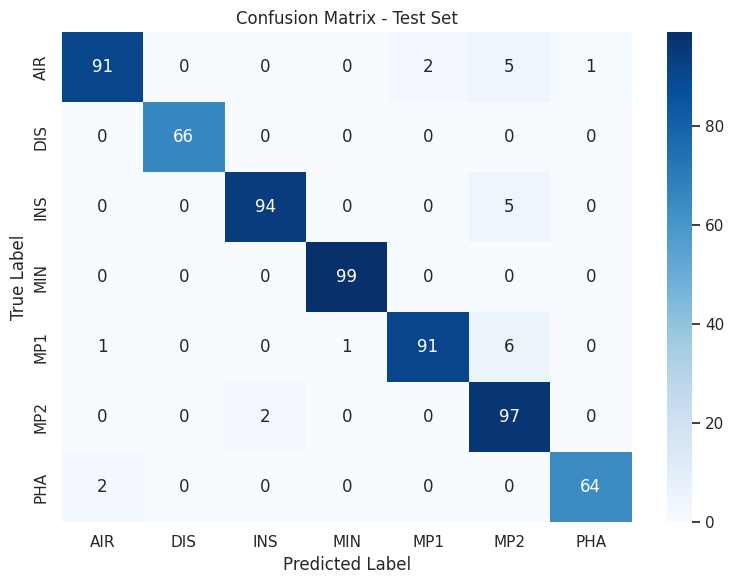

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Loads the saved "vgg_drone.h5" model, evaluates on the test split,
prints classification metrics and displays a confusion matrix using seaborn.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/30ms")
MODEL_PATH = MODEL_DIR / "vgg_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ─────────── LOAD MODEL ───────────
print(f"Loading model from {MODEL_PATH} …")
model = tf.keras.models.load_model(MODEL_PATH)

# ─────────── LOAD TEST SPLIT ───────────
test_df = pd.read_csv(TEST_CSV)
print(f"Total test samples: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts(), "\n")

# ─────────── TEST DATA GENERATOR ───────────
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    test_df,
    x_col="path", y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# ─────────── PREDICTIONS ───────────
print("Performing predictions on test set…")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes
labels = list(gen_test.class_indices.keys())

# ─────────── CLASSIFICATION REPORT ───────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# ─────────── CONFUSION MATRIX ───────────
cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# TRANSFORMER 30 ms

GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 6262
Corrupted PNGs: 0

Original distribution (post-filter):
label
AIR    990
MP1    990
MIN    990
MP2    990
INS    982
DIS    660
PHA    660
Name: count, dtype: int64

Distribution after split:
Train     :
label
MIN    792
AIR    792
MP1    792
MP2    792
INS    785
DIS    528
PHA    528
Name: count, dtype: int64
Validation:
label
MP1    99
MP2    99
AIR    99
MIN    99
INS    98
PHA    66
DIS    66
Name: count, dtype: int64
Test      :
label
AIR    99
MIN    99
MP2    99
INS    99
MP1    99
PHA    66
DIS    66
Name: count, dtype: int64
Found 5009 validated image filenames belonging to 7 classes.
Found 626 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


Model: "ViT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 14, 14,    │     49,216 │ input_layer_4[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_patches     │ (None, 196, 64)   │          0 │ patch_embedding[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ reshape_patches[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block0          │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block0         │ (None, 196, 64)   │     66,368 │ ln1_block0[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block0[0][0… │
│ (Add)               │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block0          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block0 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block0 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block0 │ (None, 196, 64)   │          0 │ mlp2_block0[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block1          │ (None, 196, 64)   │        128 │ residual_mlp_blo… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block1         │ (None, 196, 64)   │     66,368 │ ln1_block1[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block1[0][0… │
│ (Add)               │                   │            │ residual_mlp_blo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block1          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block1 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block1 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block1 │ (None, 196, 64)   │          0 │ mlp2_block1[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 715,399 (2.73 MB)

 Trainable params: 715,399 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.23482, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 106s - 675ms/step - accuracy: 0.1855 - loss: 2.3031 - val_accuracy: 0.2348 - val_loss: 1.7657
Epoch 2/100



Epoch 2: val_accuracy improved from 0.23482 to 0.37220, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 64s - 409ms/step - accuracy: 0.2867 - loss: 1.9021 - val_accuracy: 0.3722 - val_loss: 1.5794
Epoch 3/100



Epoch 3: val_accuracy improved from 0.37220 to 0.50000, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 64s - 407ms/step - accuracy: 0.3847 - loss: 1.6192 - val_accuracy: 0.5000 - val_loss: 1.3302
Epoch 4/100



Epoch 4: val_accuracy improved from 0.50000 to 0.53994, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 63s - 403ms/step - accuracy: 0.4622 - loss: 1.4102 - val_accuracy: 0.5399 - val_loss: 1.1602
Epoch 5/100



Epoch 5: val_accuracy improved from 0.53994 to 0.61022, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 66s - 422ms/step - accuracy: 0.5059 - loss: 1.2890 - val_accuracy: 0.6102 - val_loss: 1.0241
Epoch 6/100



Epoch 6: val_accuracy improved from 0.61022 to 0.65176, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 412ms/step - accuracy: 0.5566 - loss: 1.1688 - val_accuracy: 0.6518 - val_loss: 0.9212
Epoch 7/100



Epoch 7: val_accuracy improved from 0.65176 to 0.67252, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 75s - 478ms/step - accuracy: 0.5985 - loss: 1.0727 - val_accuracy: 0.6725 - val_loss: 0.8738
Epoch 8/100



Epoch 8: val_accuracy improved from 0.67252 to 0.71086, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 66s - 418ms/step - accuracy: 0.6321 - loss: 0.9953 - val_accuracy: 0.7109 - val_loss: 0.7820
Epoch 9/100



Epoch 9: val_accuracy improved from 0.71086 to 0.71725, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 68s - 430ms/step - accuracy: 0.6580 - loss: 0.9423 - val_accuracy: 0.7173 - val_loss: 0.7566
Epoch 10/100



Epoch 10: val_accuracy improved from 0.71725 to 0.73482, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 416ms/step - accuracy: 0.6834 - loss: 0.8888 - val_accuracy: 0.7348 - val_loss: 0.7087
Epoch 11/100



Epoch 11: val_accuracy improved from 0.73482 to 0.73642, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 414ms/step - accuracy: 0.6872 - loss: 0.8833 - val_accuracy: 0.7364 - val_loss: 0.7294
Epoch 12/100



Epoch 12: val_accuracy improved from 0.73642 to 0.78275, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 66s - 420ms/step - accuracy: 0.7157 - loss: 0.8051 - val_accuracy: 0.7827 - val_loss: 0.6025
Epoch 13/100



Epoch 13: val_accuracy improved from 0.78275 to 0.79233, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 414ms/step - accuracy: 0.7219 - loss: 0.8007 - val_accuracy: 0.7923 - val_loss: 0.5893
Epoch 14/100



Epoch 14: val_accuracy did not improve from 0.79233
157/157 - 65s - 412ms/step - accuracy: 0.7307 - loss: 0.7729 - val_accuracy: 0.7875 - val_loss: 0.5902
Epoch 15/100



Epoch 15: val_accuracy did not improve from 0.79233
157/157 - 63s - 402ms/step - accuracy: 0.7469 - loss: 0.7375 - val_accuracy: 0.7827 - val_loss: 0.5864
Epoch 16/100



Epoch 16: val_accuracy improved from 0.79233 to 0.81310, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 412ms/step - accuracy: 0.7465 - loss: 0.7165 - val_accuracy: 0.8131 - val_loss: 0.5353
Epoch 17/100



Epoch 17: val_accuracy improved from 0.81310 to 0.81949, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 413ms/step - accuracy: 0.7578 - loss: 0.7030 - val_accuracy: 0.8195 - val_loss: 0.5352
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.81949
157/157 - 64s - 405ms/step - accuracy: 0.7570 - loss: 0.7117 - val_accuracy: 0.7939 - val_loss: 0.6037
Epoch 19/100



Epoch 19: val_accuracy improved from 0.81949 to 0.84185, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 414ms/step - accuracy: 0.7766 - loss: 0.6548 - val_accuracy: 0.8419 - val_loss: 0.4739
Epoch 20/100



Epoch 20: val_accuracy did not improve from 0.84185
157/157 - 63s - 402ms/step - accuracy: 0.7910 - loss: 0.6218 - val_accuracy: 0.8387 - val_loss: 0.5024
Epoch 21/100



Epoch 21: val_accuracy improved from 0.84185 to 0.84665, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 413ms/step - accuracy: 0.7840 - loss: 0.6359 - val_accuracy: 0.8466 - val_loss: 0.4717
Epoch 22/100



Epoch 22: val_accuracy did not improve from 0.84665
157/157 - 64s - 410ms/step - accuracy: 0.7954 - loss: 0.6090 - val_accuracy: 0.8355 - val_loss: 0.4783
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.84665
157/157 - 63s - 403ms/step - accuracy: 0.7954 - loss: 0.5975 - val_accuracy: 0.8435 - val_loss: 0.4643
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.84665
157/157 - 63s - 404ms/step - accuracy: 0.8032 - loss: 0.5758 - val_accuracy: 0.8466 - val_loss: 0.4587
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.84665
157/157 - 65s - 411ms/step - accuracy: 0.8107 - loss: 0.5643 - val_accuracy: 0.8211 - val_loss: 0.5048
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.84665
157/157 - 64s - 409ms/step - accuracy: 0.8165 - loss: 0.5459 - val_accuracy: 0.8466 - val_loss: 0.4272
Epoch 27/100



Epoch 27: val_accuracy improved from 0.84665 to 0.84984, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 68s - 432ms/step - accuracy: 0.8281 - loss: 0.5289 - val_accuracy: 0.8498 - val_loss: 0.4243
Epoch 28/100



Epoch 28: val_accuracy did not improve from 0.84984
157/157 - 65s - 411ms/step - accuracy: 0.8189 - loss: 0.5146 - val_accuracy: 0.8435 - val_loss: 0.4371
Epoch 29/100



Epoch 29: val_accuracy improved from 0.84984 to 0.86102, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 66s - 420ms/step - accuracy: 0.8337 - loss: 0.4872 - val_accuracy: 0.8610 - val_loss: 0.3949
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.86102
157/157 - 64s - 409ms/step - accuracy: 0.8405 - loss: 0.4716 - val_accuracy: 0.8419 - val_loss: 0.4101
Epoch 31/100



Epoch 31: val_accuracy improved from 0.86102 to 0.88019, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 64s - 408ms/step - accuracy: 0.8401 - loss: 0.4728 - val_accuracy: 0.8802 - val_loss: 0.3653
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.88019
157/157 - 63s - 400ms/step - accuracy: 0.8351 - loss: 0.4794 - val_accuracy: 0.8578 - val_loss: 0.4017
Epoch 33/100



Epoch 33: val_accuracy did not improve from 0.88019
157/157 - 62s - 397ms/step - accuracy: 0.8493 - loss: 0.4465 - val_accuracy: 0.8626 - val_loss: 0.4126
Epoch 34/100



Epoch 34: val_accuracy improved from 0.88019 to 0.88339, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 64s - 411ms/step - accuracy: 0.8479 - loss: 0.4465 - val_accuracy: 0.8834 - val_loss: 0.3561
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.88339
157/157 - 63s - 404ms/step - accuracy: 0.8497 - loss: 0.4424 - val_accuracy: 0.8690 - val_loss: 0.3654
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.88339
157/157 - 63s - 401ms/step - accuracy: 0.8587 - loss: 0.4126 - val_accuracy: 0.8802 - val_loss: 0.3335
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.88339
157/157 - 63s - 404ms/step - accuracy: 0.8541 - loss: 0.4258 - val_accuracy: 0.8658 - val_loss: 0.3991
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.88339
157/157 - 63s - 402ms/step - accuracy: 0.8605 - loss: 0.4018 - val_accuracy: 0.8594 - val_loss: 0.3990
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.88339
157/157 - 63s - 403ms/step - accuracy: 0.8587 - loss: 0.4097 - val_accuracy: 0.8578 - val_loss: 0.3998
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.88339
157/157 - 64s - 406ms/step - accuracy: 0.8618 - loss: 0.4016 - val_accuracy: 0.8802 - val_loss: 0.3451
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.88339
157/157 - 65s - 416ms/step - accuracy: 0.8668 - loss: 0.3938 - val_accuracy: 0.8546 - val_loss: 0.3576
Epoch 42/100



Epoch 42: val_accuracy improved from 0.88339 to 0.88658, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 65s - 412ms/step - accuracy: 0.8640 - loss: 0.3890 - val_accuracy: 0.8866 - val_loss: 0.3201
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.88658
157/157 - 64s - 405ms/step - accuracy: 0.8706 - loss: 0.3811 - val_accuracy: 0.8706 - val_loss: 0.3520
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.88658
157/157 - 63s - 400ms/step - accuracy: 0.8700 - loss: 0.3745 - val_accuracy: 0.8770 - val_loss: 0.3614
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.88658
157/157 - 63s - 400ms/step - accuracy: 0.8694 - loss: 0.3773 - val_accuracy: 0.8690 - val_loss: 0.3512
Epoch 46/100



Epoch 46: val_accuracy improved from 0.88658 to 0.89776, saving model to /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5


157/157 - 64s - 407ms/step - accuracy: 0.8612 - loss: 0.3972 - val_accuracy: 0.8978 - val_loss: 0.3085
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.89776
157/157 - 64s - 407ms/step - accuracy: 0.8692 - loss: 0.3640 - val_accuracy: 0.8834 - val_loss: 0.3077
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.89776
157/157 - 63s - 401ms/step - accuracy: 0.8830 - loss: 0.3414 - val_accuracy: 0.8914 - val_loss: 0.3146
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.89776
157/157 - 63s - 399ms/step - accuracy: 0.8782 - loss: 0.3538 - val_accuracy: 0.8898 - val_loss: 0.3420
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.89776
157/157 - 64s - 406ms/step - accuracy: 0.8782 - loss: 0.3540 - val_accuracy: 0.8850 - val_loss: 0.3185
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.89776
157/157 - 63s - 402ms/step - accuracy: 0.8796 - loss: 0.3553 - val_accuracy: 0.8738 - val_loss: 0.3165
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.89776
157/157 - 64s - 407ms/step - accuracy: 0.8740 - loss: 0.3655 - val_accuracy: 0.8946 - val_loss: 0.2925
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.89776
157/157 - 63s - 402ms/step - accuracy: 0.8814 - loss: 0.3425 - val_accuracy: 0.8914 - val_loss: 0.3199
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.89776
157/157 - 63s - 403ms/step - accuracy: 0.8872 - loss: 0.3320 - val_accuracy: 0.8834 - val_loss: 0.3351
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.89776
157/157 - 62s - 398ms/step - accuracy: 0.8786 - loss: 0.3443 - val_accuracy: 0.8978 - val_loss: 0.3032
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.89776
157/157 - 66s - 420ms/step - accuracy: 0.8882 - loss: 0.3263 - val_accuracy: 0.8914 - val_loss: 0.3236
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.89776
157/157 - 64s - 408ms/step - accuracy: 0.8842 - loss: 0.3281 - val_accuracy: 0.8930 - val_loss: 0.2956
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.89776
157/157 - 63s - 401ms/step - accuracy: 0.8802 - loss: 0.3363 - val_accuracy: 0.8754 - val_loss: 0.3306
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.89776
157/157 - 63s - 402ms/step - accuracy: 0.8890 - loss: 0.3289 - val_accuracy: 0.8962 - val_loss: 0.2909
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.89776
157/157 - 63s - 400ms/step - accuracy: 0.8886 - loss: 0.3316 - val_accuracy: 0.8850 - val_loss: 0.3079
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.89776
157/157 - 62s - 396ms/step - accuracy: 0.8814 - loss: 0.3368 - val_accuracy: 0.8898 - val_loss: 0.3389
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 46.


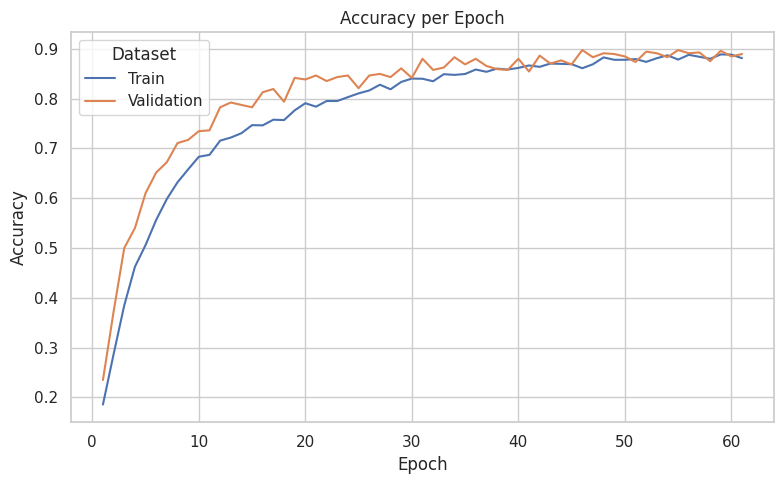

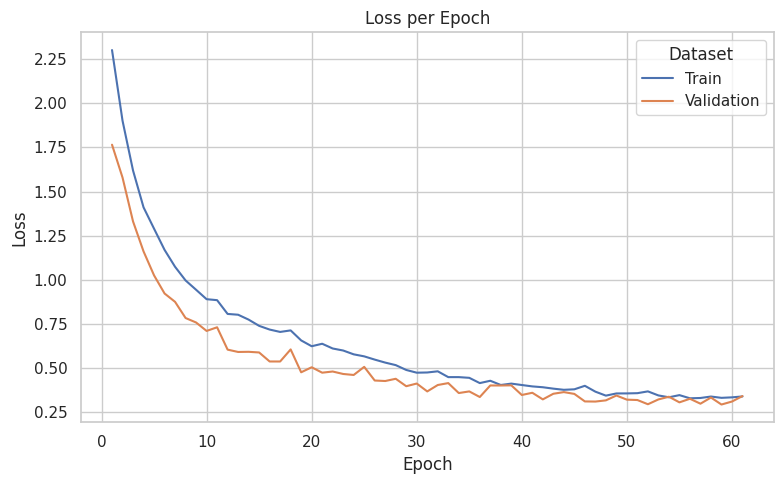

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vit_drone.py
────────────────────────────────────────────────────────────────────────
Trains a Vision Transformer from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────


ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_30ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_30ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vit_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0].name}")
    except RuntimeError:
        print("GPUs already initialized; memory growth could not be configured.")
else:
    print("GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
print(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL (USING VISION TRANSFORMER) ──────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128, transformer_layers=8,
                          dropout=0.5):
    """
    Basic Vision Transformer:
    - Extract patches via Conv2D
    - Project patches into embeddings
    - Add positional embeddings
    - Stack transformer blocks (MHSA + MLP)
    - Pool and classification head
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim), name='reshape_patches')(x)

    # 2) Positional embedding
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=n_patches,
                                     output_dim=embed_dim,
                                     name='pos_embedding')(positions)
    x = x + pos_embedding

    # 3) Transformer blocks
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln1_block{i}')(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                         key_dim=embed_dim,
                                         name=f'mhsa_block{i}')(x1, x1)
        x2 = layers.Add(name=f'residual_attn_block{i}')([attn, x])

        x3 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln2_block{i}')(x2)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(x3)
        mlp = layers.Dense(embed_dim,
                           name=f'mlp2_block{i}')(mlp)
        x = layers.Add(name=f'residual_mlp_block{i}')([mlp, x2])

    # 4) Pooling + classifier head
    x = layers.LayerNormalization(epsilon=1e-6,
                                   name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='ViT_Classifier')

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=num_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")
history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()



► Attempting to load model from /content/drive/MyDrive/DroneDetect_ViT_30ms/vit_drone.h5 …
⚠ Could not load full model (too many positional arguments). Rebuilding architecture …
✔ Weights loaded with model.load_weights().

Total test samples: 627
Test-set class distribution:
 label
AIR    99
MIN    99
MP2    99
INS    99
MP1    99
PHA    66
DIS    66
Name: count, dtype: int64 

Found 627 validated image filenames belonging to 7 classes.
► Generating predictions …


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         AIR     0.8537    0.7071    0.7735        99
         DIS     1.0000    0.9848    0.9924        66
         INS     0.8738    0.9091    0.8911        99
         MIN     0.9423    0.9899    0.9655        99
         MP1     0.8763    0.8586    0.8673        99
         MP2     0.7931    0.9293    0.8558        99
         PHA     0.9333    0.8485    0.8889        66

    accuracy                         0.8868       627
   macro avg     0.8961    0.8896    0.8906       627
weighted avg     0.8886    0.8868    0.8854       627



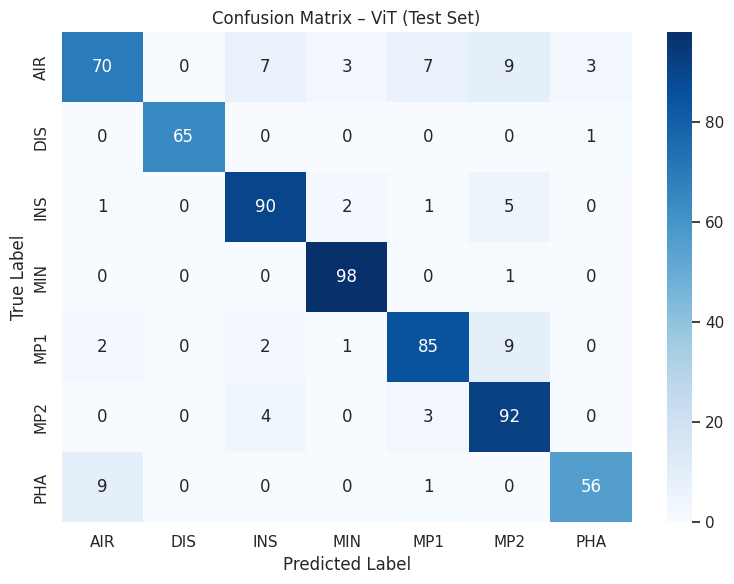

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vit_drone.py
────────────────────────────────────────────────────────────────────────
Evaluates the Vision Transformer (ViT) trained to classify drone types.

Workflow
╰─►  1) Attempts to load the full .h5 model; if that fails, rebuilds the
        architecture and loads only the weights.
     2) Generates predictions on the test split stored in test_split.csv.
     3) Prints a classification report and displays a confusion matrix
        with English titles and axis labels.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_30ms")
MODEL_PATH = MODEL_DIR / "vit_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"


IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 1) Function to rebuild the same ViT architecture used during training
# ──────────────────────────────────────────────────────────────────────────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128,
                          transformer_layers=8, dropout=0.5):
    """Minimal Vision Transformer classifier."""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim),
                       name='reshape_patches')(x)

    # Learnable positional embeddings
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_emb   = layers.Embedding(input_dim=n_patches,
                                 output_dim=embed_dim,
                                 name='pos_embedding')(positions)
    x = x + pos_emb

    # Transformer encoder blocks
    for i in range(transformer_layers):
        # Multi-head self-attention
        ln1 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln1_block{i}')(x)
        att = layers.MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim,
                                        name=f'mhsa_block{i}')(ln1, ln1)
        x   = layers.Add(name=f'residual_attn_block{i}')([att, x])

        # Feed-forward MLP
        ln2 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln2_block{i}')(x)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(ln2)
        mlp = layers.Dense(embed_dim, name=f'mlp2_block{i}')(mlp)
        x   = layers.Add(name=f'residual_mlp_block{i}')([mlp, x])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6, name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs, outputs, name='ViT_Classifier')

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load the trained model (full model or just weights)
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n► Attempting to load model from {MODEL_PATH} …")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✔ Model loaded successfully with tf.keras.models.load_model().")
except Exception as e:
    print(f"⚠ Could not load full model ({e}). Rebuilding architecture …")
    # Read test CSV to infer the number of classes
    tmp_df     = pd.read_csv(TEST_CSV)
    class_list = sorted(tmp_df["label"].unique())
    n_classes  = len(class_list)

    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=n_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.load_weights(MODEL_PATH)
    print("✔ Weights loaded with model.load_weights().")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Prepare the test data generator
# ──────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv(TEST_CSV)
print(f"\nTotal test samples: {len(test_df)}")
print("Test-set class distribution:\n", test_df["label"].value_counts(), "\n")

datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)
label_names = list(gen_test.class_indices.keys())

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluation
# ──────────────────────────────────────────────────────────────────────────────
print("► Generating predictions …")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix – ViT (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# VGG 50 ms

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
gera_espectrogramas_dronedetect.py
──────────────────────────────────
Gera 1 espectrograma STFT (224×224) por segmento de 50 ms ao longo
de TODO o arquivo .dat do DroneDetect-V2, salvando em PNG ou NumPy.

Retomável via checkpoint_MOD_50ms.pickle (set, drone, arquivo).

Estrutura esperada:
<ROOT_DIR>/<interference>/<drone>/<arquivo>.dat
Ex.: .../CLEAN/AIR_FY/AIR_0010_00.dat
"""
from __future__ import annotations

import os
import re
import pickle
import shutil
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, get_window
from tqdm.auto import tqdm

# ─────────────────── CONFIGURAÇÕES ────────────────────
ROOT_DIR: str = (
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2"
)

# ======= bloco “Specifications” =========
n_per_seg: int             = 1024          # STFT: pontos por segmento
n_overlap_spec: int        = 120           # STFT: overlap
psd_win_type: str          = "hamming"     # janela ('hamming', 'hann', ...)
t_seg_ms: int              = 50            # ★ duração de cada segmento (ms)
hop_ms: int                = 50            # ★ passo entre segmentos (ms)
feature_to_save: List[str] = ['SPEC']      # ['SPEC','PSD','RAW']
format_to_save: List[str]  = ['IMG']       # ['IMG','ARR'] ou ambas
interference_folders       = ['CLEAN']     # ['WIFI','BLUE','BOTH','CLEAN']
to_add: bool               = True          # False = recriar pasta de saída
# =======================================

FS: int        = 60_000_000               # taxa de amostragem (Hz)
DIM_PX         = (224, 224)               # tamanho imagem
DPI_IMG        = 100
FEATURES_ROOT  = ROOT_DIR + "_FEATURES_MOD_50ms"     # ★ pasta de saída
CHK_FILE       = Path(FEATURES_ROOT) / "checkpoint_MOD_50ms.pickle"
WINDOW         = get_window(psd_win_type, n_per_seg)

# Conversão ms → amostras
SAMP_SEG: int  = int(t_seg_ms / 1e3 * FS)  # 50 ms → 3 000 000 amostras
SAMP_HOP: int  = int(hop_ms  / 1e3 * FS)   # 50 ms → 3 000 000 amostras
assert SAMP_HOP > 0 and SAMP_SEG >= SAMP_HOP, "hop_ms deve ser >0 e ≤ t_seg_ms"

# ────────────────── UTILITÁRIAS ──────────────────
def load_iq(path: Path) -> np.ndarray:
    """Lê .dat (float32 intercalado) → complex64 normalizado (z-score)."""
    raw = np.fromfile(path, dtype=np.float32)
    iq  = raw.view(np.complex64)
    return (iq - iq.mean()) / (np.sqrt(iq.var() + 1e-10))

def calc_specgram(x: np.ndarray) -> np.ndarray:
    """Espectrograma (magnitude dB) mantendo apenas frequências ≥ 0."""
    _, _, Z = stft(
        x, fs=FS,
        nperseg=n_per_seg,
        noverlap=n_overlap_spec,
        window=WINDOW,
        return_onesided=False
    )
    spec = 20 * np.log10(np.abs(Z) + 1e-10)
    return spec[: spec.shape[0] // 2, :]   # corta a metade negativa

def save_png(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(DIM_PX[0]/DPI_IMG, DIM_PX[1]/DPI_IMG), dpi=DPI_IMG)
    plt.axis('off')
    plt.imshow(arr, origin='lower', aspect='auto', cmap='inferno')
    plt.savefig(folder / f"{name}.png", dpi=DPI_IMG,
                bbox_inches='tight', pad_inches=0)
    plt.close()

def save_npy(arr: np.ndarray, folder: Path, name: str):
    folder.mkdir(parents=True, exist_ok=True)
    np.save(folder / f"{name}.npy", arr.astype(np.float32))

def load_ckpt() -> Dict[str, int]:
    if CHK_FILE.exists():
        return pickle.loads(CHK_FILE.read_bytes())
    return {"set_i": 0, "drone_i": 0, "file_i": 0}

def save_ckpt(state: Dict[str, int]):
    CHK_FILE.parent.mkdir(parents=True, exist_ok=True)
    CHK_FILE.write_bytes(pickle.dumps(state))

# ───────────────────── MAIN ──────────────────────
def main():
    # Prepara pasta de saída
    if not to_add and Path(FEATURES_ROOT).exists():
        shutil.rmtree(FEATURES_ROOT)
    Path(FEATURES_ROOT).mkdir(exist_ok=True)

    ckpt = load_ckpt()

    for set_i, interf in enumerate(
        interference_folders[ckpt["set_i"]:], start=ckpt["set_i"]
    ):
        dir_set = Path(ROOT_DIR) / interf
        drone_dirs = sorted(p for p in dir_set.iterdir() if p.is_dir())

        for d_i, drone_dir in enumerate(
            drone_dirs[ckpt["drone_i"]:], start=ckpt["drone_i"]
        ):
            files = sorted(f for f in drone_dir.glob("*.dat"))

            for f_i, fpath in enumerate(
                files[ckpt["file_i"]:], start=ckpt["file_i"]
            ):
                # ---- nomes amigáveis ----
                m_fold = re.match(r"([^_]+)_(.+)", drone_dir.name)
                drone_name, cond_name = (
                    m_fold.groups() if m_fold else (drone_dir.name, "UNK")
                )

                m_file = re.match(r".*_(\d{4})_(\d{2})\.dat", fpath.name)
                fi_num, counter = (m_file.groups() if m_file else ("0000", "00"))

                # ---- processamento do arquivo ----
                iq = load_iq(fpath)
                n_segs = max(1, (len(iq) - SAMP_SEG) // SAMP_HOP + 1)

                for seg_idx in range(n_segs):
                    start = seg_idx * SAMP_HOP
                    end   = start + SAMP_SEG
                    if end > len(iq):
                        break
                    segment = iq[start:end]

                    if 'SPEC' in feature_to_save:
                        spec = calc_specgram(segment)

                    seg_tag = f"seg{seg_idx:03d}"
                    base = (
                        f"{interf}_{drone_name}_{cond_name}_"
                        f"{fi_num}_{counter}_{seg_tag}"
                    )

                    if 'IMG' in format_to_save and 'SPEC' in feature_to_save:
                        save_png(spec, Path(FEATURES_ROOT) / "IMG_SPEC", base)

                    if 'ARR' in format_to_save and 'SPEC' in feature_to_save:
                        save_npy(spec, Path(FEATURES_ROOT) / "ARR_SPEC", base)

                # ---- checkpoint: arquivo concluído ----
                ckpt.update({"set_i": set_i, "drone_i": d_i, "file_i": f_i + 1})
                save_ckpt(ckpt)

            # terminou drone
            ckpt.update({"file_i": 0, "drone_i": d_i + 1})
            save_ckpt(ckpt)

        # terminou interference set
        ckpt.update({"drone_i": 0, "set_i": set_i + 1})
        save_ckpt(ckpt)

    print("✅ Espectrogramas gerados para todos os arquivos e segmentos (50 ms).")

if __name__ == "__main__":
    main()


✅ Espectrogramas gerados para todos os arquivos e segmentos (50 ms).


In [ ]:
import os
from collections import defaultdict

# Caminho-raiz dos espectrogramas
root_dir = ("/content/drive/MyDrive/Projeto - Classificação RF/"
            "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_50ms/IMG_SPEC")

# Inicializa contadores
total = 0
por_pasta = defaultdict(int)   # {subpasta: quantidade}

# Percorre recursivamente
for dirpath, _, files in os.walk(root_dir):
    # mantém apenas imagens; ajuste conforme necessário
    imgs = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if imgs:
        rel = os.path.relpath(dirpath, root_dir)  # subpasta relativa
        por_pasta[rel] += len(imgs)
        total += len(imgs)

# Mostra resultados
print(f"Total de imagens encontradas: {total}\n")
print("Contagem por subpasta:")
for pasta, qtd in sorted(por_pasta.items()):
    print(f"  {pasta:<40} {qtd:>6}")


Total de imagens encontradas: 3795

Contagem por subpasta:
  .                                          3795


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
conta_espectrogramas_por_drone.py
─────────────────────────────────────────────────────────────────
Percorre todos os PNG/JPG sob IMG_SPEC, extrai o tipo de drone
(padrão:  <interf>_<DRONE>_<cond>_<id>_segXXX.png)
e plota a distribuição com Plotly.

Exemplo de nome: CLEAN_AIR_FY_0010_00_seg000.png
 → tipo de drone = "AIR"
"""

import os
from collections import Counter
from pathlib import Path

import pandas as pd
import plotly.express as px

# Caminho-raiz dos espectrogramas
ROOT_DIR = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_50ms/IMG_SPEC")

# ─────────── CONTAGEM ────────────
contador = Counter()

for path in ROOT_DIR.rglob("*"):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        partes = path.stem.split("_")            # divide pelo “_”
        if len(partes) >= 3:
            drone_tipo = partes[1]               # ex.: "AIR"
            contador[drone_tipo] += 1

# converte para DataFrame (mais fácil de ordenar/plotar)
df = (pd.DataFrame({"Drone": list(contador.keys()),
                    "Quantidade": list(contador.values())})
        .sort_values("Quantidade", ascending=False))

print(f"Total de imagens: {df['Quantidade'].sum()}")
display(df)

# ─────────── GRÁFICO ─────────────
fig = px.bar(df,
             x="Drone", y="Quantidade",
             text="Quantidade",
             color="Drone",
             title="Distribuição de Espectrogramas por Tipo de Drone",
             labels=dict(Drone="Tipo de Drone", Quantidade="Nº de Imagens"))

fig.update_traces(texttemplate="%{text}", textposition="outside")
fig.update_layout(yaxis=dict(title="Quantidade"),
                  xaxis=dict(title="Tipo de Drone"),
                  uniformtext_minsize=8, uniformtext_mode="hide",
                  bargap=0.25,
                  template="plotly_white")

fig.show()


Total de imagens: 3795


Drone  Quantidade
0   MIN         600
2   AIR         600
4   MP1         600
5   MP2         600
1   INS         595
3   DIS         400
6   PHA         400

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd

ROOT_IMG = Path(
    "/content/drive/MyDrive/Projeto - Classificação RF/"
    "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_50ms/IMG_SPEC"
)
MODEL_DIR = Path("/content/drive/MyDrive/DroneDetect_VGG")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

rows, bad = [], []

for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexando / validando PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()                 # detecta PNG inválido
        parts = p.stem.split("_")
        if len(parts) >= 2:
            label = parts[1]            # segundo campo → rótulo (“AIR”, …)
            rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"Imagens válidas: {len(rows)}  –  Corrompidas descartadas: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "arquivos_corrompidos.txt",
                          index=False, header=False)

df = pd.DataFrame(rows)
print("\nDistribuição original (após filtro):")
display(df["label"].value_counts())


Indexando / validando PNGs: 0it [00:00, ?it/s]

Imagens válidas: 3795  –  Corrompidas descartadas: 0

Distribuição original (após filtro):


label
MIN    600
AIR    600
MP1    600
MP2    600
INS    595
DIS    400
PHA    400
Name: count, dtype: int64

 GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 3795
Corrupted PNGs: 0

Original distribution (post-filter):


label
MP2    600
MIN    600
MP1    600
AIR    600
INS    595
PHA    400
DIS    400
Name: count, dtype: int64


Distribution after split:
Train     :
label
MP2    480
AIR    480
MP1    480
MIN    480
INS    476
DIS    320
PHA    320
Name: count, dtype: int64
Validation:
label
MIN    60
MP2    60
MP1    60
AIR    60
INS    59
PHA    40
DIS    40
Name: count, dtype: int64
Test      :
label
INS    60
MIN    60
AIR    60
MP1    60
MP2    60
PHA    40
DIS    40
Name: count, dtype: int64
Found 3036 validated image filenames belonging to 7 classes.
Found 379 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.15831, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 130s - 1s/step - accuracy: 0.1637 - loss: 1.9389 - val_accuracy: 0.1583 - val_loss: 1.9362
Epoch 2/100



Epoch 2: val_accuracy improved from 0.15831 to 0.27177, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 48s - 509ms/step - accuracy: 0.2197 - loss: 1.8617 - val_accuracy: 0.2718 - val_loss: 1.6744
Epoch 3/100



Epoch 3: val_accuracy improved from 0.27177 to 0.54617, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 52s - 552ms/step - accuracy: 0.3735 - loss: 1.5933 - val_accuracy: 0.5462 - val_loss: 1.3425
Epoch 4/100



Epoch 4: val_accuracy improved from 0.54617 to 0.55673, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 553ms/step - accuracy: 0.5046 - loss: 1.3396 - val_accuracy: 0.5567 - val_loss: 1.1034
Epoch 5/100



Epoch 5: val_accuracy improved from 0.55673 to 0.72032, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 52s - 548ms/step - accuracy: 0.5504 - loss: 1.1590 - val_accuracy: 0.7203 - val_loss: 0.8219
Epoch 6/100



Epoch 6: val_accuracy improved from 0.72032 to 0.73615, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 52s - 547ms/step - accuracy: 0.6324 - loss: 1.0022 - val_accuracy: 0.7361 - val_loss: 0.7048
Epoch 7/100



Epoch 7: val_accuracy improved from 0.73615 to 0.76253, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 556ms/step - accuracy: 0.6798 - loss: 0.8772 - val_accuracy: 0.7625 - val_loss: 0.6235
Epoch 8/100



Epoch 8: val_accuracy improved from 0.76253 to 0.77573, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 52s - 552ms/step - accuracy: 0.7131 - loss: 0.7665 - val_accuracy: 0.7757 - val_loss: 0.5404
Epoch 9/100



Epoch 9: val_accuracy improved from 0.77573 to 0.81266, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 556ms/step - accuracy: 0.7737 - loss: 0.6146 - val_accuracy: 0.8127 - val_loss: 0.4774
Epoch 10/100



Epoch 10: val_accuracy improved from 0.81266 to 0.82586, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 556ms/step - accuracy: 0.8001 - loss: 0.5499 - val_accuracy: 0.8259 - val_loss: 0.4293
Epoch 11/100



Epoch 11: val_accuracy did not improve from 0.82586
95/95 - 51s - 535ms/step - accuracy: 0.8192 - loss: 0.5048 - val_accuracy: 0.8206 - val_loss: 0.4355
Epoch 12/100



Epoch 12: val_accuracy improved from 0.82586 to 0.83641, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 47s - 498ms/step - accuracy: 0.8244 - loss: 0.4935 - val_accuracy: 0.8364 - val_loss: 0.4361
Epoch 13/100



Epoch 13: val_accuracy improved from 0.83641 to 0.85488, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 54s - 567ms/step - accuracy: 0.8340 - loss: 0.4535 - val_accuracy: 0.8549 - val_loss: 0.4046
Epoch 14/100



Epoch 14: val_accuracy improved from 0.85488 to 0.85752, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 559ms/step - accuracy: 0.8554 - loss: 0.3947 - val_accuracy: 0.8575 - val_loss: 0.3682
Epoch 15/100



Epoch 15: val_accuracy improved from 0.85752 to 0.87071, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 561ms/step - accuracy: 0.8626 - loss: 0.3911 - val_accuracy: 0.8707 - val_loss: 0.3367
Epoch 16/100



Epoch 16: val_accuracy did not improve from 0.87071
95/95 - 50s - 526ms/step - accuracy: 0.8544 - loss: 0.3915 - val_accuracy: 0.8496 - val_loss: 0.3772
Epoch 17/100



Epoch 17: val_accuracy improved from 0.87071 to 0.87863, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 48s - 508ms/step - accuracy: 0.8755 - loss: 0.3583 - val_accuracy: 0.8786 - val_loss: 0.3130
Epoch 18/100



Epoch 18: val_accuracy improved from 0.87863 to 0.88127, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 561ms/step - accuracy: 0.8860 - loss: 0.3157 - val_accuracy: 0.8813 - val_loss: 0.2765
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.88127
95/95 - 50s - 522ms/step - accuracy: 0.8949 - loss: 0.3064 - val_accuracy: 0.8760 - val_loss: 0.3209
Epoch 20/100



Epoch 20: val_accuracy improved from 0.88127 to 0.90237, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 48s - 503ms/step - accuracy: 0.8982 - loss: 0.2831 - val_accuracy: 0.9024 - val_loss: 0.2469
Epoch 21/100



Epoch 21: val_accuracy improved from 0.90237 to 0.92084, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 54s - 564ms/step - accuracy: 0.9107 - loss: 0.2619 - val_accuracy: 0.9208 - val_loss: 0.2306
Epoch 22/100



Epoch 22: val_accuracy did not improve from 0.92084
95/95 - 50s - 527ms/step - accuracy: 0.9153 - loss: 0.2336 - val_accuracy: 0.9077 - val_loss: 0.2263
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.92084
95/95 - 45s - 470ms/step - accuracy: 0.9173 - loss: 0.2387 - val_accuracy: 0.9156 - val_loss: 0.2562
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.92084
95/95 - 45s - 469ms/step - accuracy: 0.9061 - loss: 0.2561 - val_accuracy: 0.9050 - val_loss: 0.2585
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.92084
95/95 - 45s - 470ms/step - accuracy: 0.9173 - loss: 0.2363 - val_accuracy: 0.9208 - val_loss: 0.2186
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.92084
95/95 - 45s - 474ms/step - accuracy: 0.9265 - loss: 0.2143 - val_accuracy: 0.9208 - val_loss: 0.2746
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.92084
95/95 - 45s - 475ms/step - accuracy: 0.9223 - loss: 0.2149 - val_accuracy: 0.9129 - val_loss: 0.2889
Epoch 28/100



Epoch 28: val_accuracy improved from 0.92084 to 0.92348, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 48s - 509ms/step - accuracy: 0.9249 - loss: 0.2074 - val_accuracy: 0.9235 - val_loss: 0.2432
Epoch 29/100



Epoch 29: val_accuracy improved from 0.92348 to 0.93140, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 53s - 561ms/step - accuracy: 0.9328 - loss: 0.1938 - val_accuracy: 0.9314 - val_loss: 0.1985
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.93140
95/95 - 50s - 526ms/step - accuracy: 0.9328 - loss: 0.1911 - val_accuracy: 0.9261 - val_loss: 0.2038
Epoch 31/100



Epoch 31: val_accuracy did not improve from 0.93140
95/95 - 45s - 477ms/step - accuracy: 0.9348 - loss: 0.1807 - val_accuracy: 0.9235 - val_loss: 0.1965
Epoch 32/100



Epoch 32: val_accuracy did not improve from 0.93140
95/95 - 45s - 471ms/step - accuracy: 0.9361 - loss: 0.1820 - val_accuracy: 0.9314 - val_loss: 0.1866
Epoch 33/100



Epoch 33: val_accuracy improved from 0.93140 to 0.94195, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 48s - 501ms/step - accuracy: 0.9391 - loss: 0.1662 - val_accuracy: 0.9420 - val_loss: 0.1724
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.94195
95/95 - 51s - 532ms/step - accuracy: 0.9424 - loss: 0.1686 - val_accuracy: 0.9340 - val_loss: 0.1808
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.94195
95/95 - 45s - 472ms/step - accuracy: 0.9466 - loss: 0.1589 - val_accuracy: 0.9340 - val_loss: 0.2046
Epoch 36/100



Epoch 36: val_accuracy did not improve from 0.94195
95/95 - 45s - 477ms/step - accuracy: 0.9354 - loss: 0.1824 - val_accuracy: 0.9340 - val_loss: 0.2023
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.94195
95/95 - 45s - 476ms/step - accuracy: 0.9417 - loss: 0.1613 - val_accuracy: 0.9235 - val_loss: 0.2230
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.94195
95/95 - 45s - 477ms/step - accuracy: 0.9486 - loss: 0.1421 - val_accuracy: 0.9288 - val_loss: 0.2128
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.94195
95/95 - 45s - 473ms/step - accuracy: 0.9513 - loss: 0.1437 - val_accuracy: 0.9314 - val_loss: 0.1927
Epoch 40/100



Epoch 40: val_accuracy did not improve from 0.94195
95/95 - 45s - 478ms/step - accuracy: 0.9493 - loss: 0.1510 - val_accuracy: 0.9314 - val_loss: 0.1972
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.94195
95/95 - 45s - 474ms/step - accuracy: 0.9480 - loss: 0.1610 - val_accuracy: 0.9367 - val_loss: 0.1754
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.94195
95/95 - 45s - 472ms/step - accuracy: 0.9552 - loss: 0.1294 - val_accuracy: 0.9129 - val_loss: 0.2270
Epoch 43/100



Epoch 43: val_accuracy improved from 0.94195 to 0.94459, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 49s - 513ms/step - accuracy: 0.9608 - loss: 0.1167 - val_accuracy: 0.9446 - val_loss: 0.1724
Epoch 44/100



Epoch 44: val_accuracy did not improve from 0.94459
95/95 - 50s - 523ms/step - accuracy: 0.9667 - loss: 0.0948 - val_accuracy: 0.9367 - val_loss: 0.1784
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.94459
95/95 - 45s - 472ms/step - accuracy: 0.9634 - loss: 0.1099 - val_accuracy: 0.9314 - val_loss: 0.2134
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.94459
95/95 - 45s - 469ms/step - accuracy: 0.9555 - loss: 0.1126 - val_accuracy: 0.9420 - val_loss: 0.1903
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.94459
95/95 - 44s - 466ms/step - accuracy: 0.9615 - loss: 0.1060 - val_accuracy: 0.9340 - val_loss: 0.1890
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.94459
95/95 - 45s - 472ms/step - accuracy: 0.9598 - loss: 0.1225 - val_accuracy: 0.9446 - val_loss: 0.1703
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.94459
95/95 - 46s - 480ms/step - accuracy: 0.9641 - loss: 0.1006 - val_accuracy: 0.9446 - val_loss: 0.1682
Epoch 50/100



Epoch 50: val_accuracy improved from 0.94459 to 0.94987, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 48s - 503ms/step - accuracy: 0.9661 - loss: 0.0944 - val_accuracy: 0.9499 - val_loss: 0.1688
Epoch 51/100



Epoch 51: val_accuracy did not improve from 0.94987
95/95 - 50s - 531ms/step - accuracy: 0.9687 - loss: 0.0980 - val_accuracy: 0.9261 - val_loss: 0.2528
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.94987
95/95 - 45s - 475ms/step - accuracy: 0.9648 - loss: 0.1024 - val_accuracy: 0.9367 - val_loss: 0.1977
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.94987
95/95 - 45s - 474ms/step - accuracy: 0.9634 - loss: 0.1025 - val_accuracy: 0.9446 - val_loss: 0.1532
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.94987
95/95 - 45s - 474ms/step - accuracy: 0.9707 - loss: 0.0761 - val_accuracy: 0.9367 - val_loss: 0.2240
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.94987
95/95 - 46s - 480ms/step - accuracy: 0.9615 - loss: 0.1061 - val_accuracy: 0.9393 - val_loss: 0.2134
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.94987
95/95 - 45s - 476ms/step - accuracy: 0.9697 - loss: 0.0898 - val_accuracy: 0.9472 - val_loss: 0.1622
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.94987
95/95 - 46s - 480ms/step - accuracy: 0.9681 - loss: 0.0888 - val_accuracy: 0.9393 - val_loss: 0.2220
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.94987
95/95 - 45s - 475ms/step - accuracy: 0.9690 - loss: 0.0812 - val_accuracy: 0.9393 - val_loss: 0.2607
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.94987
95/95 - 46s - 482ms/step - accuracy: 0.9565 - loss: 0.1322 - val_accuracy: 0.9314 - val_loss: 0.1573
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.94987
95/95 - 46s - 479ms/step - accuracy: 0.9700 - loss: 0.0928 - val_accuracy: 0.9420 - val_loss: 0.1744
Epoch 61/100



Epoch 61: val_accuracy did not improve from 0.94987
95/95 - 45s - 476ms/step - accuracy: 0.9707 - loss: 0.0769 - val_accuracy: 0.9261 - val_loss: 0.2395
Epoch 62/100



Epoch 62: val_accuracy improved from 0.94987 to 0.96306, saving model to /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5


95/95 - 47s - 498ms/step - accuracy: 0.9766 - loss: 0.0650 - val_accuracy: 0.9631 - val_loss: 0.1575
Epoch 63/100



Epoch 63: val_accuracy did not improve from 0.96306
95/95 - 49s - 518ms/step - accuracy: 0.9736 - loss: 0.0721 - val_accuracy: 0.9314 - val_loss: 0.2308
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.96306
95/95 - 45s - 469ms/step - accuracy: 0.9720 - loss: 0.0796 - val_accuracy: 0.9393 - val_loss: 0.1713
Epoch 65/100



Epoch 65: val_accuracy did not improve from 0.96306
95/95 - 45s - 478ms/step - accuracy: 0.9720 - loss: 0.0752 - val_accuracy: 0.9314 - val_loss: 0.1771
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.96306
95/95 - 45s - 472ms/step - accuracy: 0.9730 - loss: 0.0813 - val_accuracy: 0.9499 - val_loss: 0.1779
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.96306
95/95 - 45s - 473ms/step - accuracy: 0.9766 - loss: 0.0622 - val_accuracy: 0.9578 - val_loss: 0.1736
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.96306
95/95 - 45s - 469ms/step - accuracy: 0.9750 - loss: 0.0738 - val_accuracy: 0.9261 - val_loss: 0.2258
Epoch 69/100



Epoch 69: val_accuracy did not improve from 0.96306
95/95 - 45s - 471ms/step - accuracy: 0.9720 - loss: 0.0749 - val_accuracy: 0.9446 - val_loss: 0.1819
Epoch 70/100



Epoch 70: val_accuracy did not improve from 0.96306
95/95 - 45s - 475ms/step - accuracy: 0.9723 - loss: 0.0744 - val_accuracy: 0.9340 - val_loss: 0.2201
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.96306
95/95 - 44s - 468ms/step - accuracy: 0.9743 - loss: 0.0815 - val_accuracy: 0.9472 - val_loss: 0.1628
Epoch 72/100



Epoch 72: val_accuracy did not improve from 0.96306
95/95 - 44s - 467ms/step - accuracy: 0.9829 - loss: 0.0475 - val_accuracy: 0.9472 - val_loss: 0.2229
Epoch 73/100



Epoch 73: val_accuracy did not improve from 0.96306
95/95 - 45s - 470ms/step - accuracy: 0.9756 - loss: 0.0767 - val_accuracy: 0.9077 - val_loss: 0.2601
Epoch 74/100



Epoch 74: val_accuracy did not improve from 0.96306
95/95 - 44s - 466ms/step - accuracy: 0.9723 - loss: 0.0740 - val_accuracy: 0.9261 - val_loss: 0.2718
Epoch 75/100



Epoch 75: val_accuracy did not improve from 0.96306
95/95 - 45s - 472ms/step - accuracy: 0.9756 - loss: 0.0728 - val_accuracy: 0.9340 - val_loss: 0.2185
Epoch 76/100



Epoch 76: val_accuracy did not improve from 0.96306
95/95 - 45s - 472ms/step - accuracy: 0.9671 - loss: 0.0826 - val_accuracy: 0.9393 - val_loss: 0.2588
Epoch 77/100



Epoch 77: val_accuracy did not improve from 0.96306
95/95 - 44s - 467ms/step - accuracy: 0.9766 - loss: 0.0577 - val_accuracy: 0.9288 - val_loss: 0.2924
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 62.


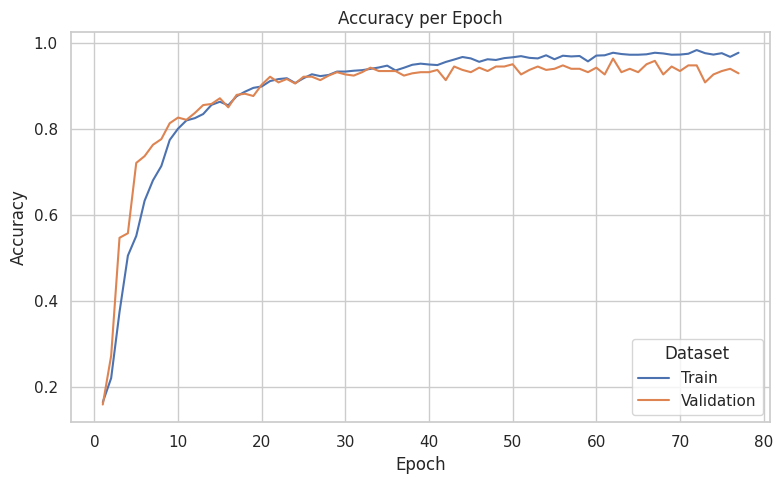

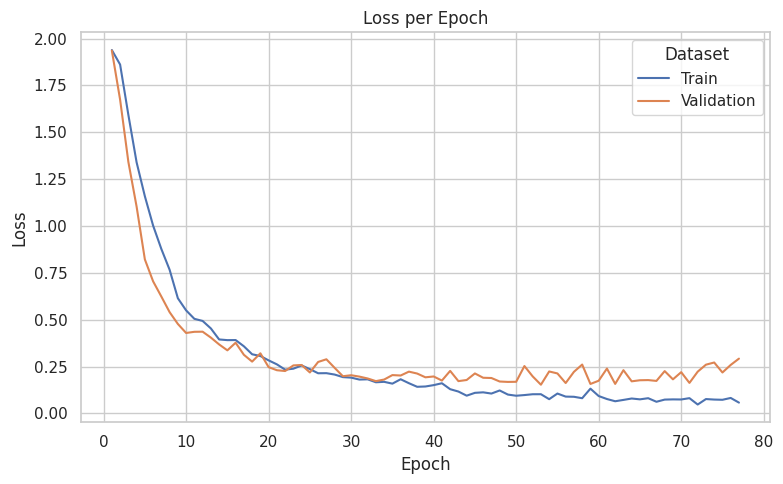

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Trains a VGG-16 from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""

import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────
ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_50ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/50ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vgg_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU detected: {gpus[0].name}")
    except RuntimeError:
        print(" GPUs already initialized; memory growth could not be configured.")
else:
    print(" GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

# build DataFrame
import pandas as pd

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
display(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL ──────────
strategy = tf.distribute.get_strategy()
with strategy.scope():
    base_model = VGG16(weights=None, include_top=False,
                       input_shape=(*IMG_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")

history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


Loading model from /content/drive/MyDrive/DroneDetect_VGG/50ms/vgg_drone.h5 …


Total test samples: 380
Test set distribution:
label
INS    60
MIN    60
AIR    60
MP1    60
MP2    60
PHA    40
DIS    40
Name: count, dtype: int64 

Found 380 validated image filenames belonging to 7 classes.
Performing predictions on test set…


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step   

Classification Report:
              precision    recall  f1-score   support

         AIR     0.9655    0.9333    0.9492        60
         DIS     1.0000    1.0000    1.0000        40
         INS     0.9508    0.9667    0.9587        60
         MIN     1.0000    1.0000    1.0000        60
         MP1     0.9333    0.9333    0.9333        60
         MP2     0.9344    0.9500    0.9421        60
         PHA     1.0000    1.0000    1.0000        40

    accuracy                         0.9658       380
   macro avg     0.9692    0.9690    0.9690       380
weighted avg     0.9659    0.9658    0.9658       380



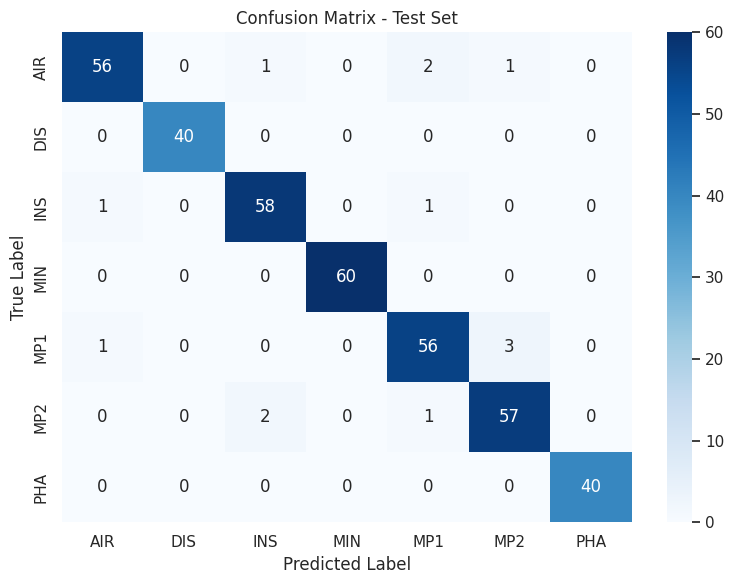

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vgg_drone.py
────────────────────────────────────────────────────────────────────────
Loads the saved "vgg_drone.h5" model, evaluates on the test split,
prints classification metrics and displays a confusion matrix using seaborn.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_VGG/50ms")
MODEL_PATH = MODEL_DIR / "vgg_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ─────────── LOAD MODEL ───────────
print(f"Loading model from {MODEL_PATH} …")
model = tf.keras.models.load_model(MODEL_PATH)

# ─────────── LOAD TEST SPLIT ───────────
test_df = pd.read_csv(TEST_CSV)
print(f"Total test samples: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts(), "\n")

# ─────────── TEST DATA GENERATOR ───────────
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    test_df,
    x_col="path", y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# ─────────── PREDICTIONS ───────────
print("Performing predictions on test set…")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes
labels = list(gen_test.class_indices.keys())

# ─────────── CLASSIFICATION REPORT ───────────
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# ─────────── CONFUSION MATRIX ───────────
cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# TRANSFORMER 50 ms

GPU detected: /physical_device:GPU:0


Indexing/validating PNGs: 0it [00:00, ?it/s]


Valid images: 3795
Corrupted PNGs: 0

Original distribution (post-filter):
label
MP2    600
MIN    600
MP1    600
AIR    600
INS    595
PHA    400
DIS    400
Name: count, dtype: int64

Distribution after split:
Train     :
label
MP2    480
AIR    480
MP1    480
MIN    480
INS    476
DIS    320
PHA    320
Name: count, dtype: int64
Validation:
label
MIN    60
MP2    60
MP1    60
AIR    60
INS    59
PHA    40
DIS    40
Name: count, dtype: int64
Test      :
label
INS    60
MIN    60
AIR    60
MP1    60
MP2    60
PHA    40
DIS    40
Name: count, dtype: int64
Found 3036 validated image filenames belonging to 7 classes.
Found 379 validated image filenames belonging to 7 classes.

Classes → indices: {'AIR': 0, 'DIS': 1, 'INS': 2, 'MIN': 3, 'MP1': 4, 'MP2': 5, 'PHA': 6}


Model: "ViT_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 14, 14,    │     49,216 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_patches     │ (None, 196, 64)   │          0 │ patch_embedding[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ reshape_patches[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block0          │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block0         │ (None, 196, 64)   │     66,368 │ ln1_block0[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block0[0][0… │
│ (Add)               │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block0          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block0 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block0 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block0 │ (None, 196, 64)   │          0 │ mlp2_block0[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_block1          │ (None, 196, 64)   │        128 │ residual_mlp_blo… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhsa_block1         │ (None, 196, 64)   │     66,368 │ ln1_block1[0][0], │
│ (MultiHeadAttentio… │                   │            │ ln1_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_attn_bloc… │ (None, 196, 64)   │          0 │ mhsa_block1[0][0… │
│ (Add)               │                   │            │ residual_mlp_blo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_block1          │ (None, 196, 64)   │        128 │ residual_attn_bl… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp1_block1 (Dense) │ (None, 196, 128)  │      8,320 │ ln2_block1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp2_block1 (Dense) │ (None, 196, 64)   │      8,256 │ mlp1_block1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_mlp_block1 │ (None, 196, 64)   │          0 │ mlp2_block1[0][0… │
│ (Add)               │                   │            │ residual_attn_bl… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 715,399 (2.73 MB)

 Trainable params: 715,399 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100



Epoch 1: val_accuracy improved from -inf to 0.23483, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 82s - 864ms/step - accuracy: 0.1693 - loss: 2.4604 - val_accuracy: 0.2348 - val_loss: 1.8370
Epoch 2/100



Epoch 2: val_accuracy did not improve from 0.23483
95/95 - 39s - 411ms/step - accuracy: 0.2121 - loss: 2.2059 - val_accuracy: 0.2058 - val_loss: 1.8598
Epoch 3/100



Epoch 3: val_accuracy improved from 0.23483 to 0.31135, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 429ms/step - accuracy: 0.2549 - loss: 2.0048 - val_accuracy: 0.3113 - val_loss: 1.6221
Epoch 4/100



Epoch 4: val_accuracy improved from 0.31135 to 0.42744, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 423ms/step - accuracy: 0.3465 - loss: 1.7000 - val_accuracy: 0.4274 - val_loss: 1.4075
Epoch 5/100



Epoch 5: val_accuracy improved from 0.42744 to 0.43272, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 420ms/step - accuracy: 0.3653 - loss: 1.6212 - val_accuracy: 0.4327 - val_loss: 1.4087
Epoch 6/100



Epoch 6: val_accuracy improved from 0.43272 to 0.44591, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 422ms/step - accuracy: 0.4009 - loss: 1.5153 - val_accuracy: 0.4459 - val_loss: 1.3916
Epoch 7/100



Epoch 7: val_accuracy improved from 0.44591 to 0.49868, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 425ms/step - accuracy: 0.4078 - loss: 1.4752 - val_accuracy: 0.4987 - val_loss: 1.2430
Epoch 8/100



Epoch 8: val_accuracy improved from 0.49868 to 0.57256, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 423ms/step - accuracy: 0.4466 - loss: 1.3923 - val_accuracy: 0.5726 - val_loss: 1.1877
Epoch 9/100



Epoch 9: val_accuracy improved from 0.57256 to 0.58311, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 424ms/step - accuracy: 0.5033 - loss: 1.2817 - val_accuracy: 0.5831 - val_loss: 1.0884
Epoch 10/100



Epoch 10: val_accuracy improved from 0.58311 to 0.59894, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 433ms/step - accuracy: 0.5339 - loss: 1.1978 - val_accuracy: 0.5989 - val_loss: 1.0827
Epoch 11/100



Epoch 11: val_accuracy improved from 0.59894 to 0.65699, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 434ms/step - accuracy: 0.5511 - loss: 1.1760 - val_accuracy: 0.6570 - val_loss: 0.9485
Epoch 12/100



Epoch 12: val_accuracy did not improve from 0.65699
95/95 - 39s - 412ms/step - accuracy: 0.5771 - loss: 1.1119 - val_accuracy: 0.6570 - val_loss: 0.9249
Epoch 13/100



Epoch 13: val_accuracy did not improve from 0.65699
95/95 - 39s - 412ms/step - accuracy: 0.5922 - loss: 1.0638 - val_accuracy: 0.6517 - val_loss: 0.9501
Epoch 14/100



Epoch 14: val_accuracy improved from 0.65699 to 0.69129, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 428ms/step - accuracy: 0.6064 - loss: 1.0274 - val_accuracy: 0.6913 - val_loss: 0.8521
Epoch 15/100



Epoch 15: val_accuracy improved from 0.69129 to 0.69657, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 432ms/step - accuracy: 0.6252 - loss: 0.9865 - val_accuracy: 0.6966 - val_loss: 0.8295
Epoch 16/100



Epoch 16: val_accuracy improved from 0.69657 to 0.71240, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 432ms/step - accuracy: 0.6238 - loss: 0.9792 - val_accuracy: 0.7124 - val_loss: 0.7956
Epoch 17/100



Epoch 17: val_accuracy improved from 0.71240 to 0.71504, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 429ms/step - accuracy: 0.6528 - loss: 0.9444 - val_accuracy: 0.7150 - val_loss: 0.7772
Epoch 18/100



Epoch 18: val_accuracy did not improve from 0.71504
95/95 - 40s - 425ms/step - accuracy: 0.6397 - loss: 0.9514 - val_accuracy: 0.6596 - val_loss: 0.8804
Epoch 19/100



Epoch 19: val_accuracy did not improve from 0.71504
95/95 - 40s - 417ms/step - accuracy: 0.6555 - loss: 0.9205 - val_accuracy: 0.7098 - val_loss: 0.7939
Epoch 20/100



Epoch 20: val_accuracy improved from 0.71504 to 0.73615, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 429ms/step - accuracy: 0.6637 - loss: 0.9057 - val_accuracy: 0.7361 - val_loss: 0.7640
Epoch 21/100



Epoch 21: val_accuracy did not improve from 0.73615
95/95 - 39s - 409ms/step - accuracy: 0.6696 - loss: 0.8855 - val_accuracy: 0.7150 - val_loss: 0.7180
Epoch 22/100



Epoch 22: val_accuracy improved from 0.73615 to 0.76781, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 416ms/step - accuracy: 0.6851 - loss: 0.8732 - val_accuracy: 0.7678 - val_loss: 0.6749
Epoch 23/100



Epoch 23: val_accuracy did not improve from 0.76781
95/95 - 38s - 404ms/step - accuracy: 0.6779 - loss: 0.8649 - val_accuracy: 0.7573 - val_loss: 0.6982
Epoch 24/100



Epoch 24: val_accuracy did not improve from 0.76781
95/95 - 39s - 407ms/step - accuracy: 0.6877 - loss: 0.8462 - val_accuracy: 0.7599 - val_loss: 0.6709
Epoch 25/100



Epoch 25: val_accuracy did not improve from 0.76781
95/95 - 39s - 412ms/step - accuracy: 0.7088 - loss: 0.8058 - val_accuracy: 0.7388 - val_loss: 0.7239
Epoch 26/100



Epoch 26: val_accuracy did not improve from 0.76781
95/95 - 39s - 415ms/step - accuracy: 0.7118 - loss: 0.8094 - val_accuracy: 0.7678 - val_loss: 0.6488
Epoch 27/100



Epoch 27: val_accuracy did not improve from 0.76781
95/95 - 39s - 413ms/step - accuracy: 0.7177 - loss: 0.7719 - val_accuracy: 0.7678 - val_loss: 0.6347
Epoch 28/100



Epoch 28: val_accuracy improved from 0.76781 to 0.77309, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 418ms/step - accuracy: 0.7388 - loss: 0.7373 - val_accuracy: 0.7731 - val_loss: 0.6562
Epoch 29/100



Epoch 29: val_accuracy did not improve from 0.77309
95/95 - 38s - 405ms/step - accuracy: 0.7339 - loss: 0.7269 - val_accuracy: 0.7599 - val_loss: 0.6188
Epoch 30/100



Epoch 30: val_accuracy did not improve from 0.77309
95/95 - 39s - 405ms/step - accuracy: 0.7480 - loss: 0.7124 - val_accuracy: 0.7625 - val_loss: 0.6271
Epoch 31/100



Epoch 31: val_accuracy improved from 0.77309 to 0.78364, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 39s - 412ms/step - accuracy: 0.7490 - loss: 0.7038 - val_accuracy: 0.7836 - val_loss: 0.5792
Epoch 32/100



Epoch 32: val_accuracy improved from 0.78364 to 0.78892, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 419ms/step - accuracy: 0.7675 - loss: 0.6631 - val_accuracy: 0.7889 - val_loss: 0.5599
Epoch 33/100



Epoch 33: val_accuracy improved from 0.78892 to 0.81003, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 420ms/step - accuracy: 0.7645 - loss: 0.6765 - val_accuracy: 0.8100 - val_loss: 0.5412
Epoch 34/100



Epoch 34: val_accuracy did not improve from 0.81003
95/95 - 38s - 402ms/step - accuracy: 0.7635 - loss: 0.6730 - val_accuracy: 0.7757 - val_loss: 0.5927
Epoch 35/100



Epoch 35: val_accuracy did not improve from 0.81003
95/95 - 39s - 406ms/step - accuracy: 0.7698 - loss: 0.6240 - val_accuracy: 0.8021 - val_loss: 0.5376
Epoch 36/100



Epoch 36: val_accuracy improved from 0.81003 to 0.81530, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 42s - 443ms/step - accuracy: 0.7902 - loss: 0.5992 - val_accuracy: 0.8153 - val_loss: 0.4985
Epoch 37/100



Epoch 37: val_accuracy did not improve from 0.81530
95/95 - 40s - 417ms/step - accuracy: 0.7866 - loss: 0.6167 - val_accuracy: 0.7810 - val_loss: 0.5954
Epoch 38/100



Epoch 38: val_accuracy did not improve from 0.81530
95/95 - 39s - 409ms/step - accuracy: 0.8027 - loss: 0.5668 - val_accuracy: 0.8047 - val_loss: 0.5109
Epoch 39/100



Epoch 39: val_accuracy did not improve from 0.81530
95/95 - 39s - 409ms/step - accuracy: 0.7994 - loss: 0.5728 - val_accuracy: 0.8047 - val_loss: 0.5372
Epoch 40/100



Epoch 40: val_accuracy improved from 0.81530 to 0.84697, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 430ms/step - accuracy: 0.8129 - loss: 0.5418 - val_accuracy: 0.8470 - val_loss: 0.4564
Epoch 41/100



Epoch 41: val_accuracy did not improve from 0.84697
95/95 - 39s - 413ms/step - accuracy: 0.8080 - loss: 0.5476 - val_accuracy: 0.8417 - val_loss: 0.4572
Epoch 42/100



Epoch 42: val_accuracy did not improve from 0.84697
95/95 - 38s - 401ms/step - accuracy: 0.8136 - loss: 0.5231 - val_accuracy: 0.8417 - val_loss: 0.4448
Epoch 43/100



Epoch 43: val_accuracy did not improve from 0.84697
95/95 - 39s - 408ms/step - accuracy: 0.8159 - loss: 0.5197 - val_accuracy: 0.8364 - val_loss: 0.4609
Epoch 44/100



Epoch 44: val_accuracy improved from 0.84697 to 0.85224, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 419ms/step - accuracy: 0.8221 - loss: 0.5155 - val_accuracy: 0.8522 - val_loss: 0.4234
Epoch 45/100



Epoch 45: val_accuracy did not improve from 0.85224
95/95 - 39s - 409ms/step - accuracy: 0.8146 - loss: 0.5245 - val_accuracy: 0.8364 - val_loss: 0.4578
Epoch 46/100



Epoch 46: val_accuracy did not improve from 0.85224
95/95 - 40s - 417ms/step - accuracy: 0.8258 - loss: 0.4904 - val_accuracy: 0.8338 - val_loss: 0.4630
Epoch 47/100



Epoch 47: val_accuracy did not improve from 0.85224
95/95 - 40s - 417ms/step - accuracy: 0.8231 - loss: 0.4974 - val_accuracy: 0.8364 - val_loss: 0.4540
Epoch 48/100



Epoch 48: val_accuracy did not improve from 0.85224
95/95 - 40s - 416ms/step - accuracy: 0.8389 - loss: 0.4762 - val_accuracy: 0.8470 - val_loss: 0.4202
Epoch 49/100



Epoch 49: val_accuracy did not improve from 0.85224
95/95 - 40s - 418ms/step - accuracy: 0.8291 - loss: 0.4819 - val_accuracy: 0.8522 - val_loss: 0.4227
Epoch 50/100



Epoch 50: val_accuracy did not improve from 0.85224
95/95 - 40s - 420ms/step - accuracy: 0.8393 - loss: 0.4655 - val_accuracy: 0.8496 - val_loss: 0.4153
Epoch 51/100



Epoch 51: val_accuracy improved from 0.85224 to 0.86016, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 42s - 437ms/step - accuracy: 0.8323 - loss: 0.4789 - val_accuracy: 0.8602 - val_loss: 0.3960
Epoch 52/100



Epoch 52: val_accuracy did not improve from 0.86016
95/95 - 40s - 425ms/step - accuracy: 0.8399 - loss: 0.4628 - val_accuracy: 0.8470 - val_loss: 0.4322
Epoch 53/100



Epoch 53: val_accuracy did not improve from 0.86016
95/95 - 40s - 419ms/step - accuracy: 0.8551 - loss: 0.4258 - val_accuracy: 0.8522 - val_loss: 0.4407
Epoch 54/100



Epoch 54: val_accuracy did not improve from 0.86016
95/95 - 40s - 417ms/step - accuracy: 0.8458 - loss: 0.4295 - val_accuracy: 0.8417 - val_loss: 0.4548
Epoch 55/100



Epoch 55: val_accuracy did not improve from 0.86016
95/95 - 39s - 414ms/step - accuracy: 0.8531 - loss: 0.4298 - val_accuracy: 0.8417 - val_loss: 0.4804
Epoch 56/100



Epoch 56: val_accuracy did not improve from 0.86016
95/95 - 40s - 426ms/step - accuracy: 0.8482 - loss: 0.4208 - val_accuracy: 0.8364 - val_loss: 0.4276
Epoch 57/100



Epoch 57: val_accuracy did not improve from 0.86016
95/95 - 40s - 416ms/step - accuracy: 0.8455 - loss: 0.4397 - val_accuracy: 0.8074 - val_loss: 0.4870
Epoch 58/100



Epoch 58: val_accuracy did not improve from 0.86016
95/95 - 39s - 414ms/step - accuracy: 0.8514 - loss: 0.3979 - val_accuracy: 0.8496 - val_loss: 0.4012
Epoch 59/100



Epoch 59: val_accuracy did not improve from 0.86016
95/95 - 39s - 415ms/step - accuracy: 0.8544 - loss: 0.4196 - val_accuracy: 0.8549 - val_loss: 0.4017
Epoch 60/100



Epoch 60: val_accuracy did not improve from 0.86016
95/95 - 40s - 423ms/step - accuracy: 0.8528 - loss: 0.4154 - val_accuracy: 0.8443 - val_loss: 0.4132
Epoch 61/100



Epoch 61: val_accuracy improved from 0.86016 to 0.86280, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 42s - 438ms/step - accuracy: 0.8570 - loss: 0.3997 - val_accuracy: 0.8628 - val_loss: 0.4041
Epoch 62/100



Epoch 62: val_accuracy did not improve from 0.86280
95/95 - 40s - 418ms/step - accuracy: 0.8636 - loss: 0.4015 - val_accuracy: 0.8575 - val_loss: 0.4249
Epoch 63/100



Epoch 63: val_accuracy improved from 0.86280 to 0.86807, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 436ms/step - accuracy: 0.8643 - loss: 0.3977 - val_accuracy: 0.8681 - val_loss: 0.3873
Epoch 64/100



Epoch 64: val_accuracy did not improve from 0.86807
95/95 - 40s - 418ms/step - accuracy: 0.8603 - loss: 0.3864 - val_accuracy: 0.8338 - val_loss: 0.5083
Epoch 65/100



Epoch 65: val_accuracy improved from 0.86807 to 0.87335, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 42s - 441ms/step - accuracy: 0.8557 - loss: 0.3894 - val_accuracy: 0.8734 - val_loss: 0.4068
Epoch 66/100



Epoch 66: val_accuracy did not improve from 0.87335
95/95 - 40s - 425ms/step - accuracy: 0.8650 - loss: 0.3890 - val_accuracy: 0.8338 - val_loss: 0.4728
Epoch 67/100



Epoch 67: val_accuracy did not improve from 0.87335
95/95 - 39s - 415ms/step - accuracy: 0.8630 - loss: 0.3787 - val_accuracy: 0.8470 - val_loss: 0.4198
Epoch 68/100



Epoch 68: val_accuracy did not improve from 0.87335
95/95 - 40s - 418ms/step - accuracy: 0.8580 - loss: 0.3946 - val_accuracy: 0.8549 - val_loss: 0.3975
Epoch 69/100



Epoch 69: val_accuracy improved from 0.87335 to 0.87599, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 41s - 430ms/step - accuracy: 0.8752 - loss: 0.3695 - val_accuracy: 0.8760 - val_loss: 0.3852
Epoch 70/100



Epoch 70: val_accuracy did not improve from 0.87599
95/95 - 40s - 416ms/step - accuracy: 0.8682 - loss: 0.3868 - val_accuracy: 0.8285 - val_loss: 0.4583
Epoch 71/100



Epoch 71: val_accuracy did not improve from 0.87599
95/95 - 40s - 416ms/step - accuracy: 0.8732 - loss: 0.3651 - val_accuracy: 0.8470 - val_loss: 0.3907
Epoch 72/100



Epoch 72: val_accuracy did not improve from 0.87599
95/95 - 38s - 405ms/step - accuracy: 0.8594 - loss: 0.4005 - val_accuracy: 0.8628 - val_loss: 0.3918
Epoch 73/100



Epoch 73: val_accuracy did not improve from 0.87599
95/95 - 40s - 418ms/step - accuracy: 0.8732 - loss: 0.3515 - val_accuracy: 0.8522 - val_loss: 0.3794
Epoch 74/100



Epoch 74: val_accuracy did not improve from 0.87599
95/95 - 39s - 416ms/step - accuracy: 0.8752 - loss: 0.3559 - val_accuracy: 0.8602 - val_loss: 0.4223
Epoch 75/100



Epoch 75: val_accuracy did not improve from 0.87599
95/95 - 39s - 411ms/step - accuracy: 0.8594 - loss: 0.3775 - val_accuracy: 0.8654 - val_loss: 0.3720
Epoch 76/100



Epoch 76: val_accuracy did not improve from 0.87599
95/95 - 39s - 411ms/step - accuracy: 0.8844 - loss: 0.3263 - val_accuracy: 0.8760 - val_loss: 0.3403
Epoch 77/100



Epoch 77: val_accuracy did not improve from 0.87599
95/95 - 39s - 407ms/step - accuracy: 0.8738 - loss: 0.3504 - val_accuracy: 0.8628 - val_loss: 0.3506
Epoch 78/100



Epoch 78: val_accuracy did not improve from 0.87599
95/95 - 40s - 417ms/step - accuracy: 0.8785 - loss: 0.3319 - val_accuracy: 0.8760 - val_loss: 0.3748
Epoch 79/100



Epoch 79: val_accuracy did not improve from 0.87599
95/95 - 39s - 413ms/step - accuracy: 0.8775 - loss: 0.3426 - val_accuracy: 0.8654 - val_loss: 0.3708
Epoch 80/100



Epoch 80: val_accuracy did not improve from 0.87599
95/95 - 39s - 414ms/step - accuracy: 0.8811 - loss: 0.3493 - val_accuracy: 0.8602 - val_loss: 0.4240
Epoch 81/100



Epoch 81: val_accuracy did not improve from 0.87599
95/95 - 40s - 417ms/step - accuracy: 0.8844 - loss: 0.3436 - val_accuracy: 0.8549 - val_loss: 0.4028
Epoch 82/100



Epoch 82: val_accuracy improved from 0.87599 to 0.87863, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 39s - 408ms/step - accuracy: 0.8781 - loss: 0.3351 - val_accuracy: 0.8786 - val_loss: 0.3618
Epoch 83/100



Epoch 83: val_accuracy did not improve from 0.87863
95/95 - 38s - 399ms/step - accuracy: 0.8824 - loss: 0.3211 - val_accuracy: 0.8654 - val_loss: 0.4073
Epoch 84/100



Epoch 84: val_accuracy improved from 0.87863 to 0.88127, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 421ms/step - accuracy: 0.8745 - loss: 0.3348 - val_accuracy: 0.8813 - val_loss: 0.3341
Epoch 85/100



Epoch 85: val_accuracy improved from 0.88127 to 0.89446, saving model to /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5


95/95 - 40s - 424ms/step - accuracy: 0.8874 - loss: 0.3142 - val_accuracy: 0.8945 - val_loss: 0.3163
Epoch 86/100



Epoch 86: val_accuracy did not improve from 0.89446
95/95 - 40s - 416ms/step - accuracy: 0.8788 - loss: 0.3337 - val_accuracy: 0.8734 - val_loss: 0.3344
Epoch 87/100



Epoch 87: val_accuracy did not improve from 0.89446
95/95 - 39s - 414ms/step - accuracy: 0.8791 - loss: 0.3311 - val_accuracy: 0.8865 - val_loss: 0.3316
Epoch 88/100



Epoch 88: val_accuracy did not improve from 0.89446
95/95 - 39s - 416ms/step - accuracy: 0.8883 - loss: 0.3108 - val_accuracy: 0.8760 - val_loss: 0.3293
Epoch 89/100



Epoch 89: val_accuracy did not improve from 0.89446
95/95 - 40s - 417ms/step - accuracy: 0.8887 - loss: 0.3044 - val_accuracy: 0.8839 - val_loss: 0.3228
Epoch 90/100



Epoch 90: val_accuracy did not improve from 0.89446
95/95 - 39s - 407ms/step - accuracy: 0.8926 - loss: 0.2997 - val_accuracy: 0.8786 - val_loss: 0.3303
Epoch 91/100



Epoch 91: val_accuracy did not improve from 0.89446
95/95 - 39s - 409ms/step - accuracy: 0.8874 - loss: 0.3267 - val_accuracy: 0.8892 - val_loss: 0.3583
Epoch 92/100



Epoch 92: val_accuracy did not improve from 0.89446
95/95 - 38s - 404ms/step - accuracy: 0.8824 - loss: 0.3162 - val_accuracy: 0.8734 - val_loss: 0.3424
Epoch 93/100



Epoch 93: val_accuracy did not improve from 0.89446
95/95 - 39s - 410ms/step - accuracy: 0.8877 - loss: 0.3070 - val_accuracy: 0.8760 - val_loss: 0.3929
Epoch 94/100



Epoch 94: val_accuracy did not improve from 0.89446
95/95 - 39s - 413ms/step - accuracy: 0.8897 - loss: 0.3094 - val_accuracy: 0.8892 - val_loss: 0.3194
Epoch 95/100



Epoch 95: val_accuracy did not improve from 0.89446
95/95 - 39s - 409ms/step - accuracy: 0.8953 - loss: 0.2987 - val_accuracy: 0.8786 - val_loss: 0.3419
Epoch 96/100



Epoch 96: val_accuracy did not improve from 0.89446
95/95 - 39s - 407ms/step - accuracy: 0.8877 - loss: 0.3136 - val_accuracy: 0.8654 - val_loss: 0.3811
Epoch 97/100



Epoch 97: val_accuracy did not improve from 0.89446
95/95 - 39s - 413ms/step - accuracy: 0.8903 - loss: 0.2968 - val_accuracy: 0.8760 - val_loss: 0.3396
Epoch 98/100



Epoch 98: val_accuracy did not improve from 0.89446
95/95 - 39s - 409ms/step - accuracy: 0.8930 - loss: 0.3130 - val_accuracy: 0.8813 - val_loss: 0.3432
Epoch 99/100



Epoch 99: val_accuracy did not improve from 0.89446
95/95 - 38s - 405ms/step - accuracy: 0.8913 - loss: 0.3118 - val_accuracy: 0.8786 - val_loss: 0.3912
Epoch 100/100



Epoch 100: val_accuracy did not improve from 0.89446
95/95 - 40s - 421ms/step - accuracy: 0.8972 - loss: 0.2830 - val_accuracy: 0.8813 - val_loss: 0.3542
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 85.


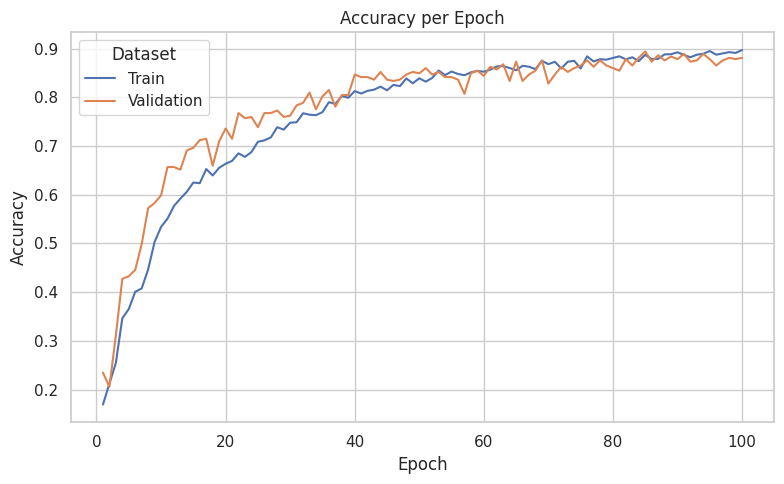

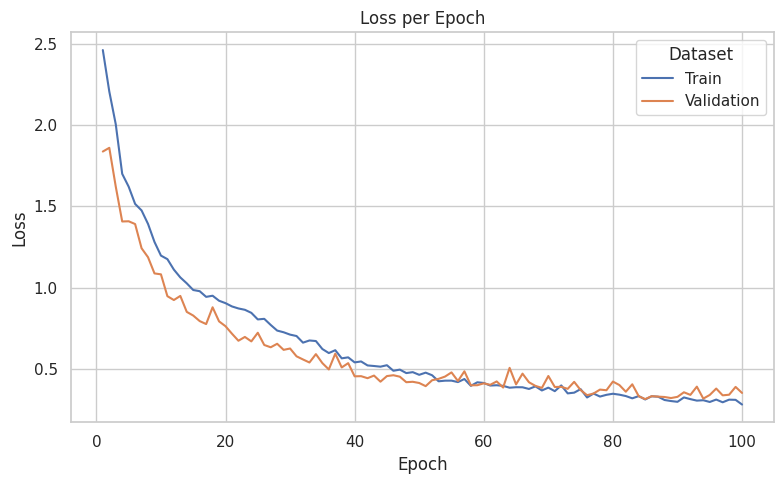

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
train_vit_drone.py
────────────────────────────────────────────────────────────────────────
Trains a Vision Transformer from scratch to classify drone types based on
generated spectrogram PNGs. Includes:

• PNG indexing and validation (skips corrupted)
• 80/10/10 stratified train/val/test split
• ImageDataGenerator (augmentation on training)
• GPU training if available (memory growth enabled)
• Checkpoint each epoch + best model saved by val_accuracy
• CSVLogger of epoch metrics
• Accuracy and loss plots with seaborn (English labels)
"""
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sns
import matplotlib.pyplot as plt

# ─────────── PARAMETERS ──────────


ROOT_IMG   = Path("/content/drive/MyDrive/Projeto - Classificação RF/"
                   "DroneDetect_V2/DroneDetect_V2_FEATURES_MOD_50ms/IMG_SPEC")
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_50ms")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

BEST_MODEL = MODEL_DIR / "vit_drone.h5"
CKPT_TPL   = MODEL_DIR / "ckpt_epoch_{epoch:03d}.h5"
LOG_CSV    = MODEL_DIR / "training_log.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCHS     = 100
SEED       = 42

# ─────────── GPU SETUP ──────────
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detected: {gpus[0].name}")
    except RuntimeError:
        print("GPUs already initialized; memory growth could not be configured.")
else:
    print("GPU not found; using CPU.")

# ─────────── 1) INDEX & VALIDATE PNGs ──────────
rows, bad = [], []
for p in tqdm(ROOT_IMG.rglob("*.png"), desc="Indexing/validating PNGs"):
    try:
        with Image.open(p) as im:
            im.verify()
        label = p.stem.split("_")[1]
        rows.append({"path": str(p), "label": label})
    except Exception:
        bad.append(str(p))

print(f"\nValid images: {len(rows)}")
print(f"Corrupted PNGs: {len(bad)}")
if bad:
    pd.Series(bad).to_csv(MODEL_DIR / "corrupted_files.csv", index=False, header=False)

df = pd.DataFrame(rows)
print("\nOriginal distribution (post-filter):")
print(df["label"].value_counts())

# ─────────── 2) TRAIN/VAL/TEST SPLIT ──────────
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("\nDistribution after split:")
for tag, subset in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"{tag:10}:")
    print(subset["label"].value_counts())

train_df.to_csv(MODEL_DIR / "train_split.csv", index=False)
val_df.to_csv(MODEL_DIR / "val_split.csv", index=False)
test_df.to_csv(MODEL_DIR / "test_split.csv", index=False)

# ─────────── 3) IMAGE DATA GENERATORS ──────────
aug_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
aug_val = ImageDataGenerator(rescale=1/255)

def make_generator(df, dg, shuffle):
    return dg.flow_from_dataframe(
        df, x_col="path", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH_SIZE, shuffle=shuffle, seed=SEED
    )

gen_train = make_generator(train_df, aug_train, shuffle=True)
gen_val   = make_generator(val_df,   aug_val,   shuffle=False)

num_classes = len(gen_train.class_indices)
print(f"\nClasses → indices: {gen_train.class_indices}")

# ─────────── 4) BUILD & COMPILE MODEL (USING VISION TRANSFORMER) ──────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128, transformer_layers=8,
                          dropout=0.5):
    """
    Basic Vision Transformer:
    - Extract patches via Conv2D
    - Project patches into embeddings
    - Add positional embeddings
    - Stack transformer blocks (MHSA + MLP)
    - Pool and classification head
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim), name='reshape_patches')(x)

    # 2) Positional embedding
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=n_patches,
                                     output_dim=embed_dim,
                                     name='pos_embedding')(positions)
    x = x + pos_embedding

    # 3) Transformer blocks
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln1_block{i}')(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads,
                                         key_dim=embed_dim,
                                         name=f'mhsa_block{i}')(x1, x1)
        x2 = layers.Add(name=f'residual_attn_block{i}')([attn, x])

        x3 = layers.LayerNormalization(epsilon=1e-6,
                                       name=f'ln2_block{i}')(x2)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(x3)
        mlp = layers.Dense(embed_dim,
                           name=f'mlp2_block{i}')(mlp)
        x = layers.Add(name=f'residual_mlp_block{i}')([mlp, x2])

    # 4) Pooling + classifier head
    x = layers.LayerNormalization(epsilon=1e-6,
                                   name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs=inputs, outputs=outputs, name='ViT_Classifier')

strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=num_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

model.summary()

# ─────────── 5) CALLBACKS ──────────
checkpoint_each = ModelCheckpoint(CKPT_TPL,
                                  save_best_only=False,
                                  save_freq='epoch', verbose=0)
checkpoint_best = ModelCheckpoint(BEST_MODEL,
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy",
                           patience=15,
                           restore_best_weights=True,
                           verbose=1)
csv_logger = CSVLogger(LOG_CSV, append=False)

# ─────────── 6) TRAINING ──────────
history = model.fit(
    gen_train,
    validation_data=gen_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_each, checkpoint_best, early_stop, csv_logger],
    verbose=2
)

# ─────────── 7) PLOTS WITH SEABORN ──────────
sns.set(style="whitegrid")
history_df = pd.DataFrame(history.history)
epochs = history_df.index + 1

# Accuracy plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['accuracy'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=history_df['loss'], label='Train')
sns.lineplot(x=epochs, y=history_df['val_loss'], label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()



► Attempting to load model from /content/drive/MyDrive/DroneDetect_ViT_50ms/vit_drone.h5 …
⚠ Could not load full model (too many positional arguments). Rebuilding architecture …
✔ Weights loaded with model.load_weights().

Total test samples: 380
Test-set class distribution:
 label
INS    60
MIN    60
AIR    60
MP1    60
MP2    60
PHA    40
DIS    40
Name: count, dtype: int64 

Found 380 validated image filenames belonging to 7 classes.
► Generating predictions …


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         AIR     0.8936    0.7000    0.7850        60
         DIS     0.9750    0.9750    0.9750        40
         INS     0.8438    0.9000    0.8710        60
         MIN     0.9677    1.0000    0.9836        60
         MP1     0.9804    0.8333    0.9009        60
         MP2     0.7200    0.9000    0.8000        60
         PHA     0.9512    0.9750    0.9630        40

    accuracy                         0.8895       380
   macro avg     0.9045    0.8976    0.8969       380
weighted avg     0.8984    0.8895    0.8893       380



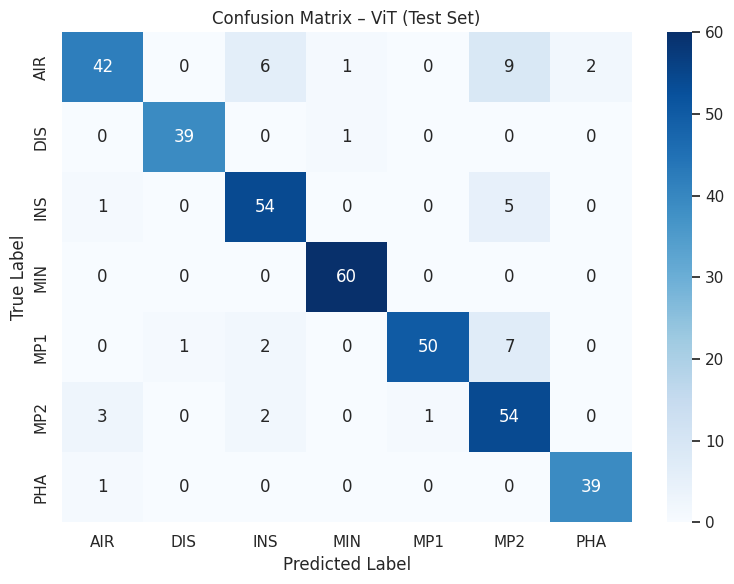

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
test_vit_drone.py
────────────────────────────────────────────────────────────────────────
Evaluates the Vision Transformer (ViT) trained to classify drone types.

Workflow
╰─►  1) Attempts to load the full .h5 model; if that fails, rebuilds the
        architecture and loads only the weights.
     2) Generates predictions on the test split stored in test_split.csv.
     3) Prints a classification report and displays a confusion matrix
        with English titles and axis labels.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ─────────── PARAMETERS ───────────
MODEL_DIR  = Path("/content/drive/MyDrive/DroneDetect_ViT_50ms")
MODEL_PATH = MODEL_DIR / "vit_drone.h5"
TEST_CSV   = MODEL_DIR / "test_split.csv"


IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 1) Function to rebuild the same ViT architecture used during training
# ──────────────────────────────────────────────────────────────────────────────
def create_vit_classifier(input_shape, num_classes,
                          patch_size=16, embed_dim=64,
                          num_heads=4, mlp_dim=128,
                          transformer_layers=8, dropout=0.5):
    """Minimal Vision Transformer classifier."""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    x = layers.Conv2D(embed_dim,
                      kernel_size=patch_size,
                      strides=patch_size,
                      padding='valid',
                      name='patch_embedding')(inputs)
    n_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((n_patches, embed_dim),
                       name='reshape_patches')(x)

    # Learnable positional embeddings
    positions = tf.range(start=0, limit=n_patches, delta=1)
    pos_emb   = layers.Embedding(input_dim=n_patches,
                                 output_dim=embed_dim,
                                 name='pos_embedding')(positions)
    x = x + pos_emb

    # Transformer encoder blocks
    for i in range(transformer_layers):
        # Multi-head self-attention
        ln1 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln1_block{i}')(x)
        att = layers.MultiHeadAttention(num_heads=num_heads,
                                        key_dim=embed_dim,
                                        name=f'mhsa_block{i}')(ln1, ln1)
        x   = layers.Add(name=f'residual_attn_block{i}')([att, x])

        # Feed-forward MLP
        ln2 = layers.LayerNormalization(epsilon=1e-6,
                                        name=f'ln2_block{i}')(x)
        mlp = layers.Dense(mlp_dim, activation='gelu',
                           name=f'mlp1_block{i}')(ln2)
        mlp = layers.Dense(embed_dim, name=f'mlp2_block{i}')(mlp)
        x   = layers.Add(name=f'residual_mlp_block{i}')([mlp, x])

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6, name='ln_final')(x)
    x = layers.GlobalAveragePooling1D(name='gap')(x)
    x = layers.Dropout(dropout, name='dropout_head')(x)
    outputs = layers.Dense(num_classes, activation='softmax',
                           name='classifier')(x)

    return models.Model(inputs, outputs, name='ViT_Classifier')

# ──────────────────────────────────────────────────────────────────────────────
# 2) Load the trained model (full model or just weights)
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n► Attempting to load model from {MODEL_PATH} …")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✔ Model loaded successfully with tf.keras.models.load_model().")
except Exception as e:
    print(f"⚠ Could not load full model ({e}). Rebuilding architecture …")
    # Read test CSV to infer the number of classes
    tmp_df     = pd.read_csv(TEST_CSV)
    class_list = sorted(tmp_df["label"].unique())
    n_classes  = len(class_list)

    model = create_vit_classifier(
        input_shape=(*IMG_SIZE, 3),
        num_classes=n_classes,
        patch_size=16,
        embed_dim=64,
        num_heads=4,
        mlp_dim=128,
        transformer_layers=8,
        dropout=0.5
    )
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.load_weights(MODEL_PATH)
    print("✔ Weights loaded with model.load_weights().")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Prepare the test data generator
# ──────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv(TEST_CSV)
print(f"\nTotal test samples: {len(test_df)}")
print("Test-set class distribution:\n", test_df["label"].value_counts(), "\n")

datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)
label_names = list(gen_test.class_indices.keys())

# ──────────────────────────────────────────────────────────────────────────────
# 4) Evaluation
# ──────────────────────────────────────────────────────────────────────────────
print("► Generating predictions …")
probs  = model.predict(gen_test, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = gen_test.classes

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred,
                            target_names=label_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title("Confusion Matrix – ViT (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
